In [1]:
import sys
import torch
import numpy as np

# Python 버전
print(f"Python version: {sys.version}")
# PyTorch 버전
print(f"PyTorch version: {torch.__version__}")
# CUDA 사용 가능 여부
print(f"CUDA available: {torch.cuda.is_available()}")
# PyTorch가 사용하는 CUDA 버전
print(f"PyTorch CUDA version: {torch.version.cuda}")

print(np.__version__)

Python version: 3.10.16 | packaged by Anaconda, Inc. | (main, Dec 11 2024, 16:19:12) [MSC v.1929 64 bit (AMD64)]
PyTorch version: 2.5.1
CUDA available: True
PyTorch CUDA version: 12.1
1.24.4


In [ ]:
!git clone https://github.com/bamsumit/slayerPytorch
!pip install dv
!pip install ninja
exit()

In [ ]:
%cd slayerPytorch/
!python setup.py install
exit()

In [ ]:
%cd slayerPytorch/test/
!python -m  unittest

In [2]:
%cd /home/DVSAttacks/slayerPytorch

D:\home\DVSAttacks\slayerPytorch


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import slayerSNN as snn
from dv import LegacyAedatFile

path = 'DvsGesture/'

actionName = [
    'hand_clapping',
    'right_hand_wave',
    'left_hand_wave',
    'right_arm_clockwise',
    'right_arm_counter_clockwise',
    'left_arm_clockwise', 
    'left_arm_counter_clockwise',
    'arm_roll',
    'air_drums',
    'air_guitar',
    'other_gestures',
]

def readAedatEvent(filename):
    xEvent = []
    yEvent = []
    pEvent = []
    tEvent = []
    with LegacyAedatFile(filename) as f:
        for event in f:
            xEvent.append(event.x)
            yEvent.append(event.y)
            pEvent.append(event.polarity)
            tEvent.append(event.timestamp/1000)

    return xEvent, yEvent, pEvent, tEvent

def splitData(filename, path):
    x,y,p,t = readAedatEvent(path+filename+'.aedat')
    labels = np.loadtxt(path + filename + '_labels.csv', delimiter=',', skiprows=1)
    labels[:,0]  -= 1
    labels[:,1:]
    if not os.path.isdir(path+ 'data/' + filename):
        os.makedirs(os.path.join(path,'data/' + filename))
    lastAction = 100
    for action, tst, ten in labels:
        if action == lastAction:    continue # This is to ignore second arm_roll samples
        print(actionName[int(action)])
        ind = (t >= tst/1000) & (t < ten/1000)
        ind_in = np.argmax(ind)
        ind_end = ind_in+np.argmin(ind[(ind.argmax()):-1])
        if ind_end == ind_in:
          ind_end = 0
        TD = snn.io.event(x[ind_in:ind_end-1], y[ind_in:ind_end-1], p[ind_in:ind_end-1], (t[ind_in:ind_end-1] - tst/1000))
        # snn.io.showTD(TD)
        lastAction = action

        snn.io.encodeNpSpikes(path+'data/'+ filename + '/{:g}.npy'.format(action), TD)

   
if __name__ == '__main__':
    user = np.arange(29) + 1
    lighting = [
        'fluorescent',
        'fluorescent_led',
        'lab',
        'led',
        'natural',
    ]
    count = 0
    for id in user:
        for light in lighting:
            filename = 'user{:02d}_{}'.format(id, light)
            if os.path.isfile(path + filename + '.aedat'):
                print(count, filename)
                splitData(filename, path)
                count += 1

In [3]:
import sys, os
CURRENT_TEST_DIR = os.getcwd()
sys.path.append(CURRENT_TEST_DIR + "/../../src")

from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
import torch
from torch.utils.data import Dataset, DataLoader
import slayerSNN as snn
#from learningStats import learningStats
from IPython.display import HTML
import time
import shutil

def save_ckp(state, is_best_loss, is_best_acc, checkpoint_dir, best_model_dir):
    f_path = checkpoint_dir+'checkpoint.pt'
    torch.save(state, f_path)
    if is_best_loss:
        best_fpath = best_model_dir+'best_model.pt'
        shutil.copyfile(f_path, best_fpath)
    if is_best_acc:
        acc_fpath =  best_model_dir+'best_acc.pt'
        shutil.copyfile(f_path, acc_fpath)

def load_ckp(checkpoint_fpath, model, optimizer):
    checkpoint = torch.load(checkpoint_fpath, weights_only=False)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    return model, optimizer, checkpoint['epoch']

actionName = [
    'hand_clapping',
    'right_hand_wave',
    'left_hand_wave',
    'right_arm_clockwise',
    'right_arm_counter_clockwise',
    'left_arm_clockwise',
    'left_arm_counter_clockwise',
    'arm_roll',
    'air_drums',
    'air_guitar',
    'other_gestures',
]

# Define dataset module
class IBMGestureDataset(Dataset):
    def __init__(self, datasetPath, sampleFile, samplingTime, sampleLength):
        self.path = datasetPath
        self.samples = np.loadtxt(sampleFile).astype('int')
        self.samplingTime = samplingTime
        self.nTimeBins    = int(sampleLength / samplingTime)

    def __getitem__(self, index):
        inputIndex  = self.samples[index, 0]
        classLabel  = self.samples[index, 1]
        file_path = self.path + str(inputIndex.item()) + '.npy'

        try:
            # 파일을 읽어 SpikeTensor로 변환 시도
            inputSpikes = snn.io.readNpSpikes(file_path).toSpikeTensor(
                            torch.zeros((2,128,128,self.nTimeBins)),
                            samplingTime=self.samplingTime
                          )
        except Exception as e:
            # 파일 로딩 중 어떤 오류라도 발생하면 (비어있거나, 손상되었거나 등)
            print(f"\n경고: '{file_path}' 파일을 읽는 중 문제가 발생하여 건너뜁니다. (오류: {e})")
            # 해당 샘플은 비어있는 텐서로 대체하여 학습에 영향을 최소화
            inputSpikes = torch.zeros((2,128,128,self.nTimeBins))

        # Create one-hot encoded desired matrix
        desiredClass = torch.zeros((11, 1, 1, 1))
        desiredClass[classLabel,...] = 1

        return inputSpikes, desiredClass, classLabel

    def __len__(self):
        return self.samples.shape[0]

# Define the network
class Network(torch.nn.Module):
    def __init__(self, netParams):
        super(Network, self).__init__()
        # initialize slayer
        slayer = snn.loihi(netParams['neuron'], netParams['simulation'])
        self.slayer = slayer
        # define network functions
        self.conv1 = slayer.conv(2, 16, 5, padding=2, weightScale=10)
        self.conv2 = slayer.conv(16, 32, 3, padding=1, weightScale=50)
        self.pool1 = slayer.pool(4)
        self.pool2 = slayer.pool(2)
        self.pool3 = slayer.pool(2)
        self.fc1   = slayer.dense((8*8*32), 512)
        self.fc2   = slayer.dense(512, 11)
        self.drop  = slayer.dropout(0.1)

    def forward(self, spikeInput):
        spike = self.slayer.spikeLoihi(self.pool1(spikeInput )) # 32, 32, 2
        spike = self.slayer.delayShift(spike, 1)

        spike = self.drop(spike)
        spike = self.slayer.spikeLoihi(self.conv1(spike)) # 32, 32, 16
        spike = self.slayer.delayShift(spike, 1)

        spike = self.slayer.spikeLoihi(self.pool2(spike)) # 16, 16, 16
        spike = self.slayer.delayShift(spike, 1)

        spike = self.drop(spike)
        spike = self.slayer.spikeLoihi(self.conv2(spike)) # 16, 16, 32
        spike = self.slayer.delayShift(spike, 1)

        spike = self.slayer.spikeLoihi(self.pool3(spike)) #  8,  8, 32
        spike = spike.reshape((spike.shape[0], -1, 1, 1, spike.shape[-1]))
        spike = self.slayer.delayShift(spike, 1)

        spike = self.drop(spike)
        spike = self.slayer.spikeLoihi(self.fc1  (spike)) # 512
        spike = self.slayer.delayShift(spike, 1)

        spike = self.slayer.spikeLoihi(self.fc2  (spike)) # 11
        spike = self.slayer.delayShift(spike, 1)

        return spike

In [4]:
%cd /home/DVSAttacks/slayerPytorch/exampleLoihi/03_IBMGesture

D:\home\DVSAttacks\slayerPytorch\exampleLoihi\03_IBMGesture


In [ ]:
import os
import shutil

# trials_to_train 폴더들이 있는 디렉토리 경로
trials_to_train = [
    "user01_fluorescent",
    "user01_fluorescent_led",
    "user01_lab",
    "user01_led",
    "user01_natural",
    "user02_fluorescent",
    "user02_fluorescent_led",
    "user02_lab",
    "user02_led",
    "user02_natural",
    "user03_fluorescent",
    "user03_fluorescent_led",
    "user03_led",
    "user03_natural",
    "user04_fluorescent",
    "user04_fluorescent_led",
    "user04_led",
    "user04_natural",
    "user05_fluorescent",
    "user05_fluorescent_led",
    "user05_lab",
    "user05_led",
    "user05_natural",
    "user06_fluorescent",
    "user06_fluorescent_led",
    "user06_lab",
    "user06_led",
    "user06_natural",
    "user07_fluorescent",
    "user07_fluorescent_led",
    "user07_lab",
    "user07_led",
    "user08_fluorescent",
    "user08_fluorescent_led",
    "user08_lab",
    "user08_led",
    "user09_fluorescent",
    "user09_fluorescent_led",
    "user09_lab",
    "user09_led",
    "user09_natural",
    "user10_fluorescent",
    "user10_fluorescent_led",
    "user10_lab",
    "user10_led",
    "user11_fluorescent",
    "user11_fluorescent_led",
    "user11_natural",
    "user12_fluorescent_led",
    "user12_led",
    "user13_fluorescent",
    "user13_fluorescent_led",
    "user13_lab",
    "user13_led",
    "user13_natural",
    "user14_fluorescent",
    "user14_fluorescent_led",
    "user14_led",
    "user14_natural",
    "user15_fluorescent",
    "user15_fluorescent_led",
    "user15_lab",
    "user15_led",
    "user15_natural",
    "user16_fluorescent",
    "user16_lab",
    "user16_led",
    "user16_natural",
    "user17_fluorescent",
    "user17_fluorescent_led",
    "user17_lab",
    "user17_led",
    "user17_natural",
    "user18_fluorescent",
    "user18_fluorescent_led",
    "user18_lab",
    "user18_led",
    "user19_fluorescent",
    "user19_fluorescent_led",
    "user19_lab",
    "user19_led",
    "user19_natural",
    "user20_fluorescent",
    "user20_fluorescent_led",
    "user20_led",
    "user21_fluorescent",
    "user21_fluorescent_led",
    "user21_lab",
    "user21_natural",
    "user22_fluorescent",
    "user22_fluorescent_led",
    "user22_lab",
    "user22_led",
    "user22_natural",
    "user23_fluorescent",
    "user23_fluorescent_led",
    "user23_lab",
    "user23_led",
]

import numpy as np

i = 1
cur = 0
if not os.path.isdir("/home/DVSAttacks/slayerPytorch/exampleLoihi/03_IBMGesture/Train"):
        os.makedirs('./Train')
for trial in trials_to_train:
    for j in range(11):
      path = "/home/DVSAttacks/slayerPytorch/DvsGesture/data/" + trial + "/{}.npy".format(j)
      if not os.path.isfile(path):
        continue

      # 파일 복사
      to_file_path = "/home/DVSAttacks/slayerPytorch/exampleLoihi/03_IBMGesture/Train/{}.npy".format(i-1)
      shutil.copyfile(path, to_file_path)

      # train.txt 생성
      with open('./Train/train.txt', 'a') as f:
        f.write('{} {}\n'.format(i-1, j))
      print(i)
      i += 1


In [ ]:
import os
import shutil

# trials_to_test 폴더들이 있는 디렉토리 경로
trials_to_train = [
    "user24_fluorescent",
    "user24_fluorescent_led",
    "user24_led",
    "user25_fluorescent",
    "user25_led",
    "user26_fluorescent",
    "user26_fluorescent_led",
    "user26_lab",
    "user26_led",
    "user26_natural",
    "user27_fluorescent",
    "user27_fluorescent_led",
    "user27_led",
    "user27_natural",
    "user28_fluorescent",
    "user28_fluorescent_led",
    "user28_lab",
    "user28_led",
    "user28_natural",
    "user29_fluorescent",
    "user29_fluorescent_led",
    "user29_lab",
    "user29_led",
    "user29_natural"
]

import numpy as np

i = 1078
if not os.path.isdir("/home/DVSAttacks/slayerPytorch/exampleLoihi/03_IBMGesture/Test"):
        os.makedirs('./Test')
for trial in trials_to_train:
    for j in range(11):
      path = "/home/DVSAttacks/slayerPytorch/DvsGesture/data/" + trial + "/{}.npy".format(j)
      if not os.path.isfile(path):
        continue

      # 파일 복사
      to_file_path = "/home/DVSAttacks/slayerPytorch/exampleLoihi/03_IBMGesture/Test/{}.npy".format(i-1078)
      shutil.copyfile(path, to_file_path)

      # test.txt 생성
      with open('/home/DVSAttacks/slayerPytorch/exampleLoihi/03_IBMGesture/Test/test.txt', 'a') as f:
        f.write('{} {}\n'.format(i-1078, j))
      print(i)
      i += 1

In [5]:
if __name__ == '__main__':
  netParams = snn.params('network.yaml')

  # Define the cuda device to run the code on.
  device = torch.device('cuda')
  # deviceIds = [2, 3]

  # Create network instance.
  net = Network(netParams).to(device)
  # net = torch.nn.DataParallel(Network(netParams).to(device), device_ids=deviceIds)

  # Create snn loss instance.
  error = snn.loss(netParams, snn.loihi).to(device)

  # Define optimizer module.
  # net = torch.nn.DataParallel(Network(netParams).to(device), device_ids=deviceIds)
  optimizer = snn.utils.optim.Nadam(net.parameters(), lr = 0.0001, amsgrad=True)

  #Dataset and dataLoader instances.
  trainingSet = IBMGestureDataset(datasetPath ="Train/", sampleFile="Train/train.txt", samplingTime=1.0, sampleLength=1450)

  trainLoader = DataLoader(dataset=trainingSet, batch_size=2, shuffle=True, num_workers=0)

  testingSet = IBMGestureDataset(datasetPath ="Test/", sampleFile = "Test/test.txt", samplingTime=1.0, sampleLength=1450)
  testLoader = DataLoader(dataset=testingSet, batch_size=2, shuffle=True, num_workers=0)

  train_clusteringSet = IBMGestureDataset(datasetPath ="train_cluster_window10_5_100/", sampleFile="Train/train.txt", samplingTime=1.0, sampleLength=1450)
  train_clusterLoader = DataLoader(dataset=train_clusteringSet, batch_size=2, shuffle=True, num_workers=0)

  test_clusteringSet = IBMGestureDataset(datasetPath ="dashattack_cluster_window10_5_100_filtered_ver2/", sampleFile="Test/test.txt", samplingTime=1.0, sampleLength=1450)
  test_clusterLoader = DataLoader(dataset=test_clusteringSet, batch_size=2, shuffle=True, num_workers=0)

  # Learning stats instance.
  stats = snn.utils.stats()
  start_epoch = 0

Max PSP kernel: 195.0
Scaling neuron[scaleRho] by Max PSP Kernel @slayerLoihi
Max PSP kernel: 195.0
Scaling neuron[scaleRho] by Max PSP Kernel @slayerLoihi


In [ ]:
i = 3
input, target, label = testingSet[i]
print(actionName[label])
#snn.io.showTD(snn.io.spikeArrayToEvent(input.reshape((2, 128, 128, -1)).cpu().data.numpy()))
anim = snn.io.animTD(snn.io.spikeArrayToEvent(input.reshape((2, 128, 128, -1)).cpu().data.numpy()))
HTML(anim.to_jshtml())

In [6]:
# model load
net, optimizer, start_epoch = load_ckp('../../checkpointbest_acc.pt', net, optimizer)

In [ ]:
# 에포크 마다 학습, 테스트, 체크포인트 저장
for epoch in range(start_epoch,start_epoch+100):
	tSt = datetime.now()

	# Training loop.
	for i, (input, target, label) in enumerate(trainLoader, 0):
		net.train()

		# Move the input and target to correct GPU.
		input  = input.to(device)
		target = target.to(device)

		# Forward pass of the network.
		output = net.forward(input)

		# Gather the training stats.
		stats.training.correctSamples += torch.sum( snn.predict.getClass(output) == label ).data.item()
		stats.training.numSamples     += len(label)
		# Calculate loss.
		loss = error.numSpikes(output, target)
		# Reset gradients to zero.
		optimizer.zero_grad()
		# Backward pass of the network.
		loss.backward()
		# Update weights.
		optimizer.step()
		# Gather training loss stats.
		stats.training.lossSum += loss.cpu().data.item()
		# Display training stats.
		stats.print(epoch, i, (datetime.now() - tSt).total_seconds())
  # Testing loop.
  # Same steps as Training loops except loss backpropagation and weight update.
	for i, (input, target, label) in enumerate(testLoader, 0):
		net.eval()
		with torch.no_grad():
		  input = input.to(device)
		  target = target.to(device)
		output = net.forward(input)
		stats.testing.correctSamples += torch.sum( snn.predict.getClass(output) == label ).data.item()
		stats.testing.numSamples     += len(label)
		loss = error.numSpikes(output, target)
		stats.testing.lossSum += loss.cpu().data.item()
		stats.print(epoch,i)
	stats.update()
	checkpoint={
				'epoch': epoch+1,
				'state_dict':net.state_dict(),
				'optimizer': optimizer.state_dict()}
	save_ckp(checkpoint,stats.training.bestLoss, stats.testing.bestAccuracy,'../../checkpoint', '../../checkpoint')


In [ ]:
#Dash Attack
import numpy as np
import torch
import time

def cornerGen(x=0,y=0,left=False, N=128,T=1450):
  corner = torch.zeros(N,N,T)
  if left:
        corner[x, y, :] = 1
        corner[x, y-1, :] = 1
  else:
        corner[x, N-y, :] = 1
        corner[x, N-y+1, :] = 1
    
  return corner.expand(2, N, N, T)
  #for i in range(N):
    #for j in range(N):
      #if left:
        #if (i==x) and (j==y or j== y-1):
          #corner[i,j,:]=1
      #else:
        #if (i==x) and (j==N-y or j== N-y+1):
          #corner[i,j,:]=1        

  #return corner.expand(2,N,N,T)

testSet = IBMGestureDataset(datasetPath  =  '/home/DVSAttacks/slayerPytorch/exampleLoihi/03_IBMGesture/Test/', 
                              sampleFile  ='/home/DVSAttacks/slayerPytorch/exampleLoihi/03_IBMGesture/Test/test.txt',
                              samplingTime=1.0,
                              sampleLength=1450)
testLoader = DataLoader(dataset=testSet, batch_size=1, shuffle=False, num_workers=4) 

samples = [i for i in range(264)]
stats.testing.reset()
it=0
N=128
flag=0
left = 1
x=0
y=2
max_y=2
start=time.time()
while samples and x<N and y<N:
  temp= list(samples)
  corner= cornerGen(x,y,left)
  for i  in temp:

    input,target,label=testSet[i]
    
    adv= input.unsqueeze(dim=0)+corner
    with torch.no_grad():
      adv  = adv.to(device)
      target = target.to(device) 

    output = net.forward(adv)
    if (snn.predict.getClass(output) != label):
      #print(f' Sample {i} , {label}')
      try: 
        samples.remove(i)
      except:
        print(f'{i} not in list')
      # Save adversarial dataset as spike events
      image = torch.reshape(adv, (2,N,N,1450)).cpu().detach()
      TD = snn.io.spikeArrayToEvent(image.numpy(), samplingTime=1)
      snn.io.encodeNpSpikes("/home/DVSAttacks/slayerPytorch/exampleLoihi/03_IBMGesture/Test/{}.npy".format(i), TD)
  print(f'remaining samples {len(samples)}, x = {x}, y={y}', 'left' if left else 'right')

  if flag:
    x= 0
    flag^=1
    left^=1
    if left:
      if y==2:
        y=5
      else:
        y+=4
  else:
    x= N-1
    flag^=1

print(time.time()-start)

In [ ]:
# MF-Aware Dash Attack

import numpy as np
import torch
import time
import os 
import slayerSNN as snn 
from torch.utils.data import Dataset, DataLoader 
import pickle 


def dashGen(x=0,y=2,left=False,ps0=10, N=128,T=1450):
    ps=ps0
    dash = torch.zeros((2,N,N,T))
    # Optimized version of dashGen without inner loops
    time_indices = torch.arange(T)
    current_ps = ps0
    current_y = y
    while current_ps <= T and current_y < N:
        indices = time_indices < current_ps
        if left:
            dash[0, x, y, indices] = 1
            if y > 0:
                 dash[0, x, y-1, indices] = 1
        else:
            dash[1, x, N-current_y, indices] = 1
            if N-current_y > 0: # Ensure index is valid
                 dash[1, x, N-current_y-1, indices] = 1 # Corrected index calculation
        current_ps += ps0
        current_y += 2

    return dash


# --- 경로 설정 ---
original_test_path = '/home/DVSAttacks/slayerPytorch/exampleLoihi/03_IBMGesture/Test/'
original_sample_file = '/home/DVSAttacks/slayerPytorch/exampleLoihi/03_IBMGesture/Test/test.txt'

# 결과를 저장할 새로운 폴더 경로
output_folder = 'mf_aware_dashattack/'

# --- 출력 폴더 생성 ---
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    print(f"'{output_folder}' 폴더를 생성했습니다.")

# 원본 Test 데이터셋 로드
try:
    testSet = IBMGestureDataset(datasetPath=original_test_path,
                                sampleFile=original_sample_file,
                                samplingTime=1.0,
                                sampleLength=1450)
    samples_info = np.loadtxt(original_sample_file).astype('int')
except FileNotFoundError:
    print(f"오류: '{original_sample_file}' 또는 '{original_test_path}'를 찾을 수 없습니다.")
    samples_info = []

N=128
start=time.time()

# MF-Aware Dash Attack 적용 및 저장
# 원본 코드의 while 루프는 최소 공격을 찾는 과정이었으나, 여기서는 모든 샘플에
# 고정된 파라미터 (초기값 기준)로 공격을 적용하고 저장하는 방식으로 변경합니다.
x_attack = 0     # 공격 패턴의 x 좌표 (원본 코드 초기값)
y_attack = 2     # 공격 패턴의 초기 y 너비 (원본 코드 초기값)
left_attack = True # 공격 패턴의 방향 (원본 코드 초기값)
ps0_attack = 100 # 공격의 시간 간격 (원본 코드 값)

print(f"모든 테스트 샘플에 MF-Aware Dash Attack (x={x_attack}, initial_y={y_attack}, left={left_attack}, ps0={ps0_attack}) 적용 및 저장 시작...")

# Dash 패턴 미리 생성 (모든 샘플에 동일한 패턴 적용)
dash_pattern = dashGen(x_attack, y_attack, left_attack, ps0_attack)

# tqdm을 사용하면 진행률을 볼 수 있습니다 (선택사항, pip install tqdm 필요)
# from tqdm import tqdm
# for sample_info in tqdm(samples_info, desc="MF-Aware Dash Attack 적용 중"):
for sample_info in samples_info:
    i = sample_info[0] # 파일 인덱스

    try:
        # 1. 원본 데이터 로드
        input_data, target, label = testSet[i]

        # 2. 원본 데이터에 Dash 패턴 더하기 (CPU에서 수행)
        #    torch.clamp 로 픽셀값이 1을 넘지 않도록 제한
        adv = torch.clamp(input_data + dash_pattern, 0, 1)

        # 3. 공격 적용된 데이터를 .npy 파일로 저장
        #    저장 경로를 새로운 'mf_aware_dashattack/' 폴더로 지정
        output_file_path = os.path.join(output_folder, f"{i}.npy")

        #   SpikeTensor를 event 객체로 변환 후 저장
        image_tensor = torch.reshape(adv, (2,N,N,1450))
        # .cpu() 호출 추가 및 .numpy() 수정
        TD = snn.io.spikeArrayToEvent(image_tensor.cpu().numpy(), samplingTime=1)

        snn.io.encodeNpSpikes(output_file_path, TD)

    except FileNotFoundError:
         print(f"경고: 원본 파일 '{original_test_path}{i}.npy'를 찾을 수 없어 건너<0xEB><0x9A><0x81>니다.")
    except Exception as e:
         print(f"오류 발생 (파일 {i}): {e}")


print(f"\nMF-Aware Dash Attack 적용 완료. 결과가 '{output_folder}' 폴더에 저장되었습니다.")
print(f"총 소요 시간: {time.time()-start:.2f} 초")

In [ ]:
# Background Activity Filter(clean) - DVS-Attacks version
import numpy as np

def update(x,y,t,A,s):
  for i in range(x-s,x+s+1):
     for j in range(y-s,y+s+1):
        if not(i==x and j==y) and i>0 and j>0 and i<128 and j<128:
	        A[i][j] = t

testSet = IBMGestureDataset(datasetPath  =  '/home/DVSAttacks/slayerPytorch/exampleLoihi/03_IBMGesture/Test/', 
                              sampleFile  ='/home/DVSAttacks/slayerPytorch/exampleLoihi/03_IBMGesture/Test/test.txt',
                              samplingTime=1.0,
                              sampleLength=1450)
testLoader = DataLoader(dataset=testSet, batch_size=1, shuffle=False, num_workers=4)

for s in [1,2,3,4]:
  stats1 = snn.utils.stats()
  stats5 = snn.utils.stats()
  stats10 = snn.utils.stats()
  stats20 = snn.utils.stats()          

  for i in range(264):     
    input,target,label = testSet[i]    
    data= np.load('/home/DVSAttacks/slayerPytorch/exampleLoihi/03_IBMGesture/Test/{}.npy'.format(i))
    data= data[data[:,3].argsort()] #sort elements by timestamp
    temp=np.zeros((128,128))
    real1=[]
    real5=[]
    real10=[]
    real20=[]
    for d in data:
      update(int(d[0]),int(d[1]),d[3],temp,s)
      if d[3]-temp[int(d[0])][int(d[1])]<1:
        real1.append(d)

      if d[3]-temp[int(d[0])][int(d[1])]<5:
        real5.append(d)   

      if d[3]-temp[int(d[0])][int(d[1])]<10:
        real10.append(d)

      if d[3]-temp[int(d[0])][int(d[1])]<20:
        real20.append(d)  

    real1=np.stack(real1, axis=0 )
    if not os.path.isdir("/home/DVSAttacks/slayerPytorch/exampleLoihi/03_IBMGesture/filtro/s{}_t{}".format(s, 1)):
        os.makedirs('/home//DVSAttacks/slayerPytorch/exampleLoihi/03_IBMGesture/filtro/s{}_t{}'.format(s, 1))
    with open("/home/DVSAttacks/slayerPytorch/exampleLoihi/03_IBMGesture/filtro/s{}_t{}/{}.npy".format(s, 1, i), "wb") as f:
      np.save(f,real1)
    input1 = snn.io.readNpSpikes(
        "/home/DVSAttacks/slayerPytorch/exampleLoihi/03_IBMGesture/filtro/s{}_t{}/{}.npy".format(s, 1, i)).toSpikeTensor(torch.zeros((2,128,128,1450)), samplingTime=1.0)
    input1 =  input1.to(device)
    output1 = net.forward(torch.unsqueeze(input1,dim=0))
    stats1.testing.correctSamples += torch.sum( snn.predict.getClass(output1) == label ).data.item()
    stats1.testing.numSamples     += 1
    #stats1.print(1,i)

    real5=np.stack(real5, axis=0 )
    if not os.path.isdir("/home/DVSAttacks/slayerPytorch/exampleLoihi/03_IBMGesture/filtro/s{}_t{}".format(s, 5)):
        os.makedirs('/home/DVSAttacks/slayerPytorch/exampleLoihi/03_IBMGesture/filtro/s{}_t{}'.format(s, 5))
    with open("/home/DVSAttacks/slayerPytorch/exampleLoihi/03_IBMGesture/filtro/s{}_t{}/{}.npy".format(s, 5, i), "wb") as f:
      np.save(f,real5)
    input5 = snn.io.readNpSpikes(
        "/home/DVSAttacks/slayerPytorch/exampleLoihi/03_IBMGesture/filtro/s{}_t{}/{}.npy".format(s, 5, i)).toSpikeTensor(torch.zeros((2,128,128,1450)), samplingTime=1.0)
    input5 =  input5.to(device)
    output5 = net.forward(torch.unsqueeze(input5,dim=0))
    stats5.testing.correctSamples += torch.sum( snn.predict.getClass(output5) == label ).data.item()
    stats5.testing.numSamples     += 1
    #stats5.print(1,i)

    real10=np.stack(real10, axis=0 )
    if not os.path.isdir("/home/DVSAttacks/slayerPytorch/exampleLoihi/03_IBMGesture/filtro/s{}_t{}".format(s, 10)):
        os.makedirs('/home/DVSAttacks/slayerPytorch/exampleLoihi/03_IBMGesture/filtro/s{}_t{}'.format(s, 10))
    with open("/home/DVSAttacks/slayerPytorch/exampleLoihi/03_IBMGesture/filtro/s{}_t{}/{}.npy".format(s, 10, i), "wb") as f:
      np.save(f,real10)
    input10 = snn.io.readNpSpikes(
        "/home/DVSAttacks/slayerPytorch/exampleLoihi/03_IBMGesture/filtro/s{}_t{}/{}.npy".format(s, 10, i)).toSpikeTensor(torch.zeros((2,128,128,1450)), samplingTime=1.0)
    input10 =  input10.to(device)
    output10 = net.forward(torch.unsqueeze(input10,dim=0))
    stats10.testing.correctSamples += torch.sum( snn.predict.getClass(output10) == label ).data.item()
    stats10.testing.numSamples     += 1
    #stats10.print(1,i)    

    real20=np.stack(real20, axis=0 )
    if not os.path.isdir("/home/DVSAttacks/slayerPytorch/exampleLoihi/03_IBMGesture/filtro/s{}_t{}".format(s, 20)):
        os.makedirs('/home/DVSAttacks/slayerPytorch/exampleLoihi/03_IBMGesture/filtro/s{}_t{}'.format(s, 20))
    with open("/home/DVSAttacks/slayerPytorch/exampleLoihi/03_IBMGesture/filtro/s{}_t{}/{}.npy".format(s, 20, i), "wb") as f:
      np.save(f,real20)
    input20= snn.io.readNpSpikes(
        "/home/DVSAttacks/slayerPytorch/exampleLoihi/03_IBMGesture/filtro/s{}_t{}/{}.npy".format(s, 20, i)).toSpikeTensor(torch.zeros((2,128,128,1450)), samplingTime=1.0)
    input20 =  input20.to(device)
    output20 = net.forward(torch.unsqueeze(input20,dim=0))
    stats20.testing.correctSamples += torch.sum( snn.predict.getClass(output20) == label ).data.item()
    stats20.testing.numSamples     += 1
  stats1.print(s,i)
  stats5.print(s,i)
  stats10.print(s,i)
  stats20.print(s,i)

In [13]:
# BAF 저장용

import numpy as np
import os
import torch
import slayerSNN as snn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# --- 1. BAF 업데이트 함수 ---
def update(x,y,t,A,s):
  for i in range(x-s,x+s+1):
     for j in range(y-s,y+s+1):
        if not(i==x and j==y) and i>0 and j>0 and i<128 and j<128:
            A[i][j] = t

# --- 2. 설정 ---
# 사용자 환경에 맞게 경로 수정 필요
DATASET_PATH = '/home/DVSAttacks/slayerPytorch/exampleLoihi/03_IBMGesture/Train/'
SAMPLE_FILE = '/home/DVSAttacks/slayerPytorch/exampleLoihi/03_IBMGesture/Train/train.txt'
OUTPUT_FOLDER = 'train_baf/' # 결과를 저장할 폴더

# BAF 파라미터 설정 (원하는 조합 선택)
SELECTED_S = 1
SELECTED_T = 5

# 폴더 생성
if not os.path.isdir(OUTPUT_FOLDER):
    os.makedirs(OUTPUT_FOLDER)
    print(f"'{OUTPUT_FOLDER}' 폴더를 생성했습니다.")

# 데이터셋 로드 (IBM Gesture)
# (IBMGestureDataset 클래스는 이미 정의되어 있다고 가정합니다)
testSet = IBMGestureDataset(datasetPath=DATASET_PATH, 
                            sampleFile=SAMPLE_FILE,
                            samplingTime=1.0,
                            sampleLength=1450)

# --- 3. BAF 실행 및 저장 ---
print(f"BAF 필터링 시작 (s={SELECTED_S}, t={SELECTED_T})...")

# test.txt 목록 생성용
output_list_file = os.path.join(OUTPUT_FOLDER, 'test.txt')
filtered_samples_list = []

# 264개 파일 순회 (tqdm으로 진행률 표시)
for i in tqdm(range(1077), desc="BAF Filtering"):
    input_data, target, label = testSet[i]
    
    # 원본 .npy 파일 로드
    file_path = os.path.join(DATASET_PATH, f'{i}.npy')
    try:
        data = np.load(file_path)
    except FileNotFoundError:
        print(f"경고: 파일 {i}.npy를 찾을 수 없습니다.")
        continue

    # 시간순 정렬
    data = data[data[:, 3].argsort()] 
    
    temp = np.zeros((128, 128)) # Activity Map 초기화
    filtered_events = [] # 필터링 통과한 이벤트 저장

    # 이벤트 하나씩 처리 (BAF 로직)
    for d in data:
        x, y, p, t = int(d[0]), int(d[1]), d[2], d[3]
        
        # 1. 이웃에게 시간 업데이트
        update(x, y, t, temp, SELECTED_S)
        
        # 2. 내 우편함 확인 (최근 활동 시간과의 차이)
        if t - temp[x][y] < SELECTED_T:
            # 최근에 이웃이 활동했으면 통과 (Real Event)
            filtered_events.append(d)

    # 필터링된 데이터가 있으면 저장
    if len(filtered_events) > 0:
        filtered_data = np.stack(filtered_events, axis=0)
    else:
        filtered_data = np.empty((0, 4)) # 없으면 빈 배열

    # 결과 저장
    output_path = os.path.join(OUTPUT_FOLDER, f'{i}.npy')
    np.save(output_path, filtered_data)
    
    # 리스트에 추가 (파일 인덱스, 레이블)
    # label이 텐서라면 정수로 변환
    if isinstance(label, torch.Tensor):
        label_val = label.item() if label.numel() == 1 else torch.argmax(label).item()
    else:
        label_val = label
    filtered_samples_list.append([i, int(label_val)])

# test.txt 저장
np.savetxt(output_list_file, filtered_samples_list, fmt='%d')
print(f"\n[완료] 필터링된 데이터와 test.txt가 '{OUTPUT_FOLDER}'에 저장되었습니다.")

'train_baf/' 폴더를 생성했습니다.
BAF 필터링 시작 (s=1, t=5)...


BAF Filtering: 100%|███████████████████████████████████████████████████████████████| 1077/1077 [38:57<00:00,  2.17s/it]


[완료] 필터링된 데이터와 test.txt가 'train_baf/'에 저장되었습니다.


In [ ]:
# Mask Filter 저장용
advSet = IBMGestureDataset(datasetPath  =  '/home/DVSAttacks/slayerPytorch/exampleLoihi/03_IBMGesture/Test/', 
                              sampleFile  ='/home/DVSAttacks/slayerPytorch/exampleLoihi/03_IBMGesture/Test/test.txt',
                              samplingTime=1.0,
                              sampleLength=1450)
advLoader = DataLoader(dataset=advSet, batch_size=1, shuffle=False, num_workers=4)

th = [5,10,25,50,75,100,125,150,175,200,225]
for T in th:
    stats.testing.reset()
    tSt = datetime.now()
    for i in range(264):
        input, target, label = advSet[i]
        activity= torch.sum(input, dim=3)
        activity= torch.sum(activity, dim=0)
        mask=torch.where((activity>T),0,1)
        mask=mask.expand(2,128,128)
        inp= input[:,:,:,:]*mask.unsqueeze(dim=3)
        
        if not os.path.isdir("/home/DVSAttacks/slayerPytorch/exampleLoihi/03_IBMGesture/filtro/{}".format(T)):
            os.makedirs('/home/DVSAttacks/slayerPytorch/exampleLoihi/03_IBMGesture/filtro/{}'.format(T))
        image = torch.reshape(inp, (2,128,128,1450)).cpu().detach()
        TD = snn.io.spikeArrayToEvent(image.numpy(), samplingTime=1)
        snn.io.encodeNpSpikes("/home/DVSAttacks/slayerPytorch/exampleLoihi/03_IBMGesture/filtro/{}/{}.npy".format(T,i), TD)
        
        net.eval()
        with torch.no_grad():
            inp  = inp.to(device)
            target = target.to(device) 

        output = net.forward(torch.unsqueeze(inp,dim=0))
        stats.testing.correctSamples += torch.sum( snn.predict.getClass(output) == label ).data.item()
        stats.testing.numSamples     += 1

    MF = stats.testing.accuracy()
    print(T,MF)

--- 각 제스처별 '윈도우 단위' 최적 DBSCAN 파라미터 분석 시작 ---

분석 대상: [0] Hand Clap
  - 총 50개의 윈도우에 대해 그래프를 생성합니다.


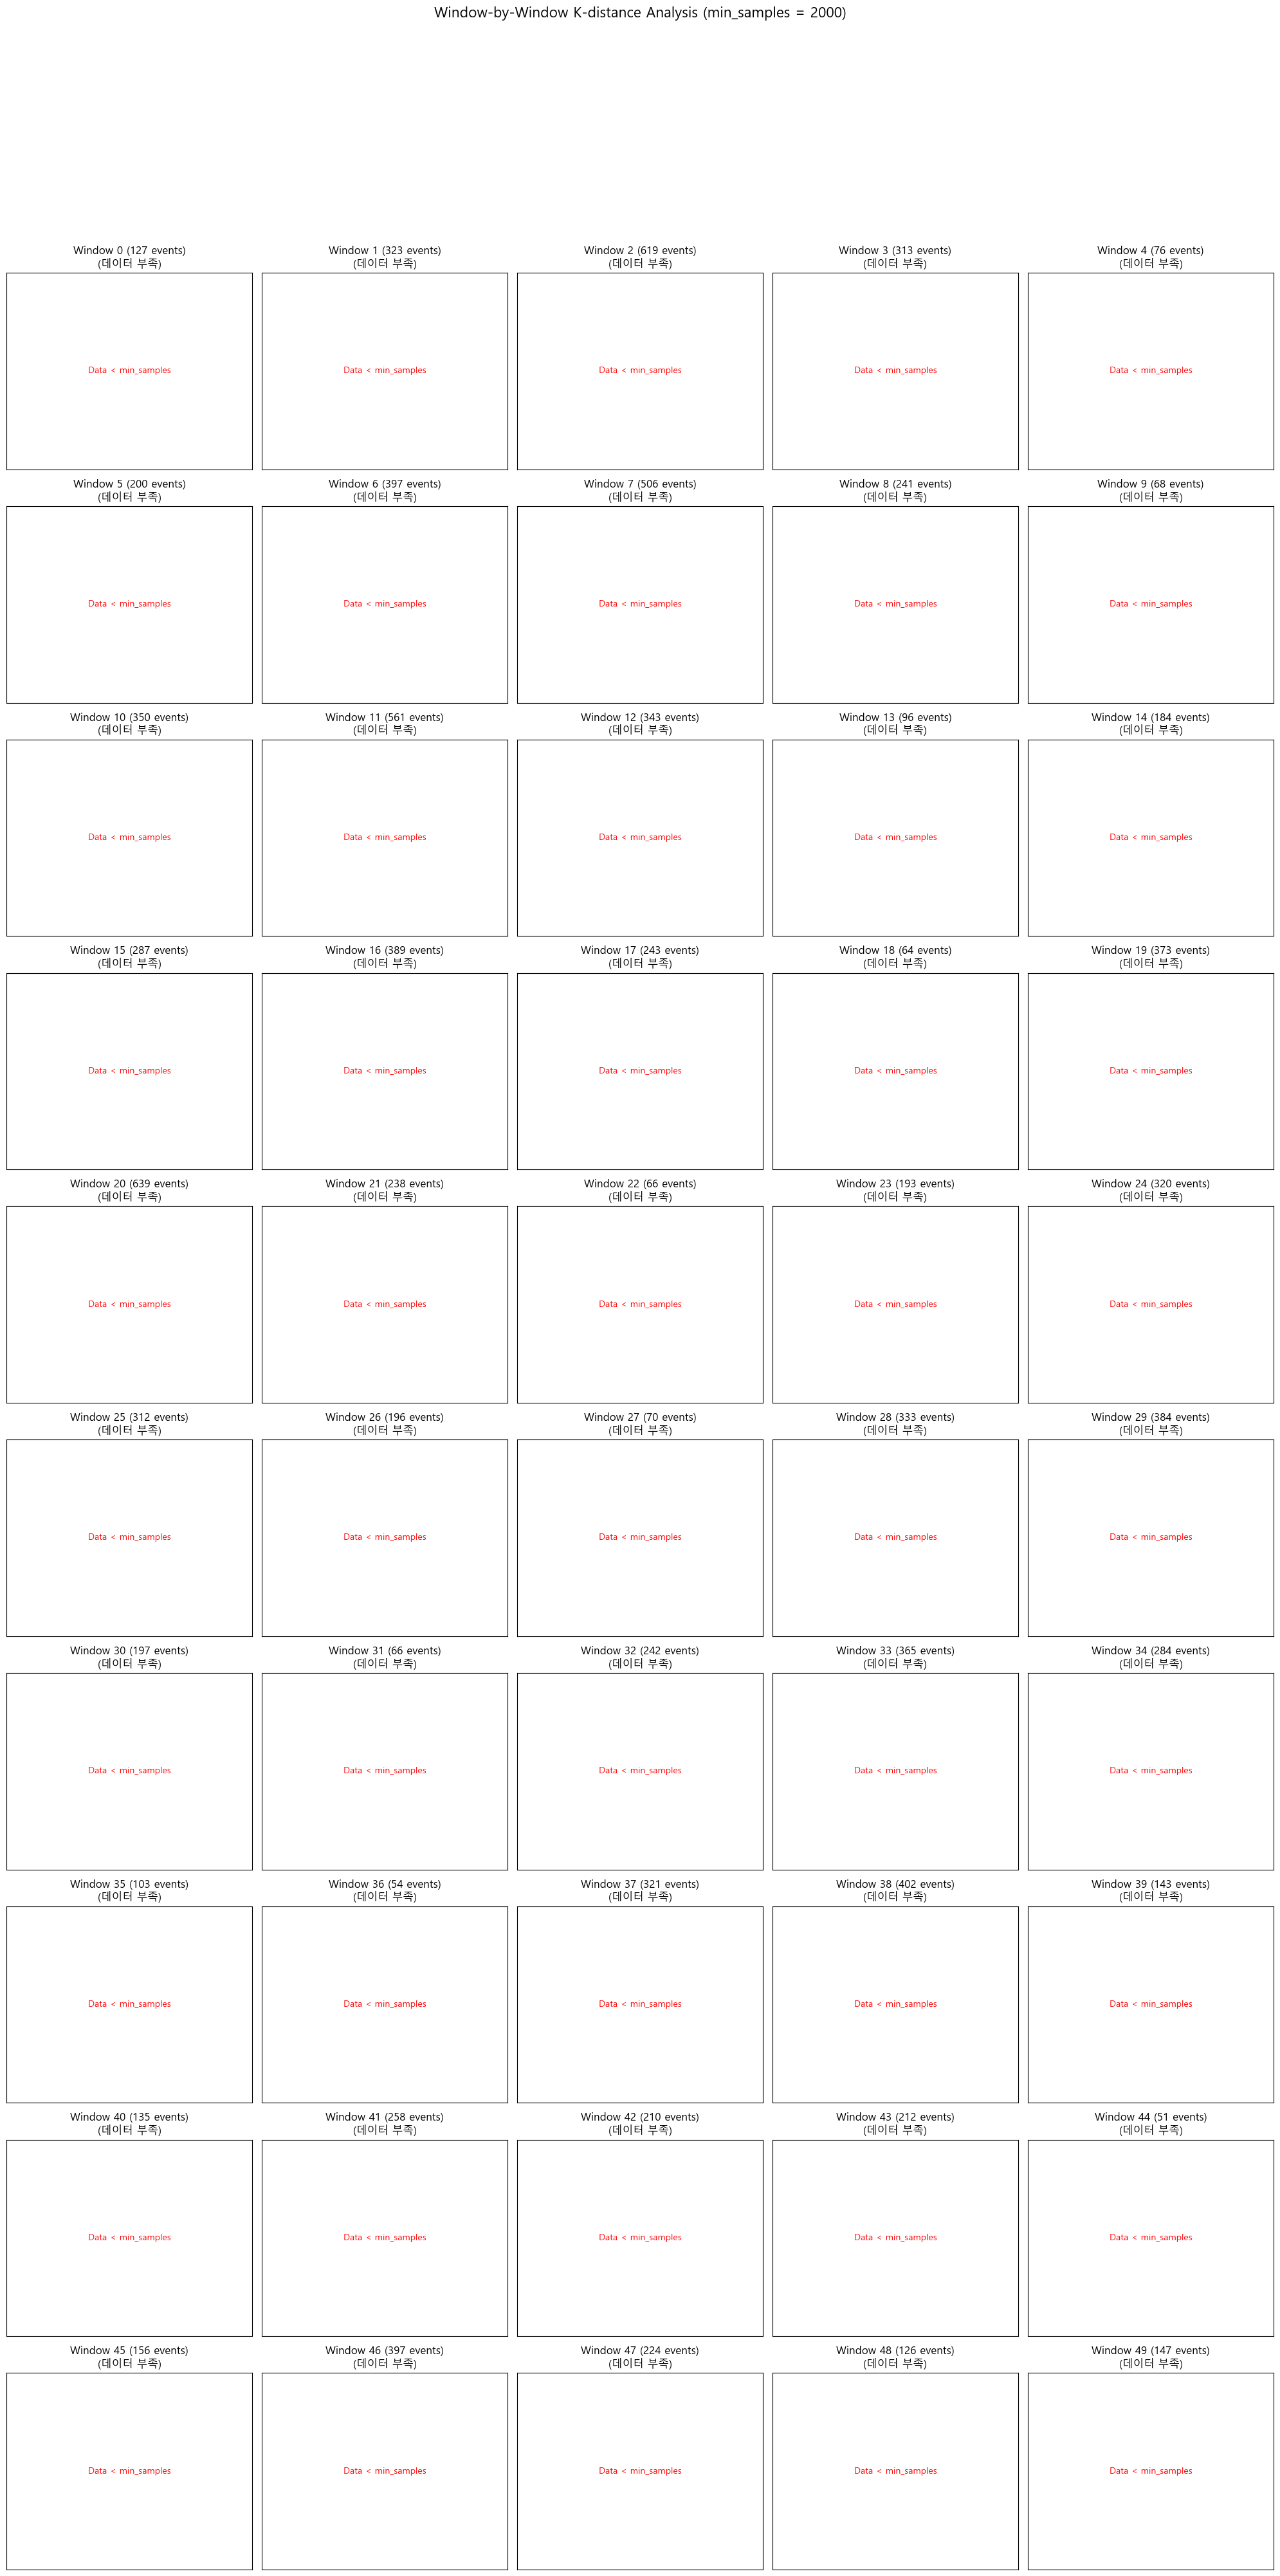


분석 대상: [1] Right Hand Wave
  - 총 50개의 윈도우에 대해 그래프를 생성합니다.


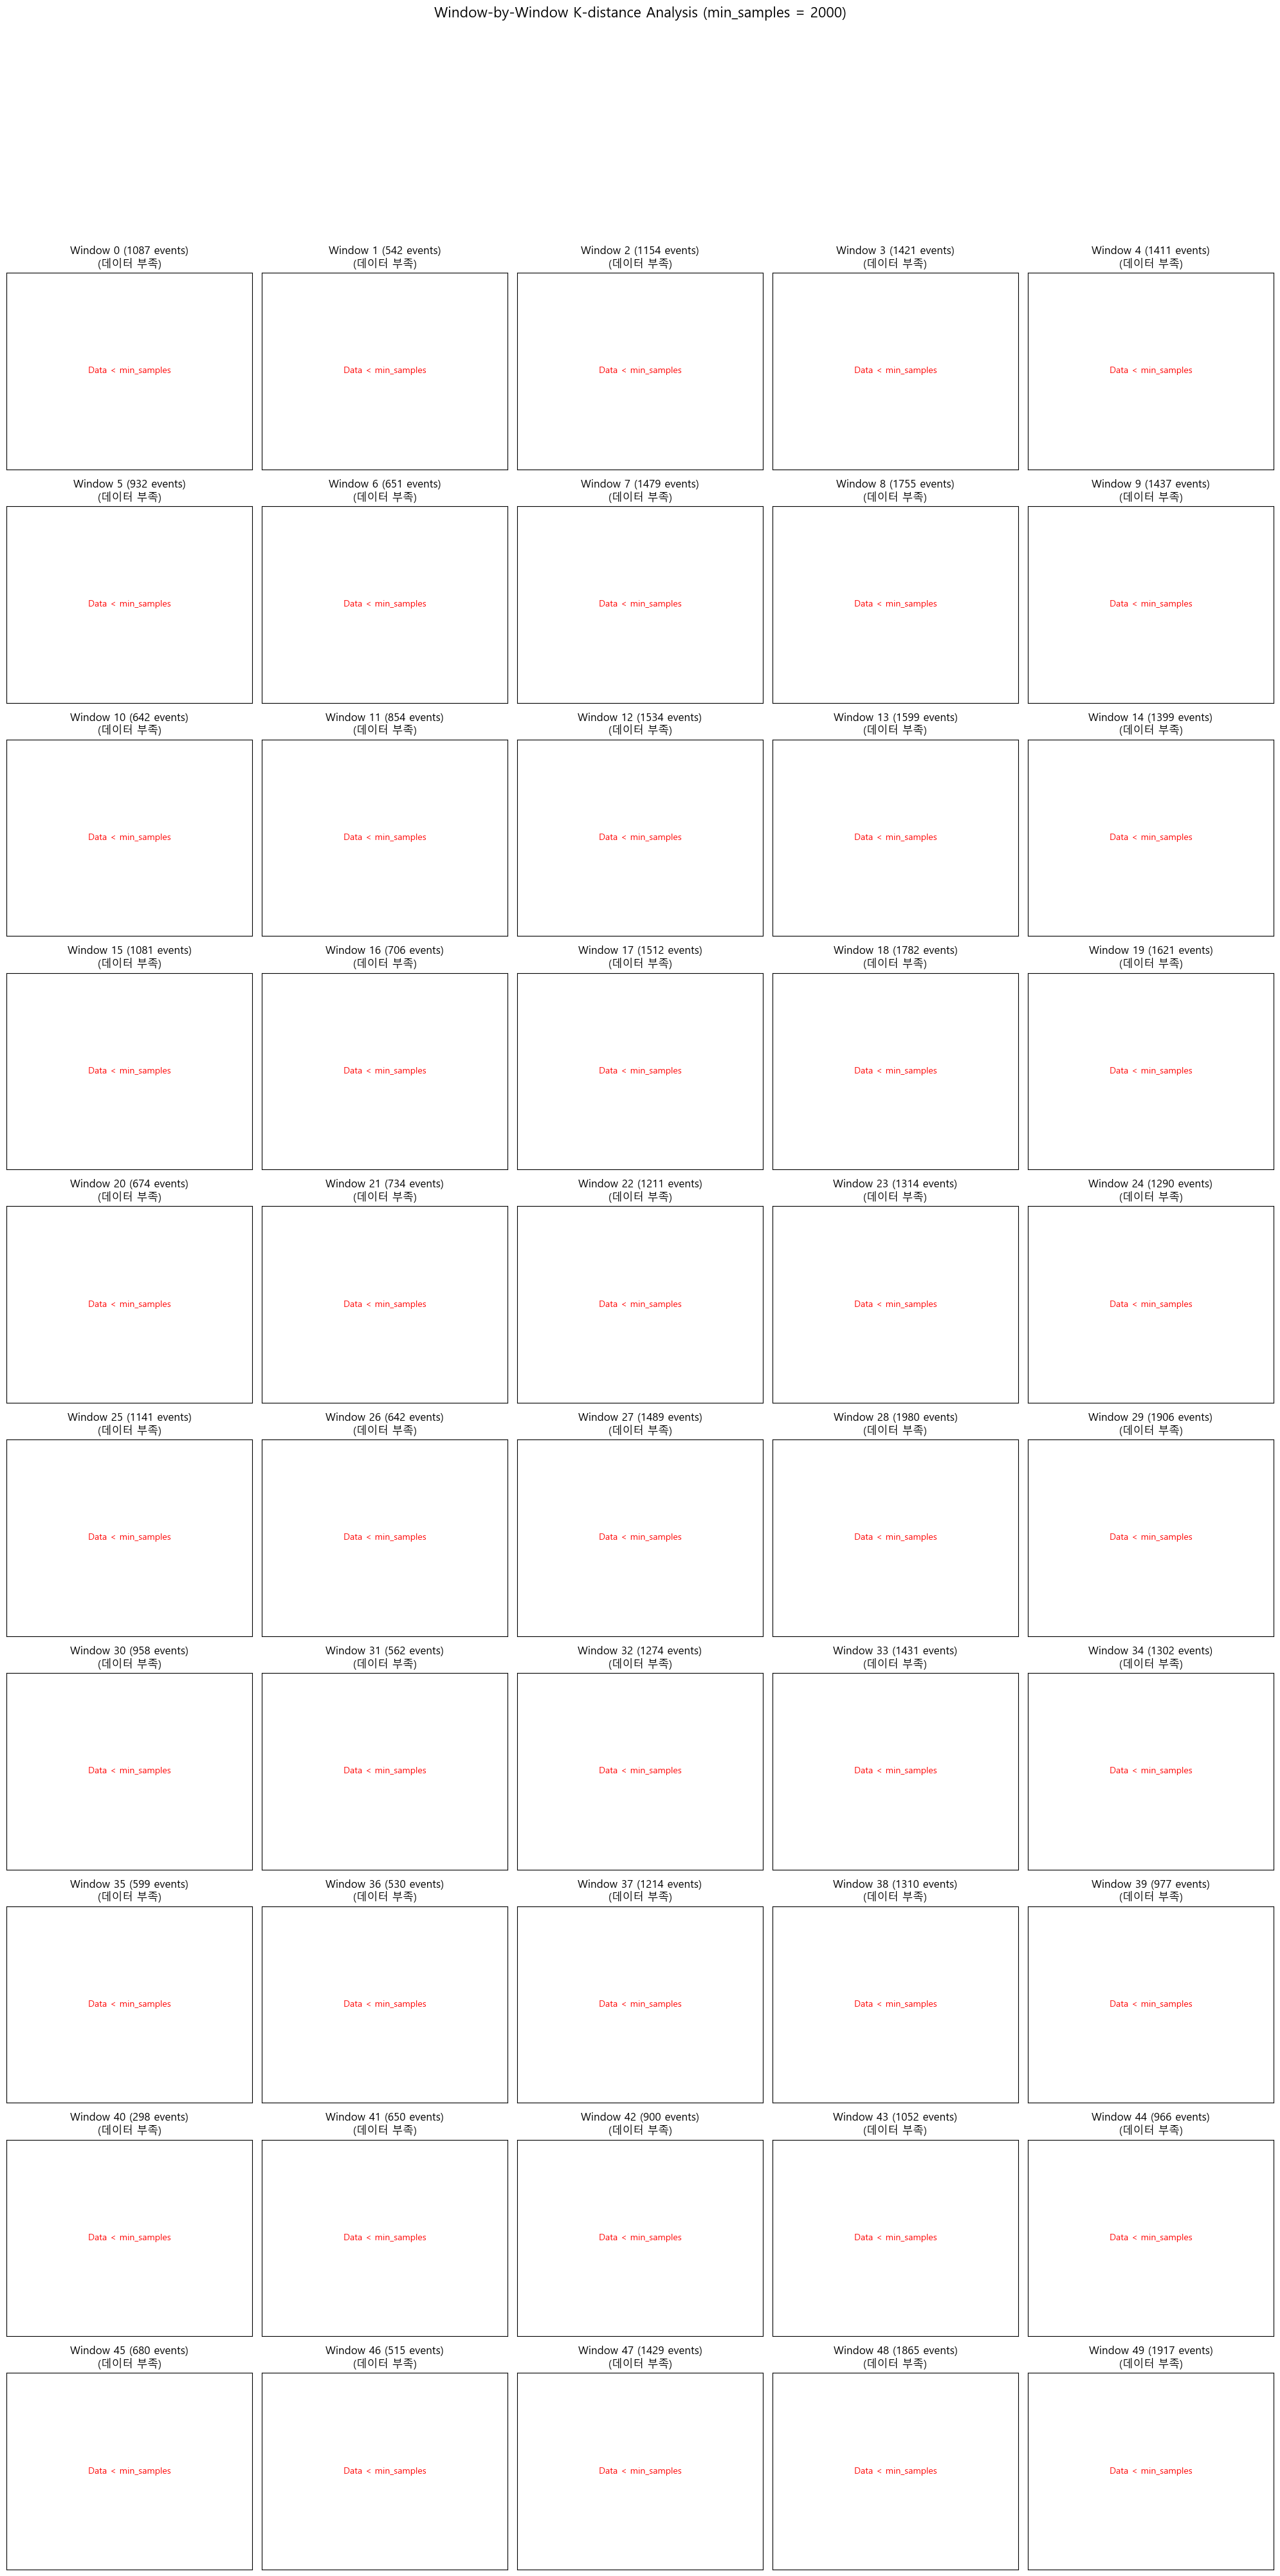


분석 대상: [2] Left Hand Wave
  - 총 50개의 윈도우에 대해 그래프를 생성합니다.


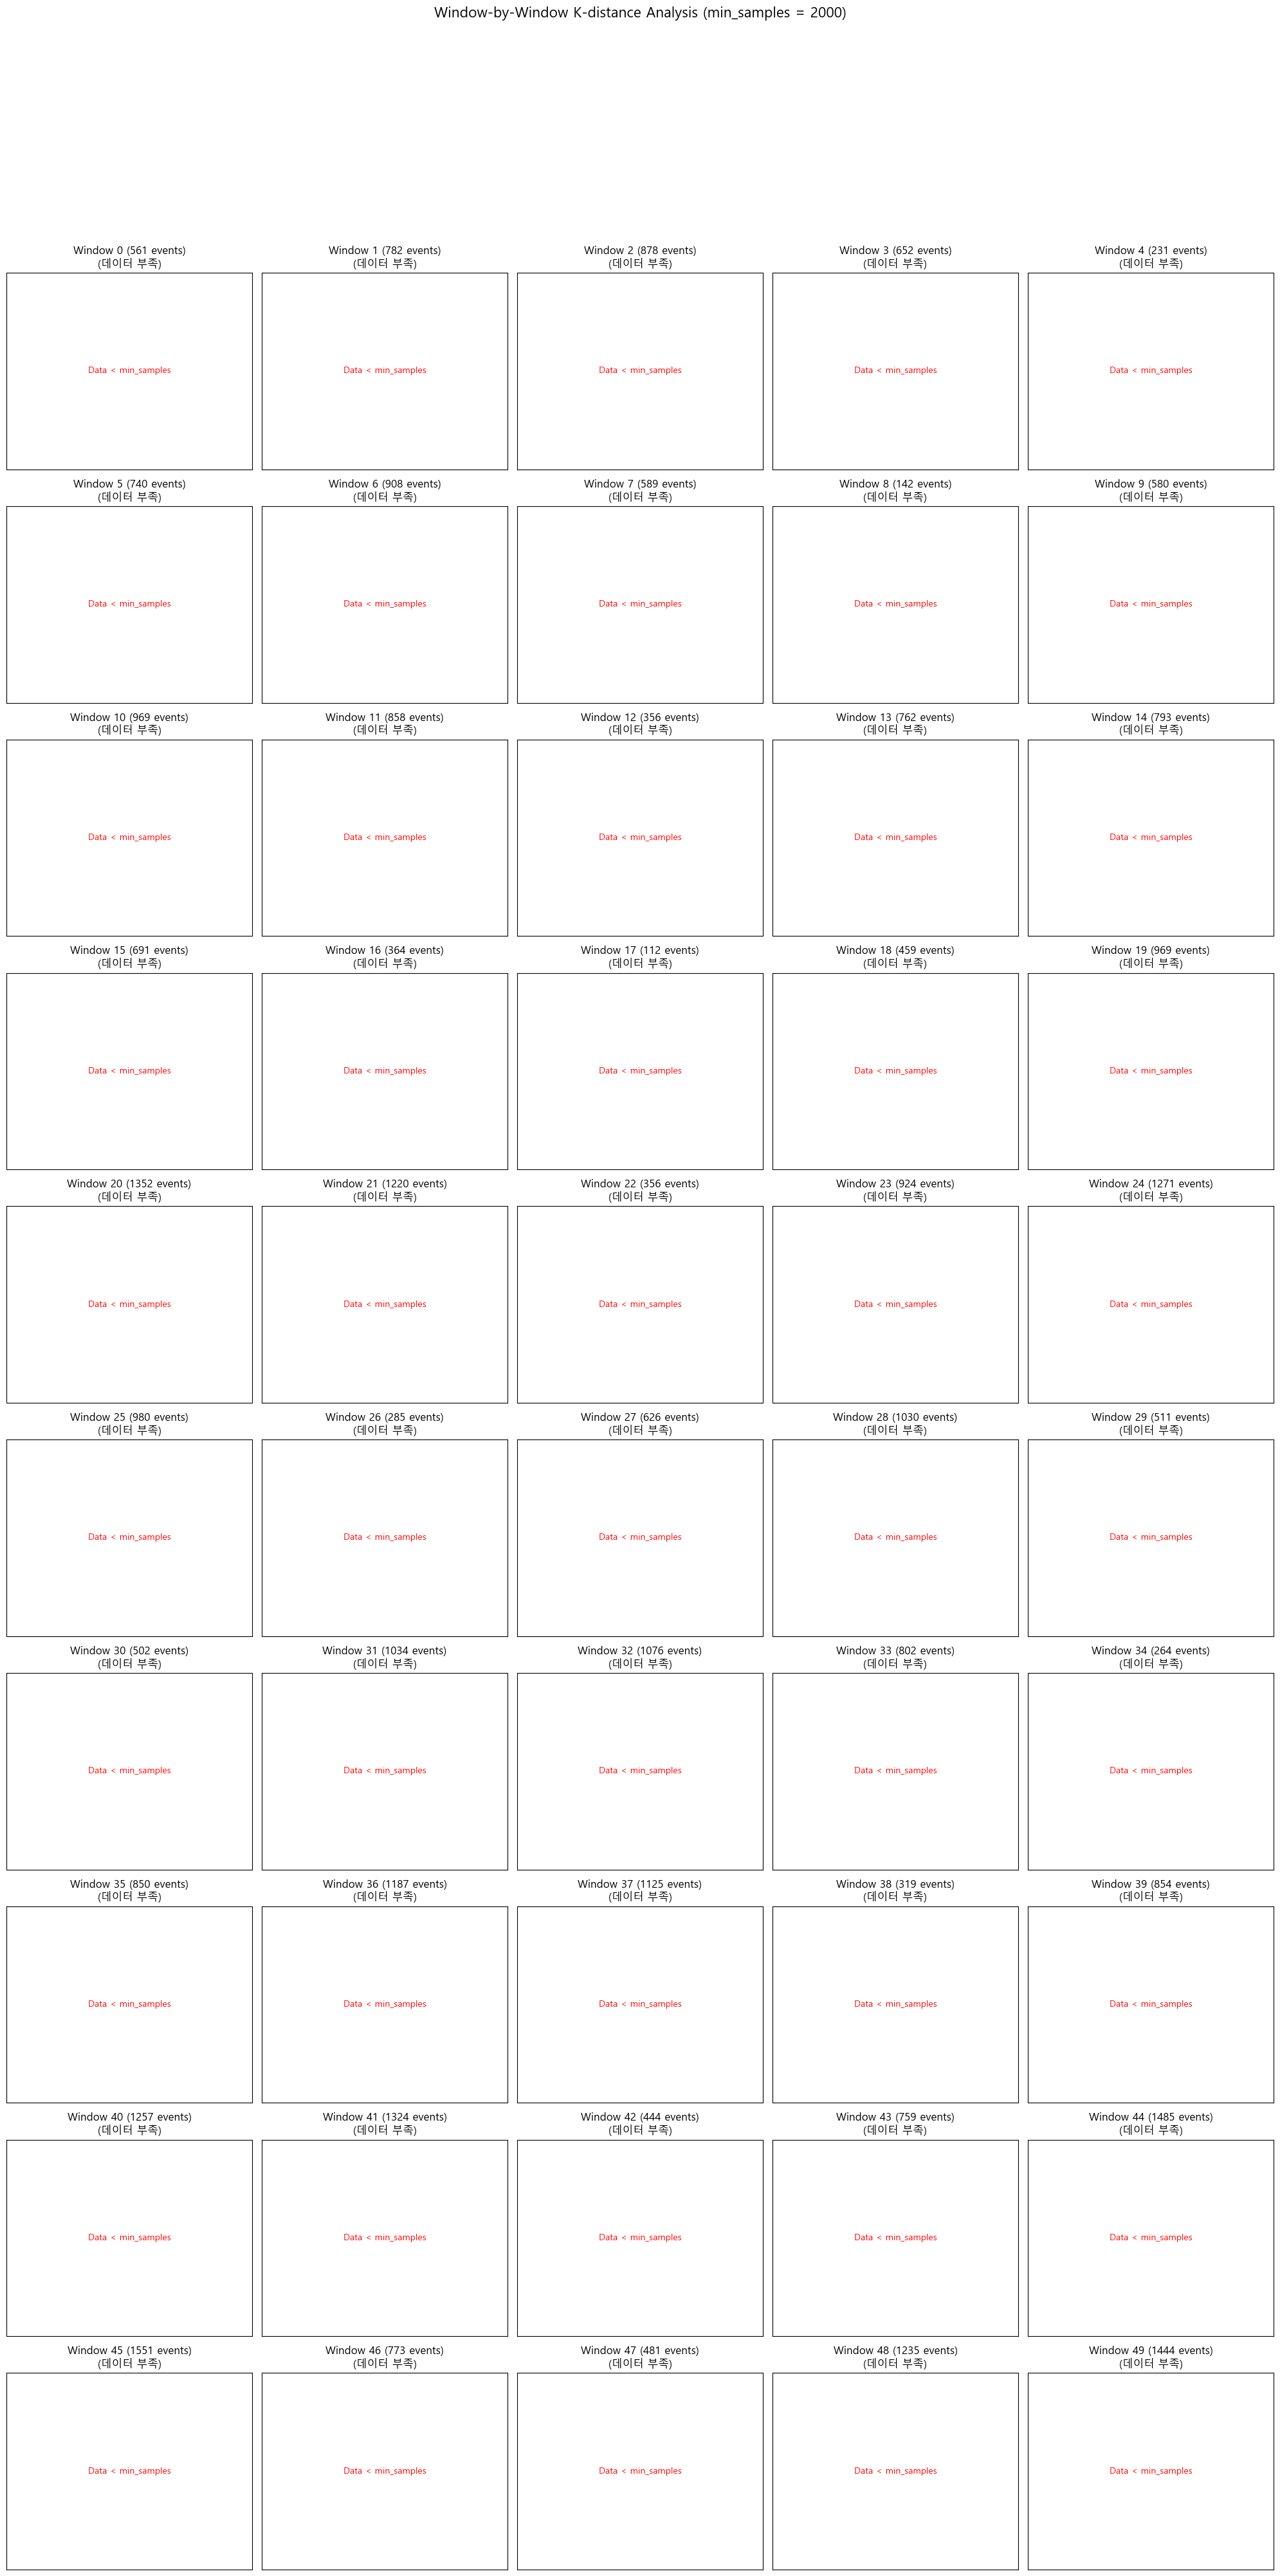


분석 대상: [3] Right Arm Cw
  - 총 50개의 윈도우에 대해 그래프를 생성합니다.


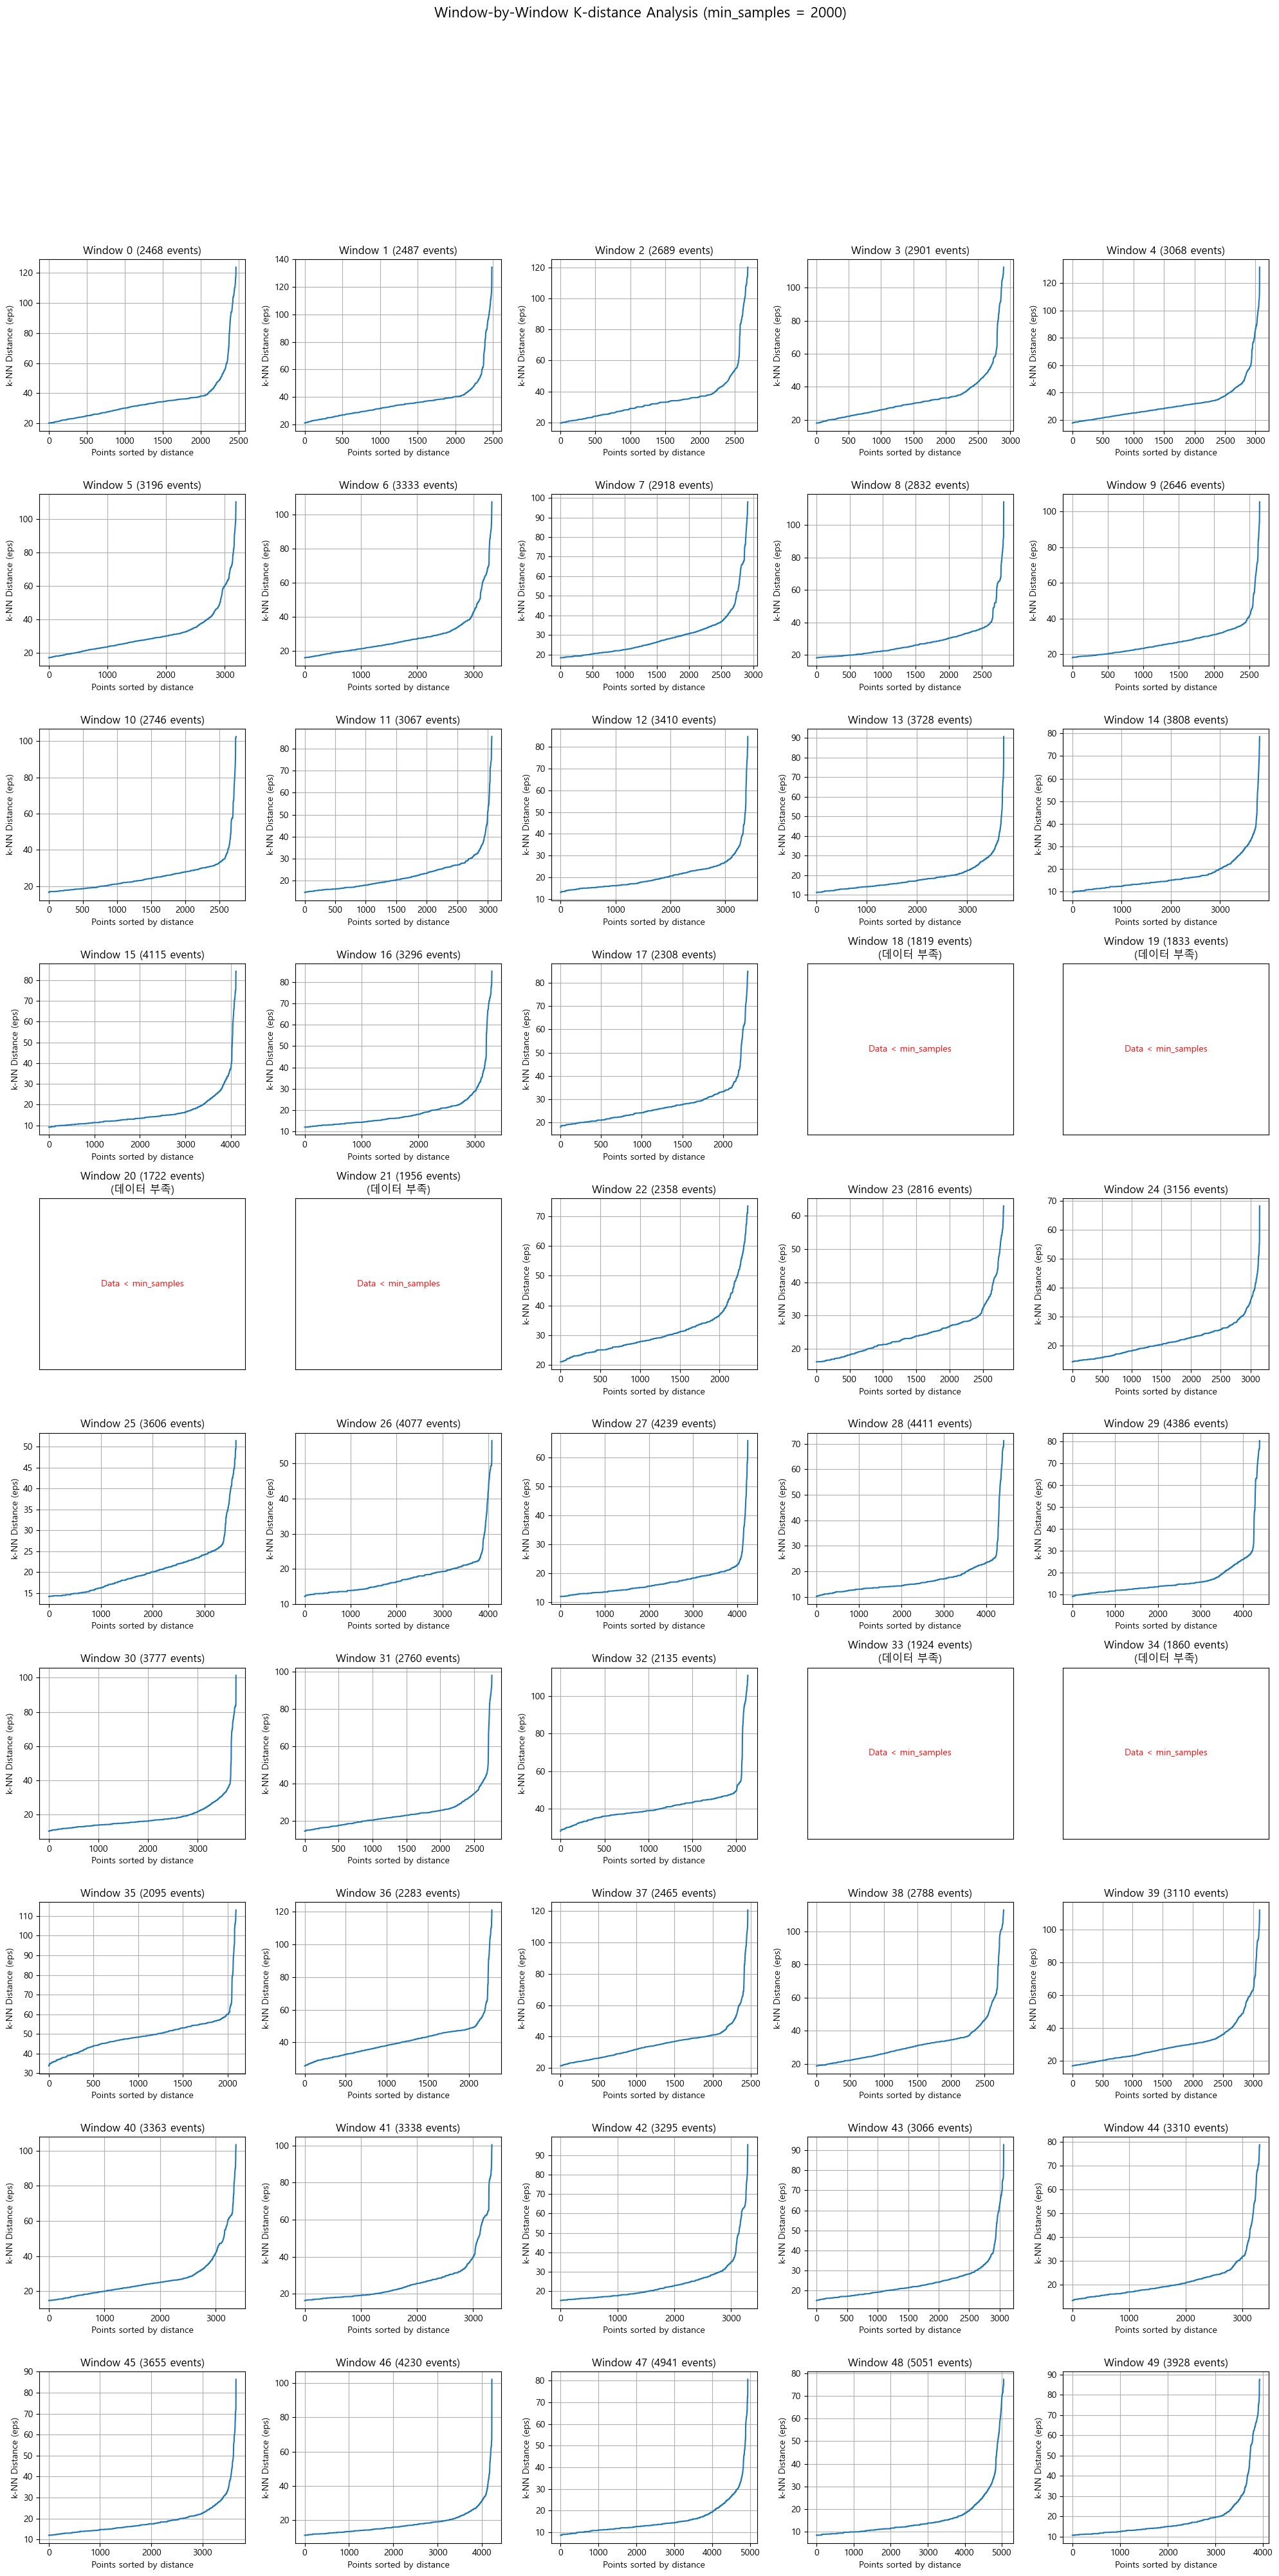


분석 대상: [4] Right Arm Ccw
  - 총 50개의 윈도우에 대해 그래프를 생성합니다.


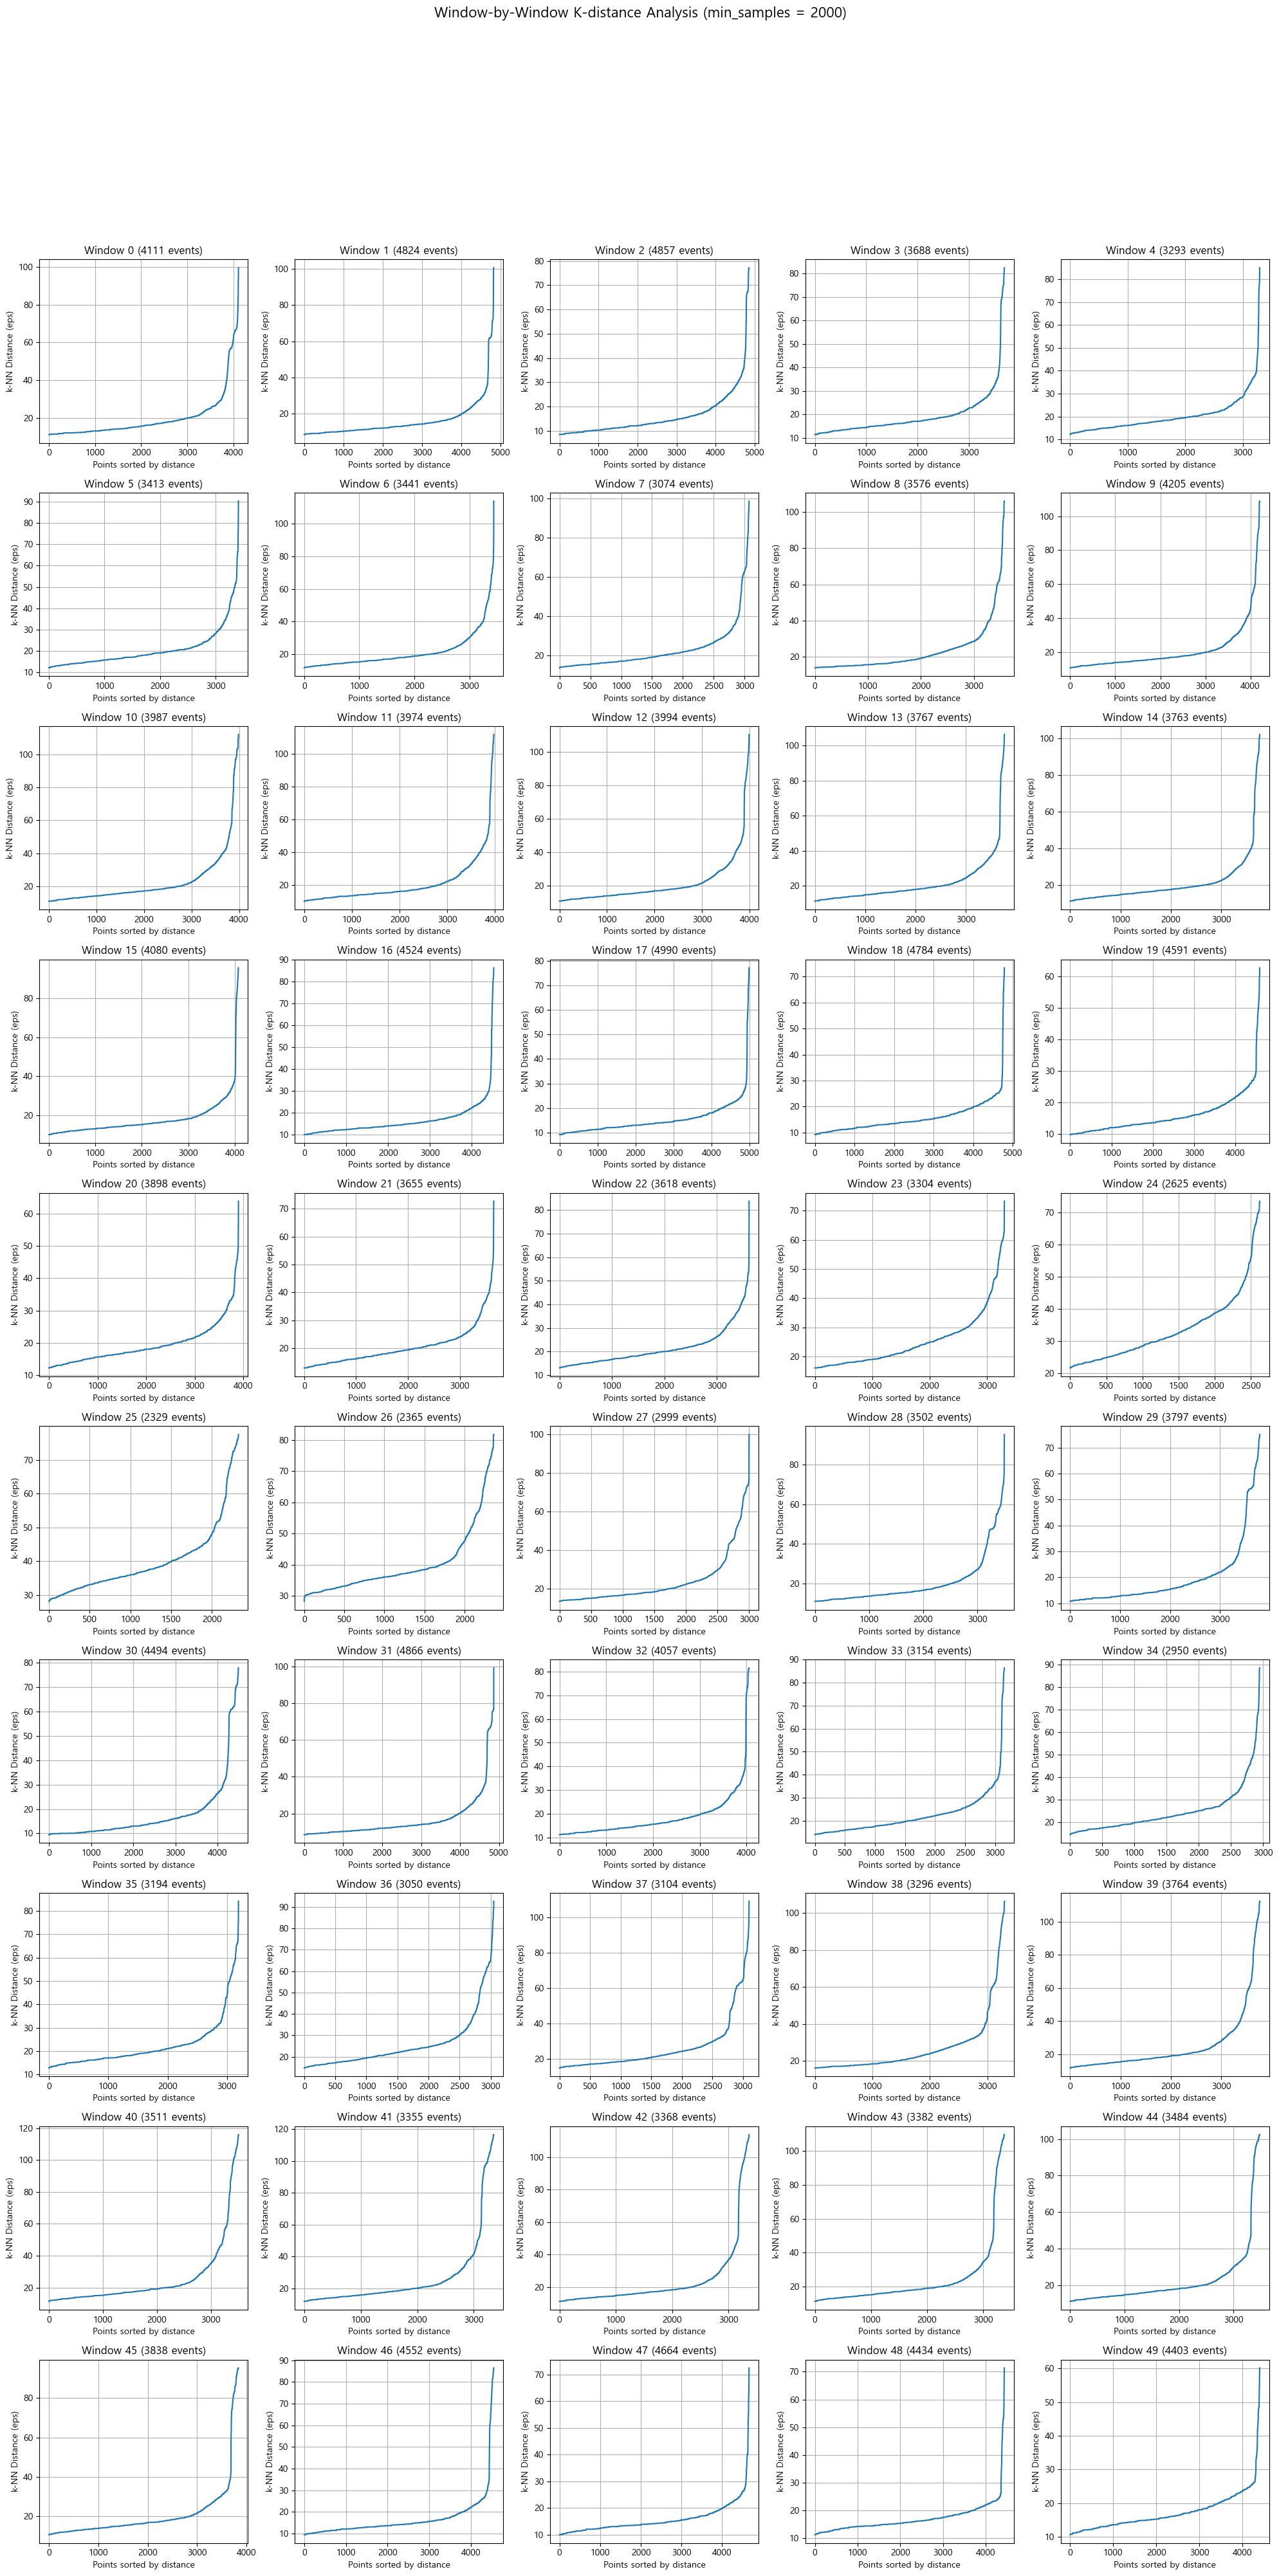


분석 대상: [5] Left Hand Cw
  - 총 50개의 윈도우에 대해 그래프를 생성합니다.


KeyboardInterrupt: 

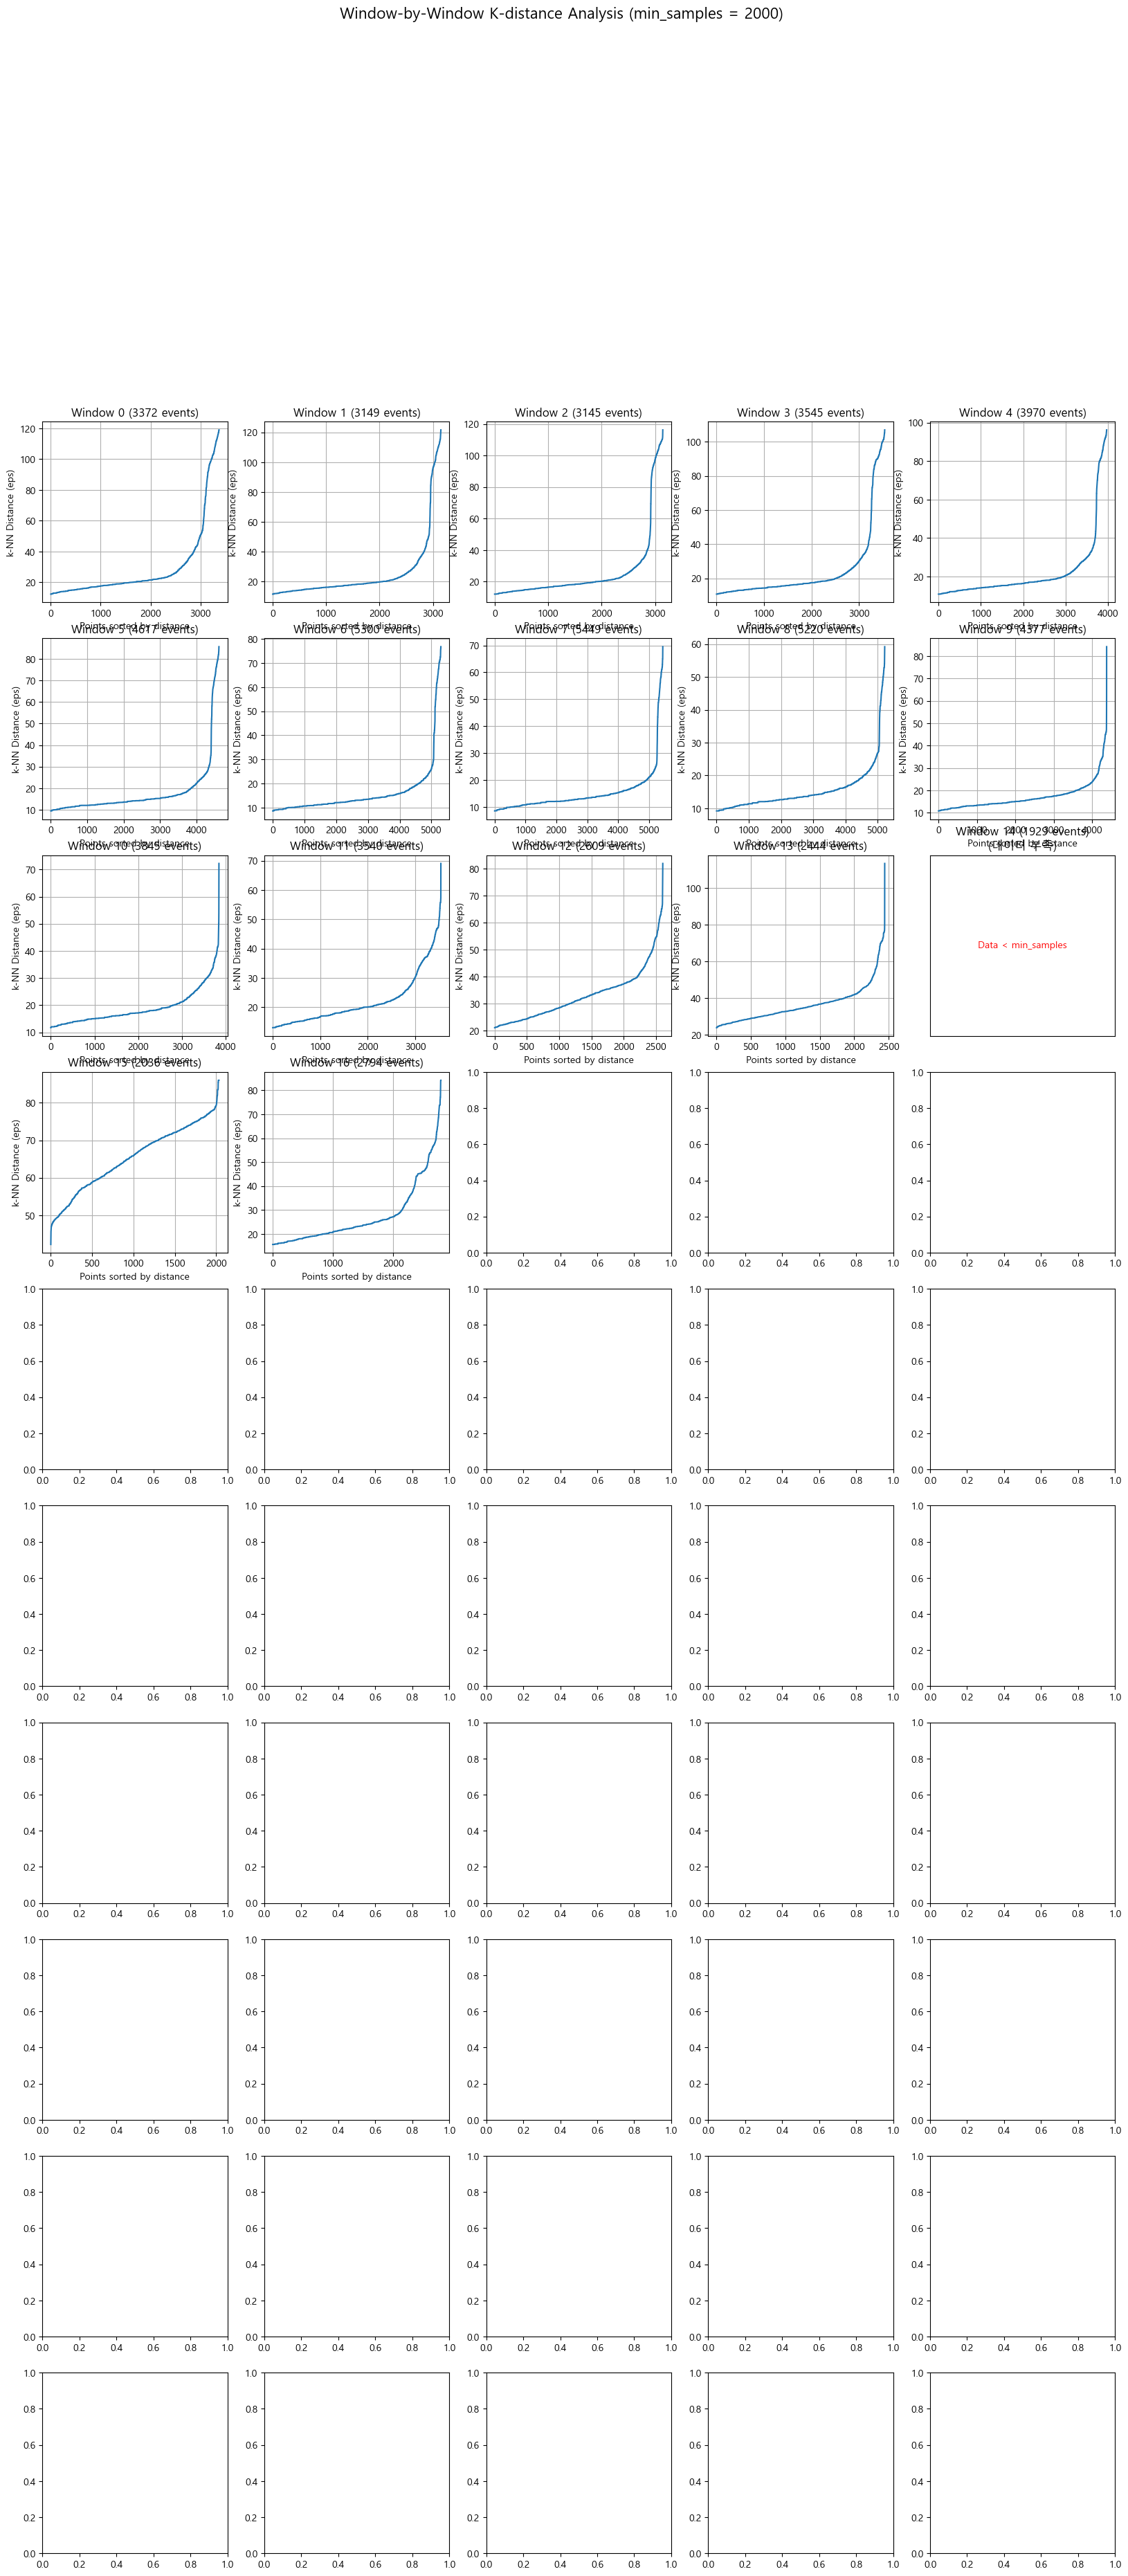

In [58]:
# k-distance 그래프 그리기

import numpy as np
import os
import pickle
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import slayerSNN as snn
import math

import platform
if platform.system() == 'Windows':
    plt.rc('font', family='Malgun Gothic')
elif platform.system() == 'Darwin':
    plt.rc('font', family='AppleGothic')
else:
    plt.rc('font', family='NanumGothic')
plt.rc('axes', unicode_minus=False)


# 원본 1450ms 데이터 가져오기
def get_event_data_for_label(dataset, target_label):
    found_index = -1
    for i, sample_info in enumerate(dataset.samples):
        if sample_info[1] == target_label:
            found_index = sample_info[0]
            break
    if found_index == -1: return None
    file_path = dataset.path + str(found_index.item()) + '.npy'
    try:
        event_data = np.load(file_path, allow_pickle=True)
        if event_data.ndim == 2 and event_data.shape[1] == 4:
            return event_data[event_data[:, 3] < 1450] 
    except (pickle.UnpicklingError, EOFError, ValueError):
        return None
    return None

# 윈도우별 K-distance 그래프 그리기
def visualize_window_by_window_k_distance(event_data, min_samples_options, 
                                          total_time_ms=1450, window_size_ms=29, stride_ms=29):
    if event_data is None or event_data.shape[0] < 1:
        print("  - 데이터가 없어 그래프를 그릴 수 없습니다.")
        return

    windows = []
    
    for t_start in range(0, total_time_ms, stride_ms):
        t_end = t_start + window_size_ms
        # t가 3번 열(x,y,p,t 순서)이라고 가정
        time_mask = (event_data[:, 3] >= t_start) & (event_data[:, 3] < t_end) 
        windows.append(event_data[time_mask])
    
    num_windows = len(windows)
    
    print(f"  - 총 {num_windows}개의 윈도우에 대해 그래프를 생성합니다.")

    # 각 min_samples 값에 대해 별도의 Figure를 생성
    for min_samples in min_samples_options:
        
        # 10개 윈도우를 2x5 그리드로 그리기
        fig, axes = plt.subplots(math.ceil(num_windows / 5), 5, 
                                 figsize=(20, 4 * math.ceil(num_windows / 5)))
        axes = axes.flatten() # 2D 배열을 1D로 폅니다.
        fig.suptitle(f"Window-by-Window K-distance Analysis (min_samples = {min_samples})", 
                     fontsize=16, y=1.03)

        # 각 윈도우(서브플롯)를 순회하며 K-distance 그래프 그리기
        for i, window_events in enumerate(windows):
            ax = axes[i]
            points = window_events[:, :2]
            event_count = points.shape[0]

            if event_count < min_samples:
                ax.set_title(f"Window {i} ({event_count} events)\n(데이터 부족)")
                ax.text(0.5, 0.5, 'Data < min_samples', 
                        ha='center', va='center', transform=ax.transAxes, color='red')
                ax.set_xticks([])
                ax.set_yticks([])
                continue

            neighbors = NearestNeighbors(n_neighbors=min_samples)
            neighbors_fit = neighbors.fit(points)
            distances, _ = neighbors_fit.kneighbors(points)
            k_distances = np.sort(distances[:, min_samples-1])
            
            ax.plot(k_distances)
            ax.set_title(f"Window {i} ({event_count} events)")
            ax.set_xlabel("Points sorted by distance")
            ax.set_ylabel("k-NN Distance (eps)")
            ax.grid(True)
        
        # 남는 서브플롯이 있다면 비워둠
        for i in range(num_windows, len(axes)):
            axes[i].axis('off')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

# 메인 분석 로직
gesture_map = {
    0: 'Hand Clap', 1: 'Right Hand Wave', 2: 'Left Hand Wave',
    3: 'Right Arm Cw', 4: 'Right Arm Ccw', 5: 'Left Hand Cw',
    6: 'Left Hand Ccw', 7: 'Arm Roll', 8: 'Air Drums',
    9: 'Air Guitar', 10: 'Flick'
}
MIN_SAMPLES_OPTIONS = [2000]

print("--- 각 제스처별 '윈도우 단위' 최적 DBSCAN 파라미터 분석 시작 ---")
try:
    for label_id, gesture_name in gesture_map.items():
        print("\n" + "="*60)
        print(f"분석 대상: [{label_id}] {gesture_name}")
        
        full_event_data = get_event_data_for_label(testingSet, label_id)
        
        visualize_window_by_window_k_distance(full_event_data, 
                                              MIN_SAMPLES_OPTIONS,
                                              window_size_ms=29, # 윈도우 크기
                                              stride_ms=29)      # 겹치지 않게 설정

except NameError:
    print("\n오류: 'trainingSet' 변수를 찾을 수 없습니다.")
    print("이 코드를 실행하기 전에 'trainingSet = IBMGestureDataset(...)' 코드가 있는 셀을 먼저 실행해주세요.")

In [6]:
# train data 윈도우 나눠서 클러스터링 / 밀도 통계 저장

import numpy as np
from sklearn.cluster import DBSCAN
import os
import pickle
from tqdm import tqdm
import shutil
import math
import pandas as pd

# DBSCAN 함수
def apply_dbscan_and_get_densities(events, eps=5, min_samples=100):
    if events.shape[0] < min_samples:
        return np.empty((0, 4)), [] 

    db = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1).fit(events[:, :2])
    labels = db.labels_

    non_noise_mask = (labels != -1)
    denoised_events = events[non_noise_mask]
    
    unique_labels = np.unique(labels[non_noise_mask])
    densities = [] 

    for label in unique_labels:
        cluster_mask = (labels == label)
        current_cluster = events[cluster_mask]
        num_events = len(current_cluster) # (A) 총 이벤트 수

        if num_events > 0:
            # '고유 픽셀 수'로 면적 계산
            locations = current_cluster[:, :2] # (x, y) 좌표만 추출
            # Pandas DataFrame의 drop_duplicates()로 고유한 (x,y) 행의 개수를 셉니다.
            area = pd.DataFrame(locations).drop_duplicates().shape[0] # (B) 고유 픽셀 수
            
            density = num_events / area if area > 0 else float('inf')
            densities.append(density)

    return denoised_events, densities

# 시간 창 분할 함수
def process_windows(event_data, total_time_ms=1450, window_size_ms=145, stride_ms=145):
    all_clustered_events = []
    
    n_windows = math.ceil(total_time_ms / stride_ms)
    window_densities_dict = {i: [] for i in range(n_windows)} 

    for i, t_start in enumerate(range(0, total_time_ms, stride_ms)):
        t_end = t_start + window_size_ms
        
        time_mask = (event_data[:, 3] >= t_start) & (event_data[:, 3] < t_end) 
        window_events = event_data[time_mask]
        
        if window_events.shape[0] > 0:
            clustered_events, densities = apply_dbscan_and_get_densities(window_events, eps=5, min_samples=100)
            
            if clustered_events.shape[0] > 0:
                all_clustered_events.append(clustered_events)
            if densities:
                window_densities_dict[i].extend(densities)

    final_events = np.concatenate(all_clustered_events, axis=0) if all_clustered_events else np.empty((0, 4))
    final_densities = window_densities_dict
    
    return final_events, final_densities

# 메인 전처리 로직

input_folder = 'Train/'
output_folder = 'train_cluster_window50_5_50/'
sample_list_file = os.path.join(input_folder, 'train.txt')

OUTPUT_PKL_FILENAME = 'train_cluster_window50_5_500_stats.pkl'

TOTAL_TIME_MS = 1450
WINDOW_SIZE_MS = 145
STRIDE_MS = 145
N_WINDOWS = math.ceil(TOTAL_TIME_MS / STRIDE_MS)

if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    print(f"'{output_folder}' 폴더를 생성했습니다.")

all_label_window_densities = {
    label: {win_idx: [] for win_idx in range(N_WINDOWS)} for label in range(11)
}

try:
    label_map = {int(index): int(label) for index, label in np.loadtxt(sample_list_file)}
    existing_indices = {int(f.split('.')[0]) for f in os.listdir(input_folder) if f.endswith('.npy')}
    samples_to_process = [[idx, label_map[idx]] for idx in sorted(list(existing_indices)) if idx in label_map]
    output_list_file = os.path.join(output_folder, 'train.txt')
    np.savetxt(output_list_file, samples_to_process, fmt='%d')
    print(f"실제로 '{input_folder}' 폴더에 존재하는 {len(samples_to_process)}개의 파일만 처리합니다.")
except (FileNotFoundError, ValueError):
    print(f"오류: '{sample_list_file}' 또는 '{input_folder}' 경로를 확인해주세요.")
    samples_to_process = [] 

for sample_info in tqdm(samples_to_process, desc="클러스터링 및 통계 계산 진행률"):
    file_index = sample_info[0]
    label = sample_info[1] 
    input_file_path = os.path.join(input_folder, f'{file_index}.npy')
    output_file_path = os.path.join(output_folder, f'{file_index}.npy')

    try:
        event_data = np.load(input_file_path, allow_pickle=True)
        if not (event_data.ndim == 2 and event_data.shape[1] == 4):
            event_data = np.empty((0, 4))
    except (pickle.UnpicklingError, EOFError, ValueError):
        tqdm.write(f"\n경고: '{input_file_path}' 파일이 손상되어 건너뜁니다.")
        event_data = np.empty((0, 4))

    if event_data.shape[0] > 0:
        filtered_events = event_data[event_data[:, 3] < TOTAL_TIME_MS]
    else:
        filtered_events = np.empty((0, 4))

    if filtered_events.shape[0] > 0:
        denoised_events, window_densities = process_windows(
            filtered_events,
            total_time_ms=TOTAL_TIME_MS,
            window_size_ms=WINDOW_SIZE_MS,
            stride_ms=STRIDE_MS
        )
        
        for window_idx, densities in window_densities.items():
            if densities:
                all_label_window_densities[label][window_idx].extend(densities)
            
    else:
        denoised_events = np.empty((0, 4))

    np.save(output_file_path, denoised_events)

print(f"\n모든 파일 처리가 완료되었습니다. '{output_folder}'에 .npy 파일 저장 완료.")

# 최종 통계 계산 및 .pkl 파일 저장
print(f"\n이제 '{OUTPUT_PKL_FILENAME}' 파일에 최종 통계를 저장합니다...")

final_stats_summary = {label: {} for label in range(11)}
gesture_map = {
    0: 'Hand Clap', 1: 'Right Hand Wave', 2: 'Left Hand Wave',
    3: 'Right Arm Cw', 4: 'Right Arm Ccw', 5: 'Left Arm Cw',
    6: 'Left Arm Ccw', 7: 'Arm Roll', 8: 'Air Drums',
    9: 'Air Guitar', 10: 'Flick'
}

for label_id, window_data in all_label_window_densities.items():
    print(f"\n--- 통계 계산 중: 레이블 {label_id} ({gesture_map.get(label_id, '?')}) ---")
    for window_idx, densities in window_data.items():
        if densities: 
            densities_arr = np.array(densities)
            stats_dict = {
                '총 클러스터 수': len(densities_arr),
                '평균 밀도': np.mean(densities_arr),
                '표준 편차': np.std(densities_arr),
                '최소 밀도': np.min(densities_arr),
                '최대 밀도': np.max(densities_arr),
                '99% 백분위수': np.percentile(densities_arr, 99)
            }
        else: 
            stats_dict = {
                '총 클러스터 수': 0, '평균 밀도': 0, '표준 편차': 0,
                '최소 밀도': 0, '최대 밀도': 0, '99% 백분위수': 0
            }
        
        final_stats_summary[label_id][window_idx] = stats_dict

try:
    with open(OUTPUT_PKL_FILENAME, 'wb') as f:
        pickle.dump(final_stats_summary, f)
    print(f"\n[✅] 최종 통계 정보가 '{OUTPUT_PKL_FILENAME}' 파일로 저장되었습니다.")
except Exception as e:
    print(f"\n[❌] 파일 저장 중 오류 발생: {e}")

'train_cluster_window10_5_100_ver2/' 폴더를 생성했습니다.
실제로 'Train/' 폴더에 존재하는 1077개의 파일만 처리합니다.


클러스터링 및 통계 계산 진행률: 100%|██████████████████████████████████████████████| 1077/1077 [28:24<00:00,  1.58s/it]


모든 파일 처리가 완료되었습니다. 'train_cluster_window10_5_100_ver2/'에 .npy 파일 저장 완료.

이제 'train_cluster_window10_5_100_ver2_stats.pkl' 파일에 최종 통계를 저장합니다...

--- 통계 계산 중: 레이블 0 (Hand Clap) ---

--- 통계 계산 중: 레이블 1 (Right Hand Wave) ---

--- 통계 계산 중: 레이블 2 (Left Hand Wave) ---

--- 통계 계산 중: 레이블 3 (Right Arm Cw) ---

--- 통계 계산 중: 레이블 4 (Right Arm Ccw) ---

--- 통계 계산 중: 레이블 5 (Left Arm Cw) ---

--- 통계 계산 중: 레이블 6 (Left Arm Ccw) ---

--- 통계 계산 중: 레이블 7 (Arm Roll) ---

--- 통계 계산 중: 레이블 8 (Air Drums) ---

--- 통계 계산 중: 레이블 9 (Air Guitar) ---

--- 통계 계산 중: 레이블 10 (Flick) ---

[✅] 최종 통계 정보가 'train_cluster_window10_5_100_ver2_stats.pkl' 파일로 저장되었습니다.


In [12]:
# train data 밀도 통계 출력 함수

import pickle
import numpy as np
import os

def load_and_print_stats(pkl_filename):
    
    # 제스처 이름 매핑 (출력용)
    gesture_map = {
        0: 'Hand Clap', 1: 'Right Hand Wave', 2: 'Left Hand Wave',
        3: 'Right Arm Cw', 4: 'Right Arm Ccw', 5: 'Left Hand Cw',
        6: 'Left Arm Ccw', 7: 'Arm Roll', 8: 'Air Drums',
        9: 'Air Guitar', 10: 'Flick'
    }

    # .pkl 파일 로드
    try:
        with open(pkl_filename, 'rb') as f:
            stats_summary = pickle.load(f)
        print(f"--- '{pkl_filename}' 파일에서 통계 정보를 불러왔습니다 ---")
    except FileNotFoundError:
        print(f"오류: '{pkl_filename}' 파일을 찾을 수 없습니다.")
        print("먼저 전처리 코드를 실행하여 통계 파일을 생성해주세요.")
        return
    except Exception as e:
        print(f"파일 로드 중 오류 발생: {e}")
        return

    # 딕셔너리를 순회하며 결과 출력
    for label_id, window_data in stats_summary.items():
        gesture_name = gesture_map.get(label_id, 'Unknown')
        print("\n" + "=" * 60)
        print(f"레이블 {label_id}: {gesture_name}")
        print("=" * 60)
        
        # 윈도우 인덱스(0, 1, 2...) 순서대로 정렬하여 출력
        for window_idx in sorted(window_data.keys()):
            stats = window_data[window_idx]
            
            print(f"  --- 윈도우 {window_idx} ---")
            
            # 클러스터가 하나라도 있는지 확인
            if stats['총 클러스터 수'] > 0:
                print(f"    - 총 클러스터 수: {stats['총 클러스터 수']}")
                print(f"    - 평균 밀도:     {stats['평균 밀도']:.4f}")
                print(f"    - 표준 편차:     {stats['표준 편차']:.4f}")
                print(f"    - 최소 밀도:     {stats['최소 밀도']:.4f}")
                print(f"    - 최대 밀도:     {stats['최대 밀도']:.4f}")
                print(f"    - 99% 백분위수:  {stats['99% 백분위수']:.4f}")
            else:
                print("    - (클러스터 없음)")

FILENAME_TO_LOAD = 'train_cluster_window10_5_100_ver2_stats.pkl'

load_and_print_stats(FILENAME_TO_LOAD)

--- 'train_cluster_window10_5_100_ver2_stats.pkl' 파일에서 통계 정보를 불러왔습니다 ---

레이블 0: Hand Clap
  --- 윈도우 0 ---
    - 총 클러스터 수: 136
    - 평균 밀도:     4.3925
    - 표준 편차:     2.7330
    - 최소 밀도:     1.4217
    - 최대 밀도:     25.5000
    - 99% 백분위수:  16.7545
  --- 윈도우 1 ---
    - 총 클러스터 수: 140
    - 평균 밀도:     4.2237
    - 표준 편차:     1.4518
    - 최소 밀도:     1.7683
    - 최대 밀도:     10.7000
    - 99% 백분위수:  8.1567
  --- 윈도우 2 ---
    - 총 클러스터 수: 129
    - 평균 밀도:     4.3052
    - 표준 편차:     1.5218
    - 최소 밀도:     2.0612
    - 최대 밀도:     13.1000
    - 99% 백분위수:  7.8508
  --- 윈도우 3 ---
    - 총 클러스터 수: 125
    - 평균 밀도:     4.7390
    - 표준 편차:     5.8025
    - 최소 밀도:     1.3231
    - 최대 밀도:     65.3333
    - 99% 백분위수:  17.9196
  --- 윈도우 4 ---
    - 총 클러스터 수: 130
    - 평균 밀도:     4.2302
    - 표준 편차:     2.1180
    - 최소 밀도:     1.7273
    - 최대 밀도:     22.6000
    - 99% 백분위수:  8.2747
  --- 윈도우 5 ---
    - 총 클러스터 수: 129
    - 평균 밀도:     4.2446
    - 표준 편차:     1.3656
    - 최소 밀도:     1.7959
    - 최대 밀도:  

In [67]:
import numpy as np
from sklearn.cluster import DBSCAN
import os
import pickle
from tqdm import tqdm
import shutil
import math
import pandas as pd

# DBSCAN 및 윈도우 처리 함수
def apply_dbscan_and_get_densities(events, eps=5, min_samples=100):
    if events.shape[0] < min_samples:
        return np.empty((0, 4)), [] 
    db = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1).fit(events[:, :2])
    labels = db.labels_
    non_noise_mask = (labels != -1)
    denoised_events = events[non_noise_mask]
    unique_labels = np.unique(labels[non_noise_mask])
    densities = [] 
    for label in unique_labels:
        cluster_mask = (labels == label)
        current_cluster = events[cluster_mask]
        num_events = len(current_cluster) 
        if num_events > 0:
            locations = current_cluster[:, :2]
            area = pd.DataFrame(locations).drop_duplicates().shape[0]
            density = num_events / area if area > 0 else float('inf')
            densities.append(density)
    return denoised_events, densities

def process_windows(event_data, total_time_ms=1450, window_size_ms=145, stride_ms=145):
    all_clustered_events = []
    n_windows = math.ceil(total_time_ms / stride_ms)
    window_densities_dict = {i: [] for i in range(n_windows)} 
    for i, t_start in enumerate(range(0, total_time_ms, stride_ms)):
        t_end = t_start + window_size_ms
        time_mask = (event_data[:, 3] >= t_start) & (event_data[:, 3] < t_end) 
        window_events = event_data[time_mask]
        if window_events.shape[0] > 0:
            clustered_events, densities = apply_dbscan_and_get_densities(window_events, eps=5, min_samples=100)
            if clustered_events.shape[0] > 0:
                all_clustered_events.append(clustered_events)
            if densities:
                window_densities_dict[i].extend(densities)
    final_events = np.concatenate(all_clustered_events, axis=0) if all_clustered_events else np.empty((0, 4))
    final_densities = window_densities_dict
    return final_events, final_densities

# 메인 로직
input_folder = 'Train/'
output_folder = 'train_cluster_window10_5_100/'
sample_list_file = os.path.join(input_folder, 'train.txt')
OUTPUT_PKL_FILENAME = 'train_cluster_window10_5_100_percentiles.pkl' # 파일명 변경

TOTAL_TIME_MS = 1450
WINDOW_SIZE_MS = 145
STRIDE_MS = 145
N_WINDOWS = math.ceil(TOTAL_TIME_MS / STRIDE_MS)

if not os.path.exists(output_folder): os.makedirs(output_folder)

all_label_window_densities = {
    label: {win_idx: [] for win_idx in range(N_WINDOWS)} for label in range(11)
}

# 파일 목록 생성 로직
try:
    label_map = {int(index): int(label) for index, label in np.loadtxt(sample_list_file)}
    existing_indices = {int(f.split('.')[0]) for f in os.listdir(input_folder) if f.endswith('.npy')}
    samples_to_process = [[idx, label_map[idx]] for idx in sorted(list(existing_indices)) if idx in label_map]
    output_list_file = os.path.join(output_folder, 'train.txt')
    np.savetxt(output_list_file, samples_to_process, fmt='%d')
except (FileNotFoundError, ValueError):
    samples_to_process = [] 

for sample_info in tqdm(samples_to_process, desc="클러스터링 및 통계 계산 진행률"):
    file_index, label = sample_info[0], sample_info[1] 
    input_file_path = os.path.join(input_folder, f'{file_index}.npy')
    output_file_path = os.path.join(output_folder, f'{file_index}.npy')
    try:
        event_data = np.load(input_file_path, allow_pickle=True)
        if not (event_data.ndim == 2 and event_data.shape[1] == 4): event_data = np.empty((0, 4))
    except: event_data = np.empty((0, 4))

    if event_data.shape[0] > 0:
        filtered_events = event_data[event_data[:, 3] < TOTAL_TIME_MS]
    else:
        filtered_events = np.empty((0, 4))

    if filtered_events.shape[0] > 0:
        denoised_events, window_densities = process_windows(filtered_events, TOTAL_TIME_MS, WINDOW_SIZE_MS, STRIDE_MS)
        for window_idx, densities in window_densities.items():
            if densities:
                all_label_window_densities[label][window_idx].extend(densities)
    else:
        denoised_events = np.empty((0, 4))

    np.save(output_file_path, denoised_events)

print(f"\n모든 파일 처리가 완료되었습니다.")

# 최종 백분위수 통계 계산 및 저장
print(f"\n이제 '{OUTPUT_PKL_FILENAME}' 파일에 백분위수 통계를 저장합니다...")

final_stats_summary = {label: {} for label in range(11)}

for label_id, window_data in all_label_window_densities.items():
    for window_idx, densities in window_data.items():
        if densities: 
            densities_arr = np.array(densities)
            
            # IQR 계산 (25% ~ 75%)
            q1 = np.percentile(densities_arr, 25)
            q3 = np.percentile(densities_arr, 75)
            iqr = q3 - q1
            iqr_fence = q3 + (1.5 * iqr) # 이상치 경계값 (약 125% 개념)
            
            stats_dict = {
                'p50': np.percentile(densities_arr, 50),   # 중앙값
                'p75': q3,                                 # 3사분위수
                'p99': np.percentile(densities_arr, 99),   # 99% 백분위수
                'p100': np.max(densities_arr),             # 최대값 (100%)
                'iqr_fence': iqr_fence                     # IQR 이상치 경계
            }
        else: 
            stats_dict = {
                'p50': 0, 'p75': 0, 'p99': 0, 'p100': 0, 'iqr_fence': 0
            }
        
        final_stats_summary[label_id][window_idx] = stats_dict

try:
    with open(OUTPUT_PKL_FILENAME, 'wb') as f:
        pickle.dump(final_stats_summary, f)
    print(f"\n[✅] 최종 통계 정보가 '{OUTPUT_PKL_FILENAME}' 파일로 저장되었습니다.")
except Exception as e:
    print(f"\n[❌] 파일 저장 중 오류 발생: {e}")

클러스터링 및 통계 계산 진행률: 100%|██████████████████████████████████████████████| 1077/1077 [28:41<00:00,  1.60s/it]


모든 파일 처리가 완료되었습니다.

이제 'train_cluster_window10_5_100_percentiles.pkl' 파일에 백분위수 통계를 저장합니다...

[✅] 최종 통계 정보가 'train_cluster_window10_5_100_percentiles.pkl' 파일로 저장되었습니다.


In [7]:
import numpy as np
from sklearn.cluster import DBSCAN
import os
import pickle
from tqdm import tqdm
import shutil
import math
import pandas as pd 

# DBSCAN 함수
def apply_dbscan_and_filter_precise(events, eps=5, min_samples=100, density_threshold=float('inf')):
    if events.shape[0] < min_samples: return np.empty((0, 4))
    db = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1).fit(events[:, :2])
    labels = db.labels_
    non_noise_mask = (labels != -1)
    unique_labels = np.unique(labels[non_noise_mask])
    
    final_events_list = []
    for label in unique_labels:
        cluster_mask = (labels == label)
        current_cluster = events[cluster_mask]
        num_events = len(current_cluster)
        if num_events > 0:
            locations = current_cluster[:, :2]
            area = pd.DataFrame(locations).drop_duplicates().shape[0]
            density = num_events / area if area > 0 else float('inf')
            
            # (필터링) 밀도 조건 검사
            if density <= density_threshold:
                final_events_list.append(current_cluster)

    return np.concatenate(final_events_list, axis=0) if final_events_list else np.empty((0, 4))

# 시간 창 분할 함수
def process_windows_with_global_filter(event_data, global_threshold, 
                                       total_time_ms=1450, window_size_ms=145, stride_ms=145):
    all_clustered_events = []
    for i, t_start in enumerate(range(0, total_time_ms, stride_ms)):
        t_end = t_start + window_size_ms
        time_mask = (event_data[:, 3] >= t_start) & (event_data[:, 3] < t_end) 
        window_events = event_data[time_mask]
        
        if window_events.shape[0] > 0:
            clustered_events = apply_dbscan_and_filter_precise(
                window_events, eps=5, min_samples=100, density_threshold=global_threshold)
            if clustered_events.shape[0] > 0:
                all_clustered_events.append(clustered_events)

    return np.concatenate(all_clustered_events, axis=0) if all_clustered_events else np.empty((0, 4))


# 메인 로직

TRAIN_STATS_PKL = 'train_cluster_window10_5_100_percentiles.pkl' # 백분위수 통계 파일
INPUT_FOLDER = 'mf_aware_dashattack_ps150/' 
SAMPLE_LIST_FILE = os.path.join(INPUT_FOLDER, 'test.txt')

# 윈도우 설정
TOTAL_TIME_MS = 1450
WINDOW_SIZE_MS = 145
STRIDE_MS = 145

# 5가지 임계값(Max) 계산
thresholds = {}

try:
    with open(TRAIN_STATS_PKL, 'rb') as f:
        train_stats = pickle.load(f)
    
    # 각 지표별 값을 수집할 리스트
    vals_p50 = []
    vals_p75 = []
    vals_p99 = []
    vals_p100 = []
    vals_iqr_fence = []
    
    for label_data in train_stats.values():
        for window_stats in label_data.values():
            vals_p50.append(window_stats.get('p50', 0))
            vals_p75.append(window_stats.get('p75', 0))
            vals_p99.append(window_stats.get('p99', 0))
            vals_p100.append(window_stats.get('p100', 0))
            vals_iqr_fence.append(window_stats.get('iqr_fence', 0))

    if vals_p50:
        # 각 지표의 최대값을 임계값으로 설정
        thresholds['p50_max'] = np.max(vals_p50)
        thresholds['p75_max'] = np.max(vals_p75)
        thresholds['p99_max'] = np.max(vals_p99)
        thresholds['p100_max'] = np.max(vals_p100)
        thresholds['iqr_fence_max'] = np.max(vals_iqr_fence)
        
        print("--- 계산된 전역 임계값 목록 (Train 데이터 기준 Max) ---")
        for key, val in thresholds.items():
            print(f"  [{key}] : {val:.4f}")
        print("-" * 50)
    else:
        print("경고: 유효한 통계 데이터가 없습니다.")

except Exception as e:
    print(f"통계 로드 오류: {e}")


# 각 임계값별로 필터링 및 저장

# 파일 목록 미리 로드
try:
    label_map = {int(index): int(label) for index, label in np.loadtxt(SAMPLE_LIST_FILE)}
    existing_indices = {int(f.split('.')[0]) for f in os.listdir(INPUT_FOLDER) if f.endswith('.npy')}
    samples_to_process = [[idx, label_map[idx]] for idx in sorted(list(existing_indices)) if idx in label_map]
except:
    samples_to_process = []

for key, threshold_value in thresholds.items():
    OUTPUT_FOLDER = f'mf_aware_dashattack_ps150_filtered_percentiles_{key}/' # 폴더명 자동 생성 (예: ..._p99_max/)
    
    print(f"\n>>> 필터링 시작: 기준 [{key}] (임계값 {threshold_value:.4f}) -> '{OUTPUT_FOLDER}'")
    
    if not os.path.exists(OUTPUT_FOLDER): os.makedirs(OUTPUT_FOLDER)

    # test.txt 저장
    np.savetxt(os.path.join(OUTPUT_FOLDER, 'test.txt'), samples_to_process, fmt='%d')

    # 필터링 루프
    for sample_info in tqdm(samples_to_process, desc=f"[{key}] 필터링 진행률"):
        file_index = sample_info[0]
        input_path = os.path.join(INPUT_FOLDER, f'{file_index}.npy')
        output_path = os.path.join(OUTPUT_FOLDER, f'{file_index}.npy')

        try:
            event_data = np.load(input_path, allow_pickle=True)
        except: event_data = np.empty((0,4))

        if event_data.shape[0] > 0:
            filtered_events = event_data[event_data[:, 3] < TOTAL_TIME_MS]
        else: filtered_events = np.empty((0, 4))

        if filtered_events.shape[0] > 0:
            denoised_events = process_windows_with_global_filter(
                filtered_events,
                global_threshold=threshold_value, # 현재 루프의 임계값 사용
                total_time_ms=TOTAL_TIME_MS,
                window_size_ms=WINDOW_SIZE_MS,
                stride_ms=STRIDE_MS
            )
        else:
            denoised_events = np.empty((0, 4))

        np.save(output_path, denoised_events)
    
    print(f"  [완료] '{OUTPUT_FOLDER}' 저장됨.")

print("\n모든 필터링 작업이 완료되었습니다.")

--- 계산된 전역 임계값 목록 (Train 데이터 기준 Max) ---
  [p50_max] : 5.7943
  [p75_max] : 8.0065
  [p99_max] : 17.9196
  [p100_max] : 139.0000
  [iqr_fence_max] : 15.2637
--------------------------------------------------

>>> 필터링 시작: 기준 [p50_max] (임계값 5.7943) -> 'mf_aware_dashattack_ps150_filtered_percentiles_p50_max/'


[p50_max] 필터링 진행률: 100%|███████████████████████████████████████████████████████| 264/264 [06:27<00:00,  1.47s/it]


  [완료] 'mf_aware_dashattack_ps150_filtered_percentiles_p50_max/' 저장됨.

>>> 필터링 시작: 기준 [p75_max] (임계값 8.0065) -> 'mf_aware_dashattack_ps150_filtered_percentiles_p75_max/'


[p75_max] 필터링 진행률: 100%|███████████████████████████████████████████████████████| 264/264 [06:18<00:00,  1.43s/it]


  [완료] 'mf_aware_dashattack_ps150_filtered_percentiles_p75_max/' 저장됨.

>>> 필터링 시작: 기준 [p99_max] (임계값 17.9196) -> 'mf_aware_dashattack_ps150_filtered_percentiles_p99_max/'


[p99_max] 필터링 진행률: 100%|███████████████████████████████████████████████████████| 264/264 [06:11<00:00,  1.41s/it]


  [완료] 'mf_aware_dashattack_ps150_filtered_percentiles_p99_max/' 저장됨.

>>> 필터링 시작: 기준 [p100_max] (임계값 139.0000) -> 'mf_aware_dashattack_ps150_filtered_percentiles_p100_max/'


[p100_max] 필터링 진행률: 100%|██████████████████████████████████████████████████████| 264/264 [06:11<00:00,  1.41s/it]


  [완료] 'mf_aware_dashattack_ps150_filtered_percentiles_p100_max/' 저장됨.

>>> 필터링 시작: 기준 [iqr_fence_max] (임계값 15.2637) -> 'mf_aware_dashattack_ps150_filtered_percentiles_iqr_fence_max/'


[iqr_fence_max] 필터링 진행률: 100%|█████████████████████████████████████████████████| 264/264 [05:57<00:00,  1.35s/it]

  [완료] 'mf_aware_dashattack_ps150_filtered_percentiles_iqr_fence_max/' 저장됨.

모든 필터링 작업이 완료되었습니다.


In [59]:
# test data 윈도우 나눠서 클러스터링 / 밀도 통계 저장

import numpy as np
from sklearn.cluster import DBSCAN
import os
import pickle
from tqdm import tqdm
import shutil
import math

def apply_dbscan_and_get_densities(events, eps=30, min_samples=2000):
    if events.shape[0] < min_samples:
        return np.empty((0, 4)), [] # 빈 이벤트, 빈 밀도 리스트 반환

    db = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1).fit(events[:, :2])
    labels = db.labels_

    non_noise_mask = (labels != -1)
    denoised_events = events[non_noise_mask] # 노이즈 제거된 이벤트
    
    unique_labels = np.unique(labels[non_noise_mask])
    densities = [] # 밀도 리스트

    for label in unique_labels:
        cluster_mask = (labels == label)
        current_cluster = events[cluster_mask]
        num_events = len(current_cluster)

        if num_events > 0:
            min_x, max_x = np.min(current_cluster[:, 0]), np.max(current_cluster[:, 0])
            min_y, max_y = np.min(current_cluster[:, 1]), np.max(current_cluster[:, 1])
            area = (max_x - min_x + 1) * (max_y - min_y + 1)
            density = num_events / area if area > 0 else float('inf')
            densities.append(density)

    return denoised_events, densities

def process_windows(event_data, total_time_ms=1450, window_size_ms=29, stride_ms=29):
    all_clustered_events = []
    
    # 윈도우 개수 계산
    n_windows = math.ceil(total_time_ms / stride_ms)
    window_densities_dict = {i: [] for i in range(n_windows)} 

    for i, t_start in enumerate(range(0, total_time_ms, stride_ms)):
        t_end = t_start + window_size_ms
        
        time_mask = (event_data[:, 3] >= t_start) & (event_data[:, 3] < t_end) 
        window_events = event_data[time_mask]
        
        if window_events.shape[0] > 0:
            # 이벤트와 밀도 리스트를 함께 받음
            clustered_events, densities = apply_dbscan_and_get_densities(window_events) 
            
            if clustered_events.shape[0] > 0:
                all_clustered_events.append(clustered_events)
            if densities:
                window_densities_dict[i].extend(densities)

    # 합쳐진 이벤트 데이터
    final_events = np.concatenate(all_clustered_events, axis=0) if all_clustered_events else np.empty((0, 4))
    # 윈도우별 밀도 딕셔너리
    final_densities = window_densities_dict
    
    return final_events, final_densities

# 메인 전처리 로직

input_folder = 'Test/'
output_folder = 'test_cluster_window50_30_2000/'
sample_list_file = os.path.join(input_folder, 'test.txt')

# 저장할 .pkl 파일 이름을 지정
OUTPUT_PKL_FILENAME = 'test_cluster_window50_30_2000_stats.pkl'

# 윈도우 설정
TOTAL_TIME_MS = 1450
WINDOW_SIZE_MS = 29
STRIDE_MS = 29
N_WINDOWS = math.ceil(TOTAL_TIME_MS / STRIDE_MS)

if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    print(f"'{output_folder}' 폴더를 생성했습니다.")

all_label_window_densities = {
    label: {win_idx: [] for win_idx in range(N_WINDOWS)} for label in range(11)
}
# ---------------------------------------------------------

# test.txt 파일을 생성/복사
try:
    label_map = {int(index): int(label) for index, label in np.loadtxt(sample_list_file)}
    existing_indices = {int(f.split('.')[0]) for f in os.listdir(input_folder) if f.endswith('.npy')}
    samples_to_process = [[idx, label_map[idx]] for idx in sorted(list(existing_indices)) if idx in label_map]
    output_list_file = os.path.join(output_folder, 'test.txt')
    np.savetxt(output_list_file, samples_to_process, fmt='%d')
    print(f"실제로 '{input_folder}' 폴더에 존재하는 {len(samples_to_process)}개의 파일만 처리합니다.")
except (FileNotFoundError, ValueError):
    print(f"오류: '{sample_list_file}' 또는 '{input_folder}' 경로를 확인해주세요.")
    samples_to_process = [] 

# 각 파일을 순회하며 클러스터링 및 저장
for sample_info in tqdm(samples_to_process, desc="클러스터링 및 통계 계산 진행률"):
    file_index = sample_info[0]
    label = sample_info[1] # <-- 현재 파일의 레이블
    input_file_path = os.path.join(input_folder, f'{file_index}.npy')
    output_file_path = os.path.join(output_folder, f'{file_index}.npy')

    try:
        event_data = np.load(input_file_path, allow_pickle=True)
        if not (event_data.ndim == 2 and event_data.shape[1] == 4):
            event_data = np.empty((0, 4))
    except (pickle.UnpicklingError, EOFError, ValueError):
        tqdm.write(f"\n경고: '{input_file_path}' 파일이 손상되어 건너뜁니다.")
        event_data = np.empty((0, 4))

    # 1450ms 이내의 이벤트만 필터링합니다.
    if event_data.shape[0] > 0:
        filtered_events = event_data[event_data[:, 3] < TOTAL_TIME_MS]
    else:
        filtered_events = np.empty((0, 4))

    # '시간 창 분할' 함수를 호출하여 이벤트와 밀도 정보를 모두 받습니다.
    if filtered_events.shape[0] > 0:
        denoised_events, window_densities = process_windows(
            filtered_events,
            total_time_ms=TOTAL_TIME_MS,
            window_size_ms=WINDOW_SIZE_MS,
            stride_ms=STRIDE_MS
        )
        
        # ---👇 [핵심 수정] 계산된 밀도 정보를 레이블별/윈도우별로 취합 ---
        for window_idx, densities in window_densities.items():
            if densities:
                all_label_window_densities[label][window_idx].extend(densities)
        # -------------------------------------------------------------
            
    else:
        denoised_events = np.empty((0, 4))

    # 클러스터링된 .npy 파일 저장
    np.save(output_file_path, denoised_events)

print(f"\n모든 파일 처리가 완료되었습니다. '{output_folder}'에 .npy 파일 저장 완료.")

# 최종 통계 계산 및 .pkl 파일 저장
print(f"\n이제 '{OUTPUT_PKL_FILENAME}' 파일에 최종 통계를 저장합니다...")

final_stats_summary = {label: {} for label in range(11)}
gesture_map = {
    0: 'Hand Clap', 1: 'Right Hand Wave', 2: 'Left Hand Wave',
    3: 'Right Arm Cw', 4: 'Right Arm Ccw', 5: 'Left Arm Cw',
    6: 'Left Arm Ccw', 7: 'Arm Roll', 8: 'Air Drums',
    9: 'Air Guitar', 10: 'Flick'
}

for label_id, window_data in all_label_window_densities.items():
    print(f"\n--- 통계 계산 중: 레이블 {label_id} ({gesture_map.get(label_id, '?')}) ---")
    for window_idx, densities in window_data.items():
        if densities: # 밀도 데이터가 있는 경우
            densities_arr = np.array(densities)
            stats_dict = {
                '총 클러스터 수': len(densities_arr),
                '평균 밀도': np.mean(densities_arr),
                '표준 편차': np.std(densities_arr),
                '최소 밀도': np.min(densities_arr),
                '최대 밀도': np.max(densities_arr),
                '99% 백분위수': np.percentile(densities_arr, 99)
            }
        else: # 밀도 데이터가 없는 경우
            stats_dict = {
                '총 클러스터 수': 0, '평균 밀도': 0, '표준 편차': 0,
                '최소 밀도': 0, '최대 밀도': 0, '99% 백분위수': 0
            }
        
        final_stats_summary[label_id][window_idx] = stats_dict

try:
    with open(OUTPUT_PKL_FILENAME, 'wb') as f:
        pickle.dump(final_stats_summary, f)
    print(f"\n[✅] 최종 통계 정보가 '{OUTPUT_PKL_FILENAME}' 파일로 저장되었습니다.")
except Exception as e:
    print(f"\n[❌] 파일 저장 중 오류 발생: {e}")

'test_cluster_window50_30_2000/' 폴더를 생성했습니다.
실제로 'Test/' 폴더에 존재하는 264개의 파일만 처리합니다.


클러스터링 및 통계 계산 진행률: 100%|████████████████████████████████████████████████| 264/264 [06:50<00:00,  1.55s/it]


모든 파일 처리가 완료되었습니다. 'test_cluster_window50_30_2000/'에 .npy 파일 저장 완료.

이제 'test_cluster_window50_30_2000_stats.pkl' 파일에 최종 통계를 저장합니다...

--- 통계 계산 중: 레이블 0 (Hand Clap) ---

--- 통계 계산 중: 레이블 1 (Right Hand Wave) ---

--- 통계 계산 중: 레이블 2 (Left Hand Wave) ---

--- 통계 계산 중: 레이블 3 (Right Arm Cw) ---

--- 통계 계산 중: 레이블 4 (Right Arm Ccw) ---

--- 통계 계산 중: 레이블 5 (Left Arm Cw) ---

--- 통계 계산 중: 레이블 6 (Left Arm Ccw) ---

--- 통계 계산 중: 레이블 7 (Arm Roll) ---

--- 통계 계산 중: 레이블 8 (Air Drums) ---

--- 통계 계산 중: 레이블 9 (Air Guitar) ---

--- 통계 계산 중: 레이블 10 (Flick) ---

[✅] 최종 통계 정보가 'test_cluster_window50_30_2000_stats.pkl' 파일로 저장되었습니다.


In [87]:
# test data 밀도 통계 출력 함수

import pickle
import numpy as np
import os

def load_and_print_stats(pkl_filename):
    
    # 제스처 이름 매핑
    gesture_map = {
        0: 'Hand Clap', 1: 'Right Hand Wave', 2: 'Left Hand Wave',
        3: 'Right Arm Cw', 4: 'Right Arm Ccw', 5: 'Left Hand Cw',
        6: 'Left Arm Ccw', 7: 'Arm Roll', 8: 'Air Drums',
        9: 'Air Guitar', 10: 'Flick'
    }

    # .pkl 파일 로드
    try:
        with open(pkl_filename, 'rb') as f:
            stats_summary = pickle.load(f)
        print(f"--- '{pkl_filename}' 파일에서 통계 정보를 불러왔습니다 ---")
    except FileNotFoundError:
        print(f"오류: '{pkl_filename}' 파일을 찾을 수 없습니다.")
        print("먼저 전처리 코드를 실행하여 통계 파일을 생성해주세요.")
        return
    except Exception as e:
        print(f"파일 로드 중 오류 발생: {e}")
        return

    # 딕셔너리를 순회하며 결과 출력
    for label_id, window_data in stats_summary.items():
        gesture_name = gesture_map.get(label_id, 'Unknown')
        print("\n" + "=" * 60)
        print(f"레이블 {label_id}: {gesture_name}")
        print("=" * 60)
        
        # 윈도우 인덱스 순서대로 정렬하여 출력
        for window_idx in sorted(window_data.keys()):
            stats = window_data[window_idx]
            
            print(f"  --- 윈도우 {window_idx} ---")
            
            # 클러스터가 하나라도 있는지 확인
            if stats['총 클러스터 수'] > 0:
                print(f"    - 총 클러스터 수: {stats['총 클러스터 수']}")
                print(f"    - 평균 밀도:     {stats['평균 밀도']:.4f}")
                print(f"    - 표준 편차:     {stats['표준 편차']:.4f}")
                print(f"    - 최소 밀도:     {stats['최소 밀도']:.4f}")
                print(f"    - 최대 밀도:     {stats['최대 밀도']:.4f}")
                print(f"    - 99% 백분위수:  {stats['99% 백분위수']:.4f}")
            else:
                print("    - (클러스터 없음)")

FILENAME_TO_LOAD = 'mf_aware_dashattack_ps50_cluster_window10_5_100_stats.pkl'

load_and_print_stats(FILENAME_TO_LOAD)

--- 'mf_aware_dashattack_ps50_cluster_window10_5_100_stats.pkl' 파일에서 통계 정보를 불러왔습니다 ---

레이블 0: Hand Clap
  --- 윈도우 0 ---
    - 총 클러스터 수: 55
    - 평균 밀도:     20.7769
    - 표준 편차:     20.4407
    - 최소 밀도:     2.3833
    - 최대 밀도:     47.6667
    - 99% 백분위수:  47.6667
  --- 윈도우 1 ---
    - 총 클러스터 수: 54
    - 평균 밀도:     15.4988
    - 표준 편차:     14.2804
    - 최소 밀도:     2.3214
    - 최대 밀도:     35.5000
    - 99% 백분위수:  35.5000
  --- 윈도우 2 ---
    - 총 클러스터 수: 56
    - 평균 밀도:     14.8350
    - 표준 편차:     13.6368
    - 최소 밀도:     2.2468
    - 최대 밀도:     35.5000
    - 99% 백분위수:  35.5000
  --- 윈도우 3 ---
    - 총 클러스터 수: 57
    - 평균 밀도:     13.8029
    - 표준 편차:     12.8366
    - 최소 밀도:     2.1630
    - 최대 밀도:     35.5000
    - 99% 백분위수:  35.5000
  --- 윈도우 4 ---
    - 총 클러스터 수: 54
    - 평균 밀도:     14.7695
    - 표준 편차:     13.3683
    - 최소 밀도:     2.0430
    - 최대 밀도:     35.7500
    - 99% 백분위수:  35.6175
  --- 윈도우 5 ---
    - 총 클러스터 수: 56
    - 평균 밀도:     14.0003
    - 표준 편차:     12.7397
    - 최소 밀도:   

In [70]:
import numpy as np
from sklearn.cluster import DBSCAN
import os
import pickle
from tqdm import tqdm
import shutil
import math
import pandas as pd

# 정상 밀도 기준 불러오기
TRAIN_STATS_PKL = 'train_cluster_window10_5_100_ver2_stats.pkl'
GLOBAL_DENSITY_THRESHOLD = float('inf')  # 기본값 (필터링 안 함)

try:
    with open(TRAIN_STATS_PKL, 'rb') as f:
        train_stats_summary = pickle.load(f)
    
    # 모든 레이블, 모든 윈도우의 '99% 백분위수' 값들을 수집합니다.
    all_99_percentiles = []
    for label_data in train_stats_summary.values():
        for window_stats in label_data.values():
            if window_stats['총 클러스터 수'] > 0:
                all_99_percentiles.append(window_stats['99% 백분위수'])
    
    if all_99_percentiles:
        # 99% 백분위수 값들의 '최대값'을 전역 임계값으로 설정합니다.
        GLOBAL_DENSITY_THRESHOLD = np.max(all_99_percentiles)
        print(f"'{TRAIN_STATS_PKL}' 로드 성공.")
        print(f"  > 훈련 데이터의 '전역 99% 백분위수 중 최대값'(임계값) = {GLOBAL_DENSITY_THRESHOLD:.4f}")
    else:
        print(f"경고: '{TRAIN_STATS_PKL}'에 유효한 통계 데이터가 없습니다.")

except FileNotFoundError:
    print(f"오류: 훈련 데이터 통계 파일 '{TRAIN_STATS_PKL}'을 찾을 수 없습니다.")
except Exception as e:
    print(f"훈련 데이터 밀도 로딩 중 오류 발생: {e}")


# DBSCAN 함수
def apply_dbscan_and_filter_precise(events, file_index, window_index, 
                                        eps=5, min_samples=100, 
                                        density_threshold=float('inf')):
    """
    DBSCAN 실행 후, '고유 픽셀 수' 기준 밀도를 계산하고,
    '밀도 임계값' 하나만 초과하는 클러스터를 '공격'으로 간주하고 제거합니다.
    """
    if events.shape[0] < min_samples:
        return np.empty((0, 4)) 

    db = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1).fit(events[:, :2])
    labels = db.labels_
    unique_labels = np.unique(labels[labels != -1])
    if unique_labels.size == 0:
        return np.empty((0, 4))

    final_events_list = []
    for label in unique_labels:
        cluster_mask = (labels == label)
        current_cluster = events[cluster_mask]
        num_events = len(current_cluster) 
        
        if num_events > 0:
            locations = current_cluster[:, :2]
            area = pd.DataFrame(locations).drop_duplicates().shape[0] # 고유 픽셀 수 (면적)
            density = num_events / area if area > 0 else float('inf')
            
            # 밀도 조건 하나만 검사
            is_high_density = (density > density_threshold)
            
            if is_high_density:
                # 공격으로 판단
                tqdm.write(f"\n  [제거됨] 파일 {file_index} (윈도우 {window_index}): "
                           f"고밀도 클러스터(밀도: {density:.2f} > {density_threshold:.2f}) 감지.")
            else:
                # 정상으로 판단
                final_events_list.append(current_cluster)
            # -------------------------------------------------

    return np.concatenate(final_events_list, axis=0) if final_events_list else np.empty((0, 4))

# 시간 창 분할 함수
def process_windows_with_global_filter(event_data, file_index, 
                                        global_density_threshold,
                                        total_time_ms=1450, window_size_ms=145, stride_ms=145):
    all_clustered_events = []
    for i, t_start in enumerate(range(0, total_time_ms, stride_ms)):
        t_end = t_start + window_size_ms
        time_mask = (event_data[:, 3] >= t_start) & (event_data[:, 3] < t_end) 
        window_events = event_data[time_mask]
        
        if window_events.shape[0] > 0:
            clustered_events = apply_dbscan_and_filter_precise(
                window_events,
                file_index=file_index, 
                window_index=i,       
                eps=5, 
                min_samples=100, 
                density_threshold=global_density_threshold # 1단계에서 계산한 밀도 임계값
            )
            if clustered_events.shape[0] > 0:
                all_clustered_events.append(clustered_events)

    return np.concatenate(all_clustered_events, axis=0) if all_clustered_events else np.empty((0, 4))

# 전처리 로직
input_folder = 'mf_aware_dashattack_ps100/'
output_folder = 'mf_aware_dashattack_ps100_cluster_window10_5_100_filtered_ver2/'
sample_list_file = os.path.join(input_folder, 'test.txt')

# 윈도우 설정
TOTAL_TIME_MS = 1450
WINDOW_SIZE_MS = 145
STRIDE_MS = 145

if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    print(f"'{output_folder}' 폴더를 생성했습니다.")

# test.txt 생성/복사
try:
    label_map = {int(index): int(label) for index, label in np.loadtxt(sample_list_file)}
    existing_indices = {int(f.split('.')[0]) for f in os.listdir(input_folder) if f.endswith('.npy')}
    samples_to_process = [[idx, label_map[idx]] for idx in sorted(list(existing_indices)) if idx in label_map]
    output_list_file = os.path.join(output_folder, 'test.txt')
    np.savetxt(output_list_file, samples_to_process, fmt='%d')
    print(f"실제로 '{input_folder}' 폴더에 존재하는 {len(samples_to_process)}개의 파일만 처리합니다.")
except (FileNotFoundError, ValueError):
    print(f"오류: '{sample_list_file}' 또는 '{input_folder}' 경로를 확인해주세요.")
    samples_to_process = [] 

for sample_info in tqdm(samples_to_process, desc="단일 밀도(Max 99%) 필터링 진행률"):
    file_index, label = sample_info[0], sample_info[1] 
    input_file_path = os.path.join(input_folder, f'{file_index}.npy')
    output_file_path = os.path.join(output_folder, f'{file_index}.npy')

    try:
        event_data = np.load(input_file_path, allow_pickle=True)
    except: event_data = np.empty((0,4))

    if event_data.shape[0] > 0:
        filtered_events = event_data[event_data[:, 3] < TOTAL_TIME_MS]
    else:
        filtered_events = np.empty((0, 4))

    if filtered_events.shape[0] > 0:
        denoised_events = process_windows_with_global_filter(
            filtered_events,
            file_index=file_index,
            global_density_threshold=GLOBAL_DENSITY_THRESHOLD, # 전역 임계값
            total_time_ms=TOTAL_TIME_MS,
            window_size_ms=WINDOW_SIZE_MS,
            stride_ms=STRIDE_MS
        )
    else:
        denoised_events = np.empty((0, 4))

    np.save(output_file_path, denoised_events)

print(f"\n모든 파일 처리가 완료되었습니다. '{output_folder}'에 필터링된 .npy 파일 저장 완료.")

'train_cluster_window10_5_100_ver2_stats.pkl' 로드 성공.
  > 훈련 데이터의 '전역 99% 백분위수 중 최대값'(임계값) = 17.9196
'mf_aware_dashattack_ps100_cluster_window10_5_100_filtered_ver2/' 폴더를 생성했습니다.
실제로 'mf_aware_dashattack_ps100/' 폴더에 존재하는 264개의 파일만 처리합니다.


단일 밀도(Max 99%) 필터링 진행률:   0%|                                                        | 0/264 [00:00<?, ?it/s]          


  [제거됨] 파일 0 (윈도우 0): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.

  [제거됨] 파일 0 (윈도우 1): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 0 (윈도우 2): 고밀도 클러스터(밀도: 32.33 > 17.92) 감지.

  [제거됨] 파일 0 (윈도우 3): 고밀도 클러스터(밀도: 48.50 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:   0%|                                                        | 0/264 [00:00<?, ?it/s]          


  [제거됨] 파일 0 (윈도우 4): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 0 (윈도우 5): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 0 (윈도우 6): 고밀도 클러스터(밀도: 42.00 > 17.92) 감지.

  [제거됨] 파일 0 (윈도우 7): 고밀도 클러스터(밀도: 37.12 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:   0%|▏                                               | 1/264 [00:00<03:16,  1.34it/s]          


  [제거됨] 파일 0 (윈도우 8): 고밀도 클러스터(밀도: 27.00 > 17.92) 감지.

  [제거됨] 파일 0 (윈도우 9): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:   0%|▏                                               | 1/264 [00:01<03:16,  1.34it/s]          


  [제거됨] 파일 1 (윈도우 0): 고밀도 클러스터(밀도: 41.86 > 17.92) 감지.

  [제거됨] 파일 1 (윈도우 1): 고밀도 클러스터(밀도: 48.33 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:   0%|▏                                               | 1/264 [00:01<03:16,  1.34it/s]          


  [제거됨] 파일 1 (윈도우 2): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 1 (윈도우 3): 고밀도 클러스터(밀도: 58.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:   0%|▏                                               | 1/264 [00:01<03:16,  1.34it/s]          


  [제거됨] 파일 1 (윈도우 4): 고밀도 클러스터(밀도: 32.33 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:   0%|▏                                               | 1/264 [00:01<03:16,  1.34it/s]          


  [제거됨] 파일 1 (윈도우 5): 고밀도 클러스터(밀도: 41.71 > 17.92) 감지.

  [제거됨] 파일 1 (윈도우 6): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:   0%|▏                                               | 1/264 [00:02<03:16,  1.34it/s]          


  [제거됨] 파일 1 (윈도우 7): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 1 (윈도우 8): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:   1%|▎                                               | 2/264 [00:02<05:08,  1.18s/it]          


  [제거됨] 파일 1 (윈도우 9): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 2 (윈도우 0): 고밀도 클러스터(밀도: 94.50 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:   1%|▎                                               | 2/264 [00:02<05:08,  1.18s/it]          


  [제거됨] 파일 2 (윈도우 1): 고밀도 클러스터(밀도: 79.67 > 17.92) 감지.

  [제거됨] 파일 2 (윈도우 2): 고밀도 클러스터(밀도: 63.89 > 17.92) 감지.

  [제거됨] 파일 2 (윈도우 3): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:   1%|▎                                               | 2/264 [00:02<05:08,  1.18s/it]          


  [제거됨] 파일 2 (윈도우 4): 고밀도 클러스터(밀도: 57.40 > 17.92) 감지.

  [제거됨] 파일 2 (윈도우 5): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 2 (윈도우 6): 고밀도 클러스터(밀도: 52.36 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:   1%|▎                                               | 2/264 [00:03<05:08,  1.18s/it]          


  [제거됨] 파일 2 (윈도우 7): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 2 (윈도우 8): 고밀도 클러스터(밀도: 57.40 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:   1%|▌                                               | 3/264 [00:03<04:45,  1.09s/it]          


  [제거됨] 파일 2 (윈도우 9): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.

  [제거됨] 파일 2 (윈도우 9): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:   1%|▌                                               | 3/264 [00:03<04:45,  1.09s/it]          


  [제거됨] 파일 3 (윈도우 0): 고밀도 클러스터(밀도: 29.80 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:   2%|▋                                               | 4/264 [00:06<07:29,  1.73s/it]          


  [제거됨] 파일 4 (윈도우 0): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:   2%|▋                                               | 4/264 [00:06<07:29,  1.73s/it]          


  [제거됨] 파일 4 (윈도우 1): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:   2%|▋                                               | 4/264 [00:06<07:29,  1.73s/it]          


  [제거됨] 파일 4 (윈도우 2): 고밀도 클러스터(밀도: 36.12 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:   2%|▋                                               | 4/264 [00:07<07:29,  1.73s/it]          


  [제거됨] 파일 4 (윈도우 3): 고밀도 클러스터(밀도: 58.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:   2%|▋                                               | 4/264 [00:07<07:29,  1.73s/it]          


  [제거됨] 파일 4 (윈도우 4): 고밀도 클러스터(밀도: 41.43 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:   3%|█▍                                              | 8/264 [00:17<10:07,  2.37s/it]          


  [제거됨] 파일 8 (윈도우 0): 고밀도 클러스터(밀도: 48.67 > 17.92) 감지.

  [제거됨] 파일 8 (윈도우 1): 고밀도 클러스터(밀도: 42.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:   3%|█▍                                              | 8/264 [00:18<10:07,  2.37s/it]          


  [제거됨] 파일 8 (윈도우 2): 고밀도 클러스터(밀도: 29.70 > 17.92) 감지.

  [제거됨] 파일 8 (윈도우 3): 고밀도 클러스터(밀도: 48.50 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:   3%|█▍                                              | 8/264 [00:18<10:07,  2.37s/it]          


  [제거됨] 파일 8 (윈도우 4): 고밀도 클러스터(밀도: 23.23 > 17.92) 감지.

  [제거됨] 파일 8 (윈도우 5): 고밀도 클러스터(밀도: 33.33 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:   3%|█▍                                              | 8/264 [00:18<10:07,  2.37s/it]          


  [제거됨] 파일 8 (윈도우 6): 고밀도 클러스터(밀도: 32.89 > 17.92) 감지.

  [제거됨] 파일 8 (윈도우 7): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:   3%|█▋                                              | 9/264 [00:18<08:41,  2.05s/it]          


  [제거됨] 파일 8 (윈도우 8): 고밀도 클러스터(밀도: 42.29 > 17.92) 감지.

  [제거됨] 파일 8 (윈도우 9): 고밀도 클러스터(밀도: 42.29 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:   3%|█▋                                              | 9/264 [00:19<08:41,  2.05s/it]          


  [제거됨] 파일 9 (윈도우 0): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.

  [제거됨] 파일 9 (윈도우 1): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.

  [제거됨] 파일 9 (윈도우 2): 고밀도 클러스터(밀도: 24.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:   3%|█▋                                              | 9/264 [00:19<08:41,  2.05s/it]          


  [제거됨] 파일 9 (윈도우 3): 고밀도 클러스터(밀도: 48.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:   3%|█▋                                              | 9/264 [00:19<08:41,  2.05s/it]          


  [제거됨] 파일 9 (윈도우 4): 고밀도 클러스터(밀도: 36.38 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:   3%|█▋                                              | 9/264 [00:19<08:41,  2.05s/it]          


  [제거됨] 파일 9 (윈도우 5): 고밀도 클러스터(밀도: 58.20 > 17.92) 감지.

  [제거됨] 파일 9 (윈도우 6): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.

  [제거됨] 파일 9 (윈도우 7): 고밀도 클러스터(밀도: 58.60 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:   4%|█▊                                             | 10/264 [00:19<07:25,  1.75s/it]          


  [제거됨] 파일 9 (윈도우 8): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.

  [제거됨] 파일 9 (윈도우 9): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:   4%|█▉                                             | 11/264 [00:25<11:57,  2.84s/it]          


  [제거됨] 파일 11 (윈도우 0): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 11 (윈도우 1): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.

  [제거됨] 파일 11 (윈도우 2): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 11 (윈도우 3): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:   4%|█▉                                             | 11/264 [00:25<11:57,  2.84s/it]          


  [제거됨] 파일 11 (윈도우 4): 고밀도 클러스터(밀도: 26.45 > 17.92) 감지.

  [제거됨] 파일 11 (윈도우 5): 고밀도 클러스터(밀도: 48.83 > 17.92) 감지.

  [제거됨] 파일 11 (윈도우 6): 고밀도 클러스터(밀도: 27.36 > 17.92) 감지.

  [제거됨] 파일 11 (윈도우 7): 고밀도 클러스터(밀도: 48.33 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:   5%|██▏                                            | 12/264 [00:25<08:56,  2.13s/it]          


  [제거됨] 파일 11 (윈도우 8): 고밀도 클러스터(밀도: 32.22 > 17.92) 감지.

  [제거됨] 파일 11 (윈도우 9): 고밀도 클러스터(밀도: 29.80 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:   5%|██▏                                            | 12/264 [00:25<08:56,  2.13s/it]          


  [제거됨] 파일 12 (윈도우 0): 고밀도 클러스터(밀도: 48.33 > 17.92) 감지.

  [제거됨] 파일 12 (윈도우 1): 고밀도 클러스터(밀도: 41.71 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:   5%|██▏                                            | 12/264 [00:26<08:56,  2.13s/it]          


  [제거됨] 파일 12 (윈도우 2): 고밀도 클러스터(밀도: 41.29 > 17.92) 감지.

  [제거됨] 파일 12 (윈도우 3): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:   5%|██▏                                            | 12/264 [00:26<08:56,  2.13s/it]          


  [제거됨] 파일 12 (윈도우 4): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 12 (윈도우 5): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:   5%|██▏                                            | 12/264 [00:26<08:56,  2.13s/it]          


  [제거됨] 파일 12 (윈도우 6): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 12 (윈도우 7): 고밀도 클러스터(밀도: 58.20 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:   5%|██▏                                            | 12/264 [00:26<08:56,  2.13s/it]          


  [제거됨] 파일 12 (윈도우 8): 고밀도 클러스터(밀도: 32.33 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:   5%|██▎                                            | 13/264 [00:27<08:07,  1.94s/it]          


  [제거됨] 파일 12 (윈도우 9): 고밀도 클러스터(밀도: 36.62 > 17.92) 감지.

  [제거됨] 파일 13 (윈도우 0): 고밀도 클러스터(밀도: 94.50 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:   5%|██▎                                            | 13/264 [00:27<08:07,  1.94s/it]          


  [제거됨] 파일 13 (윈도우 1): 고밀도 클러스터(밀도: 79.67 > 17.92) 감지.

  [제거됨] 파일 13 (윈도우 2): 고밀도 클러스터(밀도: 71.75 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:   5%|██▎                                            | 13/264 [00:27<08:07,  1.94s/it]          


  [제거됨] 파일 13 (윈도우 3): 고밀도 클러스터(밀도: 64.22 > 17.92) 감지.

  [제거됨] 파일 13 (윈도우 4): 고밀도 클러스터(밀도: 52.27 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:   5%|██▎                                            | 13/264 [00:27<08:07,  1.94s/it]          


  [제거됨] 파일 13 (윈도우 5): 고밀도 클러스터(밀도: 64.11 > 17.92) 감지.

  [제거됨] 파일 13 (윈도우 6): 고밀도 클러스터(밀도: 48.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:   5%|██▎                                            | 13/264 [00:28<08:07,  1.94s/it]          


  [제거됨] 파일 13 (윈도우 7): 고밀도 클러스터(밀도: 64.11 > 17.92) 감지.

  [제거됨] 파일 13 (윈도우 8): 고밀도 클러스터(밀도: 57.40 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:   5%|██▍                                            | 14/264 [00:28<07:09,  1.72s/it]          


  [제거됨] 파일 13 (윈도우 9): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 13 (윈도우 9): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:   5%|██▍                                            | 14/264 [00:28<07:09,  1.72s/it]          


  [제거됨] 파일 14 (윈도우 0): 고밀도 클러스터(밀도: 36.88 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:   6%|██▋                                            | 15/264 [00:31<08:18,  2.00s/it]          


  [제거됨] 파일 15 (윈도우 0): 고밀도 클러스터(밀도: 58.60 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:   6%|██▋                                            | 15/264 [00:31<08:18,  2.00s/it]          


  [제거됨] 파일 15 (윈도우 1): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:   6%|██▋                                            | 15/264 [00:31<08:18,  2.00s/it]          


  [제거됨] 파일 15 (윈도우 2): 고밀도 클러스터(밀도: 32.22 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:   6%|██▋                                            | 15/264 [00:32<08:18,  2.00s/it]          


  [제거됨] 파일 15 (윈도우 3): 고밀도 클러스터(밀도: 48.33 > 17.92) 감지.

  [제거됨] 파일 15 (윈도우 4): 고밀도 클러스터(밀도: 23.54 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:   6%|██▋                                            | 15/264 [00:32<08:18,  2.00s/it]          


  [제거됨] 파일 15 (윈도우 6): 고밀도 클러스터(밀도: 18.41 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:   6%|███                                            | 17/264 [00:37<10:27,  2.54s/it]          


  [제거됨] 파일 17 (윈도우 0): 고밀도 클러스터(밀도: 22.07 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:   6%|███                                            | 17/264 [00:37<10:27,  2.54s/it]          


  [제거됨] 파일 17 (윈도우 1): 고밀도 클러스터(밀도: 27.91 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:   6%|███                                            | 17/264 [00:38<10:27,  2.54s/it]          


  [제거됨] 파일 17 (윈도우 7): 고밀도 클러스터(밀도: 20.60 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:   6%|███                                            | 17/264 [00:39<10:27,  2.54s/it]          


  [제거됨] 파일 17 (윈도우 8): 고밀도 클러스터(밀도: 18.18 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:   7%|███▍                                           | 19/264 [00:40<08:39,  2.12s/it]          


  [제거됨] 파일 19 (윈도우 0): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 19 (윈도우 1): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:   7%|███▍                                           | 19/264 [00:41<08:39,  2.12s/it]          


  [제거됨] 파일 19 (윈도우 2): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.

  [제거됨] 파일 19 (윈도우 3): 고밀도 클러스터(밀도: 41.71 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:   7%|███▍                                           | 19/264 [00:41<08:39,  2.12s/it]          


  [제거됨] 파일 19 (윈도우 4): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 19 (윈도우 5): 고밀도 클러스터(밀도: 58.40 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:   7%|███▍                                           | 19/264 [00:41<08:39,  2.12s/it]          


  [제거됨] 파일 19 (윈도우 6): 고밀도 클러스터(밀도: 41.14 > 17.92) 감지.

  [제거됨] 파일 19 (윈도우 7): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:   8%|███▌                                           | 20/264 [00:41<07:21,  1.81s/it]          


  [제거됨] 파일 19 (윈도우 8): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.

  [제거됨] 파일 19 (윈도우 9): 고밀도 클러스터(밀도: 58.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:   8%|███▌                                           | 20/264 [00:41<07:21,  1.81s/it]          


  [제거됨] 파일 20 (윈도우 0): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.

  [제거됨] 파일 20 (윈도우 1): 고밀도 클러스터(밀도: 48.33 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:   8%|███▌                                           | 20/264 [00:42<07:21,  1.81s/it]          


  [제거됨] 파일 20 (윈도우 2): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.

  [제거됨] 파일 20 (윈도우 3): 고밀도 클러스터(밀도: 41.86 > 17.92) 감지.

  [제거됨] 파일 20 (윈도우 4): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:   8%|███▌                                           | 20/264 [00:42<07:21,  1.81s/it]          


  [제거됨] 파일 20 (윈도우 5): 고밀도 클러스터(밀도: 48.33 > 17.92) 감지.

  [제거됨] 파일 20 (윈도우 6): 고밀도 클러스터(밀도: 36.25 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:   8%|███▋                                           | 21/264 [00:42<06:12,  1.53s/it]          


  [제거됨] 파일 20 (윈도우 7): 고밀도 클러스터(밀도: 49.17 > 17.92) 감지.

  [제거됨] 파일 20 (윈도우 8): 고밀도 클러스터(밀도: 27.00 > 17.92) 감지.

  [제거됨] 파일 20 (윈도우 9): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:   8%|███▉                                           | 22/264 [00:48<11:26,  2.84s/it]          


  [제거됨] 파일 22 (윈도우 0): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 22 (윈도우 1): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 22 (윈도우 2): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 22 (윈도우 3): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:   8%|███▉                                           | 22/264 [00:48<11:26,  2.84s/it]          


  [제거됨] 파일 22 (윈도우 4): 고밀도 클러스터(밀도: 33.00 > 17.92) 감지.

  [제거됨] 파일 22 (윈도우 5): 고밀도 클러스터(밀도: 58.60 > 17.92) 감지.

  [제거됨] 파일 22 (윈도우 6): 고밀도 클러스터(밀도: 32.56 > 17.92) 감지.

  [제거됨] 파일 22 (윈도우 7): 고밀도 클러스터(밀도: 42.29 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:   9%|████                                           | 23/264 [00:49<08:39,  2.15s/it]          


  [제거됨] 파일 22 (윈도우 8): 고밀도 클러스터(밀도: 29.20 > 17.92) 감지.

  [제거됨] 파일 22 (윈도우 9): 고밀도 클러스터(밀도: 42.14 > 17.92) 감지.

  [제거됨] 파일 23 (윈도우 0): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:   9%|████                                           | 23/264 [00:49<08:39,  2.15s/it]          


  [제거됨] 파일 23 (윈도우 1): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 23 (윈도우 2): 고밀도 클러스터(밀도: 41.29 > 17.92) 감지.

  [제거됨] 파일 23 (윈도우 3): 고밀도 클러스터(밀도: 48.33 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:   9%|████                                           | 23/264 [00:49<08:39,  2.15s/it]          


  [제거됨] 파일 23 (윈도우 4): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 23 (윈도우 5): 고밀도 클러스터(밀도: 48.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:   9%|████                                           | 23/264 [00:49<08:39,  2.15s/it]          


  [제거됨] 파일 23 (윈도우 6): 고밀도 클러스터(밀도: 41.14 > 17.92) 감지.

  [제거됨] 파일 23 (윈도우 7): 고밀도 클러스터(밀도: 50.17 > 17.92) 감지.

  [제거됨] 파일 23 (윈도우 8): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:   9%|████▎                                          | 24/264 [00:50<07:02,  1.76s/it]          


  [제거됨] 파일 23 (윈도우 9): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 24 (윈도우 0): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:   9%|████▎                                          | 24/264 [00:50<07:02,  1.76s/it]          


  [제거됨] 파일 24 (윈도우 1): 고밀도 클러스터(밀도: 48.33 > 17.92) 감지.

  [제거됨] 파일 24 (윈도우 2): 고밀도 클러스터(밀도: 36.38 > 17.92) 감지.

  [제거됨] 파일 24 (윈도우 3): 고밀도 클러스터(밀도: 41.57 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:   9%|████▎                                          | 24/264 [00:50<07:02,  1.76s/it]          


  [제거됨] 파일 24 (윈도우 4): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 24 (윈도우 5): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.

  [제거됨] 파일 24 (윈도우 6): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:   9%|████▍                                          | 25/264 [00:50<05:51,  1.47s/it]          


  [제거됨] 파일 24 (윈도우 7): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.

  [제거됨] 파일 24 (윈도우 8): 고밀도 클러스터(밀도: 41.14 > 17.92) 감지.

  [제거됨] 파일 24 (윈도우 9): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:   9%|████▍                                          | 25/264 [00:51<05:51,  1.47s/it]          


  [제거됨] 파일 25 (윈도우 1): 고밀도 클러스터(밀도: 33.22 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:   9%|████▍                                          | 25/264 [00:51<05:51,  1.47s/it]          


  [제거됨] 파일 25 (윈도우 2): 고밀도 클러스터(밀도: 36.75 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:   9%|████▍                                          | 25/264 [00:51<05:51,  1.47s/it]          


  [제거됨] 파일 25 (윈도우 3): 고밀도 클러스터(밀도: 42.14 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  10%|████▋                                          | 26/264 [00:53<06:45,  1.70s/it]          


  [제거됨] 파일 26 (윈도우 0): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 26 (윈도우 1): 고밀도 클러스터(밀도: 48.50 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  10%|████▋                                          | 26/264 [00:53<06:45,  1.70s/it]          


  [제거됨] 파일 26 (윈도우 2): 고밀도 클러스터(밀도: 36.12 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  10%|████▋                                          | 26/264 [00:54<06:45,  1.70s/it]          


  [제거됨] 파일 26 (윈도우 3): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 26 (윈도우 4): 고밀도 클러스터(밀도: 27.27 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  11%|█████▎                                         | 30/264 [01:02<07:33,  1.94s/it]          


  [제거됨] 파일 30 (윈도우 0): 고밀도 클러스터(밀도: 58.20 > 17.92) 감지.

  [제거됨] 파일 30 (윈도우 1): 고밀도 클러스터(밀도: 37.62 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  11%|█████▎                                         | 30/264 [01:02<07:33,  1.94s/it]          


  [제거됨] 파일 30 (윈도우 2): 고밀도 클러스터(밀도: 30.00 > 17.92) 감지.

  [제거됨] 파일 30 (윈도우 3): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 30 (윈도우 4): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  11%|█████▎                                         | 30/264 [01:02<07:33,  1.94s/it]          


  [제거됨] 파일 30 (윈도우 5): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 30 (윈도우 6): 고밀도 클러스터(밀도: 25.08 > 17.92) 감지.

  [제거됨] 파일 30 (윈도우 7): 고밀도 클러스터(밀도: 32.89 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  12%|█████▌                                         | 31/264 [01:02<06:29,  1.67s/it]          


  [제거됨] 파일 30 (윈도우 8): 고밀도 클러스터(밀도: 41.86 > 17.92) 감지.

  [제거됨] 파일 30 (윈도우 9): 고밀도 클러스터(밀도: 48.83 > 17.92) 감지.

  [제거됨] 파일 31 (윈도우 0): 고밀도 클러스터(밀도: 42.14 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  12%|█████▌                                         | 31/264 [01:03<06:29,  1.67s/it]          


  [제거됨] 파일 31 (윈도우 1): 고밀도 클러스터(밀도: 58.40 > 17.92) 감지.

  [제거됨] 파일 31 (윈도우 2): 고밀도 클러스터(밀도: 41.57 > 17.92) 감지.

  [제거됨] 파일 31 (윈도우 3): 고밀도 클러스터(밀도: 42.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  12%|█████▌                                         | 31/264 [01:03<06:29,  1.67s/it]          


  [제거됨] 파일 31 (윈도우 4): 고밀도 클러스터(밀도: 41.29 > 17.92) 감지.

  [제거됨] 파일 31 (윈도우 5): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 31 (윈도우 6): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 31 (윈도우 7): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  12%|█████▋                                         | 32/264 [01:03<05:15,  1.36s/it]          


  [제거됨] 파일 31 (윈도우 8): 고밀도 클러스터(밀도: 47.83 > 17.92) 감지.

  [제거됨] 파일 31 (윈도우 9): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  12%|█████▉                                         | 33/264 [01:07<07:35,  1.97s/it]          


  [제거됨] 파일 33 (윈도우 0): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 33 (윈도우 1): 고밀도 클러스터(밀도: 58.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  12%|█████▉                                         | 33/264 [01:07<07:35,  1.97s/it]          


  [제거됨] 파일 33 (윈도우 2): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 33 (윈도우 3): 고밀도 클러스터(밀도: 49.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  12%|█████▉                                         | 33/264 [01:07<07:35,  1.97s/it]          


  [제거됨] 파일 33 (윈도우 4): 고밀도 클러스터(밀도: 36.00 > 17.92) 감지.

  [제거됨] 파일 33 (윈도우 5): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  12%|█████▉                                         | 33/264 [01:07<07:35,  1.97s/it]          


  [제거됨] 파일 33 (윈도우 6): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 33 (윈도우 7): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  13%|██████                                         | 34/264 [01:08<06:49,  1.78s/it]          


  [제거됨] 파일 33 (윈도우 8): 고밀도 클러스터(밀도: 47.83 > 17.92) 감지.

  [제거됨] 파일 33 (윈도우 9): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  13%|██████                                         | 34/264 [01:08<06:49,  1.78s/it]          


  [제거됨] 파일 34 (윈도우 0): 고밀도 클러스터(밀도: 48.50 > 17.92) 감지.

  [제거됨] 파일 34 (윈도우 1): 고밀도 클러스터(밀도: 48.50 > 17.92) 감지.

  [제거됨] 파일 34 (윈도우 2): 고밀도 클러스터(밀도: 36.62 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  13%|██████                                         | 34/264 [01:08<06:49,  1.78s/it]          


  [제거됨] 파일 34 (윈도우 3): 고밀도 클러스터(밀도: 37.88 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  13%|██████▏                                        | 35/264 [01:09<05:41,  1.49s/it]          


  [제거됨] 파일 35 (윈도우 0): 고밀도 클러스터(밀도: 48.67 > 17.92) 감지.

  [제거됨] 파일 35 (윈도우 1): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  13%|██████▏                                        | 35/264 [01:09<05:41,  1.49s/it]          


  [제거됨] 파일 35 (윈도우 2): 고밀도 클러스터(밀도: 29.70 > 17.92) 감지.

  [제거됨] 파일 35 (윈도우 3): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  13%|██████▏                                        | 35/264 [01:10<05:41,  1.49s/it]          


  [제거됨] 파일 35 (윈도우 4): 고밀도 클러스터(밀도: 27.27 > 17.92) 감지.

  [제거됨] 파일 35 (윈도우 5): 고밀도 클러스터(밀도: 27.73 > 17.92) 감지.

  [제거됨] 파일 35 (윈도우 6): 고밀도 클러스터(밀도: 29.50 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  13%|██████▏                                        | 35/264 [01:10<05:41,  1.49s/it]          


  [제거됨] 파일 35 (윈도우 7): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.

  [제거됨] 파일 35 (윈도우 8): 고밀도 클러스터(밀도: 22.92 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  14%|██████▍                                        | 36/264 [01:10<05:32,  1.46s/it]          


  [제거됨] 파일 35 (윈도우 9): 고밀도 클러스터(밀도: 27.36 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  14%|██████▍                                        | 36/264 [01:10<05:32,  1.46s/it]          


  [제거됨] 파일 36 (윈도우 0): 고밀도 클러스터(밀도: 48.33 > 17.92) 감지.

  [제거됨] 파일 36 (윈도우 1): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  14%|██████▍                                        | 36/264 [01:10<05:32,  1.46s/it]          


  [제거됨] 파일 36 (윈도우 2): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 36 (윈도우 3): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  14%|██████▍                                        | 36/264 [01:11<05:32,  1.46s/it]          


  [제거됨] 파일 36 (윈도우 4): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 36 (윈도우 5): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  14%|██████▍                                        | 36/264 [01:11<05:32,  1.46s/it]          


  [제거됨] 파일 36 (윈도우 6): 고밀도 클러스터(밀도: 36.00 > 17.92) 감지.

  [제거됨] 파일 36 (윈도우 7): 고밀도 클러스터(밀도: 41.86 > 17.92) 감지.

  [제거됨] 파일 36 (윈도우 8): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  14%|██████▌                                        | 37/264 [01:11<05:07,  1.35s/it]          


  [제거됨] 파일 36 (윈도우 9): 고밀도 클러스터(밀도: 58.00 > 17.92) 감지.

  [제거됨] 파일 37 (윈도우 0): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  14%|██████▌                                        | 37/264 [01:11<05:07,  1.35s/it]          


  [제거됨] 파일 37 (윈도우 1): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 37 (윈도우 2): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  14%|██████▌                                        | 37/264 [01:12<05:07,  1.35s/it]          


  [제거됨] 파일 37 (윈도우 3): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 37 (윈도우 4): 고밀도 클러스터(밀도: 29.20 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  14%|██████▌                                        | 37/264 [01:12<05:07,  1.35s/it]          


  [제거됨] 파일 37 (윈도우 5): 고밀도 클러스터(밀도: 42.00 > 17.92) 감지.

  [제거됨] 파일 37 (윈도우 6): 고밀도 클러스터(밀도: 41.14 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  14%|██████▌                                        | 37/264 [01:12<05:07,  1.35s/it]          


  [제거됨] 파일 37 (윈도우 7): 고밀도 클러스터(밀도: 30.40 > 17.92) 감지.

  [제거됨] 파일 37 (윈도우 8): 고밀도 클러스터(밀도: 36.25 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  14%|██████▊                                        | 38/264 [01:13<05:11,  1.38s/it]          


  [제거됨] 파일 38 (윈도우 0): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 38 (윈도우 1): 고밀도 클러스터(밀도: 48.33 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  14%|██████▊                                        | 38/264 [01:13<05:11,  1.38s/it]          


  [제거됨] 파일 38 (윈도우 2): 고밀도 클러스터(밀도: 36.00 > 17.92) 감지.

  [제거됨] 파일 38 (윈도우 3): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  14%|██████▊                                        | 38/264 [01:13<05:11,  1.38s/it]          


  [제거됨] 파일 38 (윈도우 4): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 38 (윈도우 5): 고밀도 클러스터(밀도: 32.89 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  14%|██████▊                                        | 38/264 [01:14<05:11,  1.38s/it]          


  [제거됨] 파일 38 (윈도우 6): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.

  [제거됨] 파일 38 (윈도우 7): 고밀도 클러스터(밀도: 48.33 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  15%|██████▉                                        | 39/264 [01:14<05:06,  1.36s/it]          


  [제거됨] 파일 38 (윈도우 8): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.

  [제거됨] 파일 38 (윈도우 9): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  15%|██████▉                                        | 39/264 [01:14<05:06,  1.36s/it]          


  [제거됨] 파일 39 (윈도우 0): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  15%|██████▉                                        | 39/264 [01:14<05:06,  1.36s/it]          


  [제거됨] 파일 39 (윈도우 1): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 39 (윈도우 2): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  15%|██████▉                                        | 39/264 [01:14<05:06,  1.36s/it]          


  [제거됨] 파일 39 (윈도우 3): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 39 (윈도우 4): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  15%|██████▉                                        | 39/264 [01:15<05:06,  1.36s/it]          


  [제거됨] 파일 39 (윈도우 5): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 39 (윈도우 6): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  15%|██████▉                                        | 39/264 [01:15<05:06,  1.36s/it]          


  [제거됨] 파일 39 (윈도우 7): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 39 (윈도우 8): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  15%|███████                                        | 40/264 [01:15<05:03,  1.35s/it]          


  [제거됨] 파일 39 (윈도우 9): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.

  [제거됨] 파일 40 (윈도우 0): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  15%|███████                                        | 40/264 [01:15<05:03,  1.35s/it]          


  [제거됨] 파일 40 (윈도우 1): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.

  [제거됨] 파일 40 (윈도우 2): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  15%|███████                                        | 40/264 [01:16<05:03,  1.35s/it]          


  [제거됨] 파일 40 (윈도우 3): 고밀도 클러스터(밀도: 72.25 > 17.92) 감지.

  [제거됨] 파일 40 (윈도우 4): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  15%|███████                                        | 40/264 [01:16<05:03,  1.35s/it]          


  [제거됨] 파일 40 (윈도우 5): 고밀도 클러스터(밀도: 42.29 > 17.92) 감지.

  [제거됨] 파일 40 (윈도우 6): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  15%|███████                                        | 40/264 [01:16<05:03,  1.35s/it]          


  [제거됨] 파일 40 (윈도우 7): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 40 (윈도우 8): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  16%|███████▎                                       | 41/264 [01:16<04:55,  1.33s/it]          


  [제거됨] 파일 40 (윈도우 9): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  16%|███████▎                                       | 41/264 [01:17<04:55,  1.33s/it]          


  [제거됨] 파일 41 (윈도우 0): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 41 (윈도우 1): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  16%|███████▎                                       | 41/264 [01:17<04:55,  1.33s/it]          


  [제거됨] 파일 41 (윈도우 2): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  16%|███████▎                                       | 41/264 [01:17<04:55,  1.33s/it]          


  [제거됨] 파일 41 (윈도우 3): 고밀도 클러스터(밀도: 41.86 > 17.92) 감지.

  [제거됨] 파일 41 (윈도우 4): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  16%|███████▎                                       | 41/264 [01:18<04:55,  1.33s/it]          


  [제거됨] 파일 41 (윈도우 5): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 41 (윈도우 6): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  16%|███████▎                                       | 41/264 [01:18<04:55,  1.33s/it]          


  [제거됨] 파일 41 (윈도우 7): 고밀도 클러스터(밀도: 48.33 > 17.92) 감지.

  [제거됨] 파일 41 (윈도우 8): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  16%|███████▍                                       | 42/264 [01:18<05:31,  1.49s/it]          


  [제거됨] 파일 41 (윈도우 9): 고밀도 클러스터(밀도: 48.33 > 17.92) 감지.

  [제거됨] 파일 42 (윈도우 0): 고밀도 클러스터(밀도: 36.88 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  16%|███████▍                                       | 42/264 [01:19<05:31,  1.49s/it]          


  [제거됨] 파일 42 (윈도우 1): 고밀도 클러스터(밀도: 48.50 > 17.92) 감지.

  [제거됨] 파일 42 (윈도우 2): 고밀도 클러스터(밀도: 32.89 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  16%|███████▍                                       | 42/264 [01:19<05:31,  1.49s/it]          


  [제거됨] 파일 42 (윈도우 3): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 42 (윈도우 4): 고밀도 클러스터(밀도: 41.29 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  16%|███████▍                                       | 42/264 [01:19<05:31,  1.49s/it]          


  [제거됨] 파일 42 (윈도우 5): 고밀도 클러스터(밀도: 32.78 > 17.92) 감지.

  [제거됨] 파일 42 (윈도우 6): 고밀도 클러스터(밀도: 23.31 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  16%|███████▍                                       | 42/264 [01:19<05:31,  1.49s/it]          


  [제거됨] 파일 42 (윈도우 7): 고밀도 클러스터(밀도: 26.00 > 17.92) 감지.

  [제거됨] 파일 42 (윈도우 8): 고밀도 클러스터(밀도: 32.33 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  16%|███████▋                                       | 43/264 [01:20<05:19,  1.45s/it]          


  [제거됨] 파일 42 (윈도우 9): 고밀도 클러스터(밀도: 20.50 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  17%|███████▊                                       | 44/264 [01:22<05:55,  1.62s/it]          


  [제거됨] 파일 44 (윈도우 0): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 44 (윈도우 1): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.

  [제거됨] 파일 44 (윈도우 2): 고밀도 클러스터(밀도: 41.14 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  17%|███████▊                                       | 44/264 [01:22<05:55,  1.62s/it]          


  [제거됨] 파일 44 (윈도우 3): 고밀도 클러스터(밀도: 58.40 > 17.92) 감지.

  [제거됨] 파일 44 (윈도우 4): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 44 (윈도우 5): 고밀도 클러스터(밀도: 58.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  17%|███████▊                                       | 44/264 [01:22<05:55,  1.62s/it]          


  [제거됨] 파일 44 (윈도우 6): 고밀도 클러스터(밀도: 41.57 > 17.92) 감지.

  [제거됨] 파일 44 (윈도우 7): 고밀도 클러스터(밀도: 58.00 > 17.92) 감지.

  [제거됨] 파일 44 (윈도우 8): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  17%|████████                                       | 45/264 [01:23<05:09,  1.41s/it]          


  [제거됨] 파일 44 (윈도우 9): 고밀도 클러스터(밀도: 48.33 > 17.92) 감지.

  [제거됨] 파일 45 (윈도우 0): 고밀도 클러스터(밀도: 49.67 > 17.92) 감지.

  [제거됨] 파일 45 (윈도우 1): 고밀도 클러스터(밀도: 29.90 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  17%|████████                                       | 45/264 [01:23<05:09,  1.41s/it]          


  [제거됨] 파일 45 (윈도우 2): 고밀도 클러스터(밀도: 41.43 > 17.92) 감지.

  [제거됨] 파일 45 (윈도우 3): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  17%|████████                                       | 45/264 [01:23<05:09,  1.41s/it]          


  [제거됨] 파일 45 (윈도우 4): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.

  [제거됨] 파일 45 (윈도우 5): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 45 (윈도우 6): 고밀도 클러스터(밀도: 32.33 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  17%|████████▏                                      | 46/264 [01:23<04:26,  1.22s/it]          


  [제거됨] 파일 45 (윈도우 7): 고밀도 클러스터(밀도: 42.29 > 17.92) 감지.

  [제거됨] 파일 45 (윈도우 8): 고밀도 클러스터(밀도: 36.62 > 17.92) 감지.

  [제거됨] 파일 45 (윈도우 9): 고밀도 클러스터(밀도: 31.40 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  17%|████████▏                                      | 46/264 [01:24<04:26,  1.22s/it]          


  [제거됨] 파일 46 (윈도우 0): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.

  [제거됨] 파일 46 (윈도우 1): 고밀도 클러스터(밀도: 58.20 > 17.92) 감지.

  [제거됨] 파일 46 (윈도우 2): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  17%|████████▏                                      | 46/264 [01:24<04:26,  1.22s/it]          


  [제거됨] 파일 46 (윈도우 3): 고밀도 클러스터(밀도: 39.00 > 17.92) 감지.

  [제거됨] 파일 46 (윈도우 4): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 46 (윈도우 5): 고밀도 클러스터(밀도: 49.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  17%|████████▏                                      | 46/264 [01:24<04:26,  1.22s/it]          


  [제거됨] 파일 46 (윈도우 6): 고밀도 클러스터(밀도: 36.12 > 17.92) 감지.

  [제거됨] 파일 46 (윈도우 7): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 46 (윈도우 8): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  18%|████████▎                                      | 47/264 [01:24<03:57,  1.10s/it]          


  [제거됨] 파일 46 (윈도우 9): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.

  [제거됨] 파일 47 (윈도우 0): 고밀도 클러스터(밀도: 48.33 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  18%|████████▎                                      | 47/264 [01:25<03:57,  1.10s/it]          


  [제거됨] 파일 47 (윈도우 1): 고밀도 클러스터(밀도: 58.40 > 17.92) 감지.

  [제거됨] 파일 47 (윈도우 2): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.

  [제거됨] 파일 47 (윈도우 3): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  18%|████████▎                                      | 47/264 [01:25<03:57,  1.10s/it]          


  [제거됨] 파일 47 (윈도우 4): 고밀도 클러스터(밀도: 29.20 > 17.92) 감지.

  [제거됨] 파일 47 (윈도우 5): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  18%|████████▎                                      | 47/264 [01:25<03:57,  1.10s/it]          


  [제거됨] 파일 47 (윈도우 6): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 47 (윈도우 7): 고밀도 클러스터(밀도: 49.67 > 17.92) 감지.

  [제거됨] 파일 47 (윈도우 8): 고밀도 클러스터(밀도: 32.44 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  18%|████████▌                                      | 48/264 [01:25<03:51,  1.07s/it]          


  [제거됨] 파일 47 (윈도우 9): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 48 (윈도우 0): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  18%|████████▌                                      | 48/264 [01:25<03:51,  1.07s/it]          


  [제거됨] 파일 48 (윈도우 1): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 48 (윈도우 2): 고밀도 클러스터(밀도: 41.14 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  18%|████████▌                                      | 48/264 [01:26<03:51,  1.07s/it]          


  [제거됨] 파일 48 (윈도우 3): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.

  [제거됨] 파일 48 (윈도우 4): 고밀도 클러스터(밀도: 36.12 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  18%|████████▌                                      | 48/264 [01:26<03:51,  1.07s/it]          


  [제거됨] 파일 48 (윈도우 5): 고밀도 클러스터(밀도: 59.20 > 17.92) 감지.

  [제거됨] 파일 48 (윈도우 6): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.

  [제거됨] 파일 48 (윈도우 7): 고밀도 클러스터(밀도: 33.56 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  19%|████████▋                                      | 49/264 [01:26<03:51,  1.08s/it]          


  [제거됨] 파일 48 (윈도우 8): 고밀도 클러스터(밀도: 24.92 > 17.92) 감지.

  [제거됨] 파일 48 (윈도우 9): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 49 (윈도우 0): 고밀도 클러스터(밀도: 33.56 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  19%|████████▋                                      | 49/264 [01:26<03:51,  1.08s/it]          


  [제거됨] 파일 49 (윈도우 1): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 49 (윈도우 2): 고밀도 클러스터(밀도: 36.62 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  19%|████████▋                                      | 49/264 [01:27<03:51,  1.08s/it]          


  [제거됨] 파일 49 (윈도우 3): 고밀도 클러스터(밀도: 33.44 > 17.92) 감지.

  [제거됨] 파일 49 (윈도우 4): 고밀도 클러스터(밀도: 29.30 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  19%|████████▋                                      | 49/264 [01:27<03:51,  1.08s/it]          


  [제거됨] 파일 49 (윈도우 5): 고밀도 클러스터(밀도: 36.88 > 17.92) 감지.

  [제거됨] 파일 49 (윈도우 6): 고밀도 클러스터(밀도: 24.83 > 17.92) 감지.

  [제거됨] 파일 49 (윈도우 7): 고밀도 클러스터(밀도: 30.80 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  19%|████████▉                                      | 50/264 [01:27<03:39,  1.02s/it]          


  [제거됨] 파일 49 (윈도우 8): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 49 (윈도우 9): 고밀도 클러스터(밀도: 30.50 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  19%|████████▉                                      | 50/264 [01:27<03:39,  1.02s/it]          


  [제거됨] 파일 50 (윈도우 0): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 50 (윈도우 1): 고밀도 클러스터(밀도: 48.50 > 17.92) 감지.

  [제거됨] 파일 50 (윈도우 2): 고밀도 클러스터(밀도: 32.11 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  19%|████████▉                                      | 50/264 [01:28<03:39,  1.02s/it]          


  [제거됨] 파일 50 (윈도우 3): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.

  [제거됨] 파일 50 (윈도우 4): 고밀도 클러스터(밀도: 41.57 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  19%|████████▉                                      | 50/264 [01:28<03:39,  1.02s/it]          


  [제거됨] 파일 50 (윈도우 5): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 50 (윈도우 6): 고밀도 클러스터(밀도: 36.12 > 17.92) 감지.

  [제거됨] 파일 50 (윈도우 7): 고밀도 클러스터(밀도: 36.88 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  19%|█████████                                      | 51/264 [01:28<03:28,  1.02it/s]          


  [제거됨] 파일 50 (윈도우 8): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 50 (윈도우 9): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  20%|█████████▎                                     | 52/264 [01:30<03:42,  1.05s/it]          


  [제거됨] 파일 52 (윈도우 0): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 52 (윈도우 1): 고밀도 클러스터(밀도: 42.57 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  20%|█████████▎                                     | 52/264 [01:30<03:42,  1.05s/it]          


  [제거됨] 파일 52 (윈도우 2): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 52 (윈도우 3): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  20%|█████████▎                                     | 52/264 [01:30<03:42,  1.05s/it]          


  [제거됨] 파일 52 (윈도우 4): 고밀도 클러스터(밀도: 41.14 > 17.92) 감지.

  [제거됨] 파일 52 (윈도우 5): 고밀도 클러스터(밀도: 58.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  20%|█████████▎                                     | 52/264 [01:30<03:42,  1.05s/it]          


  [제거됨] 파일 52 (윈도우 6): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 52 (윈도우 7): 고밀도 클러스터(밀도: 58.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  20%|█████████▎                                     | 52/264 [01:31<03:42,  1.05s/it]          


  [제거됨] 파일 52 (윈도우 8): 고밀도 클러스터(밀도: 41.29 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  20%|█████████▍                                     | 53/264 [01:31<04:11,  1.19s/it]          


  [제거됨] 파일 52 (윈도우 9): 고밀도 클러스터(밀도: 48.50 > 17.92) 감지.

  [제거됨] 파일 53 (윈도우 0): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 53 (윈도우 1): 고밀도 클러스터(밀도: 58.00 > 17.92) 감지.

  [제거됨] 파일 53 (윈도우 2): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  20%|█████████▍                                     | 53/264 [01:31<04:11,  1.19s/it]          


  [제거됨] 파일 53 (윈도우 3): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 53 (윈도우 4): 고밀도 클러스터(밀도: 36.62 > 17.92) 감지.

  [제거됨] 파일 53 (윈도우 5): 고밀도 클러스터(밀도: 37.12 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  20%|█████████▍                                     | 53/264 [01:31<04:11,  1.19s/it]          


  [제거됨] 파일 53 (윈도우 6): 고밀도 클러스터(밀도: 33.00 > 17.92) 감지.

  [제거됨] 파일 53 (윈도우 7): 고밀도 클러스터(밀도: 41.86 > 17.92) 감지.

  [제거됨] 파일 53 (윈도우 8): 고밀도 클러스터(밀도: 29.40 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  20%|█████████▌                                     | 54/264 [01:31<03:33,  1.02s/it]          


  [제거됨] 파일 53 (윈도우 9): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  21%|█████████▊                                     | 55/264 [01:37<07:43,  2.22s/it]          


  [제거됨] 파일 55 (윈도우 0): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 55 (윈도우 1): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 55 (윈도우 2): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.

  [제거됨] 파일 55 (윈도우 3): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 55 (윈도우 4): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  21%|█████████▊                                     | 55/264 [01:37<07:43,  2.22s/it]          


  [제거됨] 파일 55 (윈도우 5): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.

  [제거됨] 파일 55 (윈도우 6): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.

  [제거됨] 파일 55 (윈도우 7): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 55 (윈도우 8): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  21%|█████████▉                                     | 56/264 [01:37<05:52,  1.69s/it]          


  [제거됨] 파일 55 (윈도우 9): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 56 (윈도우 0): 고밀도 클러스터(밀도: 48.50 > 17.92) 감지.

  [제거됨] 파일 56 (윈도우 1): 고밀도 클러스터(밀도: 48.33 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  21%|█████████▉                                     | 56/264 [01:37<05:52,  1.69s/it]          


  [제거됨] 파일 56 (윈도우 2): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.

  [제거됨] 파일 56 (윈도우 3): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  21%|█████████▉                                     | 56/264 [01:37<05:52,  1.69s/it]          


  [제거됨] 파일 56 (윈도우 4): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 56 (윈도우 5): 고밀도 클러스터(밀도: 36.62 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  21%|█████████▉                                     | 56/264 [01:38<05:52,  1.69s/it]          


  [제거됨] 파일 56 (윈도우 6): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 56 (윈도우 7): 고밀도 클러스터(밀도: 48.33 > 17.92) 감지.

  [제거됨] 파일 56 (윈도우 8): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  22%|██████████▏                                    | 57/264 [01:38<05:01,  1.46s/it]          


  [제거됨] 파일 56 (윈도우 9): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.

  [제거됨] 파일 57 (윈도우 0): 고밀도 클러스터(밀도: 48.33 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  22%|██████████▏                                    | 57/264 [01:38<05:01,  1.46s/it]          


  [제거됨] 파일 57 (윈도우 1): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 57 (윈도우 2): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  22%|██████████▏                                    | 57/264 [01:38<05:01,  1.46s/it]          


  [제거됨] 파일 57 (윈도우 3): 고밀도 클러스터(밀도: 58.00 > 17.92) 감지.

  [제거됨] 파일 57 (윈도우 4): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  22%|██████████▏                                    | 57/264 [01:38<05:01,  1.46s/it]          


  [제거됨] 파일 57 (윈도우 5): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.

  [제거됨] 파일 57 (윈도우 6): 고밀도 클러스터(밀도: 41.14 > 17.92) 감지.

  [제거됨] 파일 57 (윈도우 7): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  22%|██████████▎                                    | 58/264 [01:39<04:26,  1.29s/it]          


  [제거됨] 파일 57 (윈도우 8): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.

  [제거됨] 파일 57 (윈도우 9): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 58 (윈도우 0): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  22%|██████████▎                                    | 58/264 [01:39<04:26,  1.29s/it]          


  [제거됨] 파일 58 (윈도우 1): 고밀도 클러스터(밀도: 48.33 > 17.92) 감지.

  [제거됨] 파일 58 (윈도우 2): 고밀도 클러스터(밀도: 36.00 > 17.92) 감지.

  [제거됨] 파일 58 (윈도우 3): 고밀도 클러스터(밀도: 37.12 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  22%|██████████▎                                    | 58/264 [01:39<04:26,  1.29s/it]          


  [제거됨] 파일 58 (윈도우 4): 고밀도 클러스터(밀도: 36.38 > 17.92) 감지.

  [제거됨] 파일 58 (윈도우 5): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.

  [제거됨] 파일 58 (윈도우 6): 고밀도 클러스터(밀도: 41.29 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  22%|██████████▎                                    | 58/264 [01:39<04:26,  1.29s/it]          


  [제거됨] 파일 58 (윈도우 7): 고밀도 클러스터(밀도: 33.11 > 17.92) 감지.

  [제거됨] 파일 58 (윈도우 8): 고밀도 클러스터(밀도: 41.29 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  22%|██████████▌                                    | 59/264 [01:40<03:59,  1.17s/it]          


  [제거됨] 파일 58 (윈도우 9): 고밀도 클러스터(밀도: 33.78 > 17.92) 감지.

  [제거됨] 파일 59 (윈도우 0): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  22%|██████████▌                                    | 59/264 [01:40<03:59,  1.17s/it]          


  [제거됨] 파일 59 (윈도우 1): 고밀도 클러스터(밀도: 48.33 > 17.92) 감지.

  [제거됨] 파일 59 (윈도우 2): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  22%|██████████▌                                    | 59/264 [01:40<03:59,  1.17s/it]          


  [제거됨] 파일 59 (윈도우 3): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 59 (윈도우 4): 고밀도 클러스터(밀도: 32.33 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  22%|██████████▌                                    | 59/264 [01:40<03:59,  1.17s/it]          


  [제거됨] 파일 59 (윈도우 5): 고밀도 클러스터(밀도: 41.57 > 17.92) 감지.

  [제거됨] 파일 59 (윈도우 6): 고밀도 클러스터(밀도: 29.40 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  22%|██████████▌                                    | 59/264 [01:40<03:59,  1.17s/it]          


  [제거됨] 파일 59 (윈도우 7): 고밀도 클러스터(밀도: 41.71 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  23%|██████████▋                                    | 60/264 [01:41<04:01,  1.18s/it]          


  [제거됨] 파일 59 (윈도우 8): 고밀도 클러스터(밀도: 36.25 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  23%|██████████▊                                    | 61/264 [01:42<04:06,  1.21s/it]          


  [제거됨] 파일 61 (윈도우 0): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.

  [제거됨] 파일 61 (윈도우 1): 고밀도 클러스터(밀도: 58.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  23%|██████████▊                                    | 61/264 [01:42<04:06,  1.21s/it]          


  [제거됨] 파일 61 (윈도우 2): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.

  [제거됨] 파일 61 (윈도우 3): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 61 (윈도우 4): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  23%|██████████▊                                    | 61/264 [01:43<04:06,  1.21s/it]          


  [제거됨] 파일 61 (윈도우 5): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 61 (윈도우 6): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  23%|███████████                                    | 62/264 [01:43<03:46,  1.12s/it]          


  [제거됨] 파일 61 (윈도우 7): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.

  [제거됨] 파일 61 (윈도우 8): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.

  [제거됨] 파일 61 (윈도우 9): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  23%|███████████                                    | 62/264 [01:43<03:46,  1.12s/it]          


  [제거됨] 파일 62 (윈도우 0): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.

  [제거됨] 파일 62 (윈도우 1): 고밀도 클러스터(밀도: 72.25 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  23%|███████████                                    | 62/264 [01:43<03:46,  1.12s/it]          


  [제거됨] 파일 62 (윈도우 2): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.

  [제거됨] 파일 62 (윈도우 3): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  23%|███████████                                    | 62/264 [01:44<03:46,  1.12s/it]          


  [제거됨] 파일 62 (윈도우 4): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.

  [제거됨] 파일 62 (윈도우 5): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.

  [제거됨] 파일 62 (윈도우 6): 고밀도 클러스터(밀도: 36.50 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  23%|███████████                                    | 62/264 [01:44<03:46,  1.12s/it]          


  [제거됨] 파일 62 (윈도우 7): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 62 (윈도우 8): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  24%|███████████▏                                   | 63/264 [01:44<03:42,  1.11s/it]          


  [제거됨] 파일 62 (윈도우 9): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 63 (윈도우 0): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 63 (윈도우 1): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  24%|███████████▏                                   | 63/264 [01:44<03:42,  1.11s/it]          


  [제거됨] 파일 63 (윈도우 2): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.

  [제거됨] 파일 63 (윈도우 3): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 63 (윈도우 4): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  24%|███████████▏                                   | 63/264 [01:45<03:42,  1.11s/it]          


  [제거됨] 파일 63 (윈도우 5): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 63 (윈도우 6): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 63 (윈도우 7): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  24%|███████████▍                                   | 64/264 [01:45<03:19,  1.00it/s]          


  [제거됨] 파일 63 (윈도우 8): 고밀도 클러스터(밀도: 32.56 > 17.92) 감지.

  [제거됨] 파일 63 (윈도우 9): 고밀도 클러스터(밀도: 48.50 > 17.92) 감지.

  [제거됨] 파일 64 (윈도우 0): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  24%|███████████▍                                   | 64/264 [01:45<03:19,  1.00it/s]          


  [제거됨] 파일 64 (윈도우 1): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.

  [제거됨] 파일 64 (윈도우 2): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.

  [제거됨] 파일 64 (윈도우 3): 고밀도 클러스터(밀도: 58.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  24%|███████████▍                                   | 64/264 [01:45<03:19,  1.00it/s]          


  [제거됨] 파일 64 (윈도우 4): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.

  [제거됨] 파일 64 (윈도우 5): 고밀도 클러스터(밀도: 48.50 > 17.92) 감지.

  [제거됨] 파일 64 (윈도우 6): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  25%|███████████▌                                   | 65/264 [01:46<03:06,  1.07it/s]          


  [제거됨] 파일 64 (윈도우 7): 고밀도 클러스터(밀도: 58.00 > 17.92) 감지.

  [제거됨] 파일 64 (윈도우 8): 고밀도 클러스터(밀도: 21.57 > 17.92) 감지.

  [제거됨] 파일 64 (윈도우 9): 고밀도 클러스터(밀도: 48.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  25%|███████████▌                                   | 65/264 [01:46<03:06,  1.07it/s]          


  [제거됨] 파일 65 (윈도우 0): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 65 (윈도우 1): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.



  [제거됨] 파일 65 (윈도우 2): 고밀도 클러스터(밀도: 36.25 > 17.92) 감지.

  [제거됨] 파일 65 (윈도우 3): 고밀도 클러스터(밀도: 58.00 > 17.92) 감지.

  [제거됨] 파일 65 (윈도우 4): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  25%|███████████▌                                   | 65/264 [01:46<03:06,  1.07it/s]          


  [제거됨] 파일 65 (윈도우 5): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 65 (윈도우 6): 고밀도 클러스터(밀도: 41.14 > 17.92) 감지.

  [제거됨] 파일 65 (윈도우 7): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  25%|███████████▊                                   | 66/264 [01:47<03:07,  1.06it/s]          


  [제거됨] 파일 65 (윈도우 8): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 65 (윈도우 9): 고밀도 클러스터(밀도: 42.86 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  25%|███████████▊                                   | 66/264 [01:47<03:07,  1.06it/s]          


  [제거됨] 파일 66 (윈도우 0): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 66 (윈도우 1): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 66 (윈도우 2): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 66 (윈도우 3): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  25%|███████████▊                                   | 66/264 [01:47<03:07,  1.06it/s]          


  [제거됨] 파일 66 (윈도우 4): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 66 (윈도우 5): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 66 (윈도우 6): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 66 (윈도우 7): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  25%|███████████▉                                   | 67/264 [01:47<02:41,  1.22it/s]          


  [제거됨] 파일 66 (윈도우 8): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 66 (윈도우 9): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  26%|████████████                                   | 68/264 [01:48<02:51,  1.14it/s]          


  [제거됨] 파일 68 (윈도우 0): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 68 (윈도우 1): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 68 (윈도우 2): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 68 (윈도우 3): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  26%|████████████                                   | 68/264 [01:48<02:51,  1.14it/s]          


  [제거됨] 파일 68 (윈도우 4): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 68 (윈도우 5): 고밀도 클러스터(밀도: 48.33 > 17.92) 감지.

  [제거됨] 파일 68 (윈도우 6): 고밀도 클러스터(밀도: 36.12 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  26%|████████████▎                                  | 69/264 [01:49<02:39,  1.22it/s]          


  [제거됨] 파일 68 (윈도우 7): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 68 (윈도우 8): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 68 (윈도우 9): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  26%|████████████▎                                  | 69/264 [01:49<02:39,  1.22it/s]          


  [제거됨] 파일 69 (윈도우 0): 고밀도 클러스터(밀도: 27.73 > 17.92) 감지.

  [제거됨] 파일 69 (윈도우 1): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  26%|████████████▎                                  | 69/264 [01:49<02:39,  1.22it/s]          


  [제거됨] 파일 69 (윈도우 2): 고밀도 클러스터(밀도: 29.80 > 17.92) 감지.

  [제거됨] 파일 69 (윈도우 3): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  26%|████████████▎                                  | 69/264 [01:49<02:39,  1.22it/s]          


  [제거됨] 파일 69 (윈도우 4): 고밀도 클러스터(밀도: 36.00 > 17.92) 감지.

  [제거됨] 파일 69 (윈도우 5): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  26%|████████████▎                                  | 69/264 [01:50<02:39,  1.22it/s]          


  [제거됨] 파일 69 (윈도우 6): 고밀도 클러스터(밀도: 36.12 > 17.92) 감지.

  [제거됨] 파일 69 (윈도우 7): 고밀도 클러스터(밀도: 48.33 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  27%|████████████▍                                  | 70/264 [01:50<02:57,  1.10it/s]          


  [제거됨] 파일 70 (윈도우 0): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 70 (윈도우 1): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  27%|████████████▍                                  | 70/264 [01:50<02:57,  1.10it/s]          


  [제거됨] 파일 70 (윈도우 2): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  27%|████████████▍                                  | 70/264 [01:51<02:57,  1.10it/s]          


  [제거됨] 파일 70 (윈도우 3): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 70 (윈도우 4): 고밀도 클러스터(밀도: 32.22 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  27%|████████████▍                                  | 70/264 [01:51<02:57,  1.10it/s]          


  [제거됨] 파일 70 (윈도우 5): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 70 (윈도우 6): 고밀도 클러스터(밀도: 32.22 > 17.92) 감지.

  [제거됨] 파일 70 (윈도우 7): 고밀도 클러스터(밀도: 26.91 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  27%|████████████▋                                  | 71/264 [01:51<03:18,  1.03s/it]          


  [제거됨] 파일 70 (윈도우 8): 고밀도 클러스터(밀도: 24.58 > 17.92) 감지.

  [제거됨] 파일 70 (윈도우 9): 고밀도 클러스터(밀도: 48.33 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  28%|████████████▉                                  | 73/264 [01:53<03:02,  1.05it/s]          


  [제거됨] 파일 73 (윈도우 0): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 73 (윈도우 1): 고밀도 클러스터(밀도: 58.00 > 17.92) 감지.

  [제거됨] 파일 73 (윈도우 2): 고밀도 클러스터(밀도: 31.70 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  28%|████████████▉                                  | 73/264 [01:53<03:02,  1.05it/s]          


  [제거됨] 파일 73 (윈도우 3): 고밀도 클러스터(밀도: 42.14 > 17.92) 감지.

  [제거됨] 파일 73 (윈도우 4): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 73 (윈도우 5): 고밀도 클러스터(밀도: 48.50 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  28%|████████████▉                                  | 73/264 [01:54<03:02,  1.05it/s]          


  [제거됨] 파일 73 (윈도우 6): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.

  [제거됨] 파일 73 (윈도우 7): 고밀도 클러스터(밀도: 48.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  28%|█████████████▏                                 | 74/264 [01:54<02:58,  1.06it/s]          


  [제거됨] 파일 73 (윈도우 8): 고밀도 클러스터(밀도: 48.00 > 17.92) 감지.

  [제거됨] 파일 73 (윈도우 9): 고밀도 클러스터(밀도: 42.29 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  28%|█████████████▏                                 | 74/264 [01:54<02:58,  1.06it/s]          


  [제거됨] 파일 74 (윈도우 0): 고밀도 클러스터(밀도: 48.33 > 17.92) 감지.

  [제거됨] 파일 74 (윈도우 1): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  28%|█████████████▏                                 | 74/264 [01:54<02:58,  1.06it/s]          


  [제거됨] 파일 74 (윈도우 2): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 74 (윈도우 3): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 74 (윈도우 4): 고밀도 클러스터(밀도: 41.14 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  28%|█████████████▏                                 | 74/264 [01:55<02:58,  1.06it/s]          


  [제거됨] 파일 74 (윈도우 5): 고밀도 클러스터(밀도: 48.67 > 17.92) 감지.

  [제거됨] 파일 74 (윈도우 6): 고밀도 클러스터(밀도: 32.33 > 17.92) 감지.

  [제거됨] 파일 74 (윈도우 7): 고밀도 클러스터(밀도: 58.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  28%|█████████████▎                                 | 75/264 [01:55<02:51,  1.10it/s]          


  [제거됨] 파일 74 (윈도우 8): 고밀도 클러스터(밀도: 29.60 > 17.92) 감지.

  [제거됨] 파일 74 (윈도우 9): 고밀도 클러스터(밀도: 41.57 > 17.92) 감지.

  [제거됨] 파일 75 (윈도우 0): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  28%|█████████████▎                                 | 75/264 [01:55<02:51,  1.10it/s]          


  [제거됨] 파일 75 (윈도우 1): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 75 (윈도우 2): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  28%|█████████████▎                                 | 75/264 [01:56<02:51,  1.10it/s]          


  [제거됨] 파일 75 (윈도우 5): 고밀도 클러스터(밀도: 23.62 > 17.92) 감지.

  [제거됨] 파일 75 (윈도우 6): 고밀도 클러스터(밀도: 20.73 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  28%|█████████████▎                                 | 75/264 [01:56<02:51,  1.10it/s]          


  [제거됨] 파일 75 (윈도우 7): 고밀도 클러스터(밀도: 58.00 > 17.92) 감지.

  [제거됨] 파일 75 (윈도우 8): 고밀도 클러스터(밀도: 20.27 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  29%|█████████████▌                                 | 76/264 [01:56<03:14,  1.04s/it]          


  [제거됨] 파일 75 (윈도우 9): 고밀도 클러스터(밀도: 21.93 > 17.92) 감지.

  [제거됨] 파일 76 (윈도우 0): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 76 (윈도우 1): 고밀도 클러스터(밀도: 42.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  29%|█████████████▌                                 | 76/264 [01:56<03:14,  1.04s/it]          


  [제거됨] 파일 76 (윈도우 2): 고밀도 클러스터(밀도: 36.00 > 17.92) 감지.

  [제거됨] 파일 76 (윈도우 3): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 76 (윈도우 4): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  29%|█████████████▌                                 | 76/264 [01:57<03:14,  1.04s/it]          


  [제거됨] 파일 76 (윈도우 5): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 76 (윈도우 6): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 76 (윈도우 7): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  29%|█████████████▋                                 | 77/264 [01:57<02:56,  1.06it/s]          


  [제거됨] 파일 76 (윈도우 8): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 76 (윈도우 9): 고밀도 클러스터(밀도: 41.86 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  29%|█████████████▋                                 | 77/264 [01:57<02:56,  1.06it/s]          


  [제거됨] 파일 77 (윈도우 0): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 77 (윈도우 1): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  29%|█████████████▋                                 | 77/264 [01:57<02:56,  1.06it/s]          


  [제거됨] 파일 77 (윈도우 2): 고밀도 클러스터(밀도: 36.62 > 17.92) 감지.

  [제거됨] 파일 77 (윈도우 3): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  29%|█████████████▋                                 | 77/264 [01:57<02:56,  1.06it/s]          


  [제거됨] 파일 77 (윈도우 4): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 77 (윈도우 5): 고밀도 클러스터(밀도: 48.33 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  29%|█████████████▋                                 | 77/264 [01:58<02:56,  1.06it/s]          


  [제거됨] 파일 77 (윈도우 6): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 77 (윈도우 7): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  30%|█████████████▉                                 | 78/264 [01:58<03:13,  1.04s/it]          


  [제거됨] 파일 77 (윈도우 8): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 77 (윈도우 9): 고밀도 클러스터(밀도: 49.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  30%|█████████████▉                                 | 78/264 [01:58<03:13,  1.04s/it]          


  [제거됨] 파일 78 (윈도우 0): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  30%|█████████████▉                                 | 78/264 [01:59<03:13,  1.04s/it]          


  [제거됨] 파일 78 (윈도우 1): 고밀도 클러스터(밀도: 58.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  30%|█████████████▉                                 | 78/264 [01:59<03:13,  1.04s/it]          


  [제거됨] 파일 78 (윈도우 2): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  30%|█████████████▉                                 | 78/264 [01:59<03:13,  1.04s/it]          


  [제거됨] 파일 78 (윈도우 3): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  30%|█████████████▉                                 | 78/264 [01:59<03:13,  1.04s/it]          


  [제거됨] 파일 78 (윈도우 4): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  30%|█████████████▉                                 | 78/264 [01:59<03:13,  1.04s/it]          


  [제거됨] 파일 78 (윈도우 5): 고밀도 클러스터(밀도: 58.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  30%|█████████████▉                                 | 78/264 [02:00<03:13,  1.04s/it]          


  [제거됨] 파일 78 (윈도우 6): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  30%|█████████████▉                                 | 78/264 [02:00<03:13,  1.04s/it]          


  [제거됨] 파일 78 (윈도우 7): 고밀도 클러스터(밀도: 48.50 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  30%|█████████████▉                                 | 78/264 [02:00<03:13,  1.04s/it]          


  [제거됨] 파일 78 (윈도우 8): 고밀도 클러스터(밀도: 36.12 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  30%|██████████████                                 | 79/264 [02:00<04:27,  1.45s/it]          


  [제거됨] 파일 78 (윈도우 9): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  30%|██████████████                                 | 79/264 [02:01<04:27,  1.45s/it]          


  [제거됨] 파일 79 (윈도우 0): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  30%|██████████████                                 | 79/264 [02:01<04:27,  1.45s/it]          


  [제거됨] 파일 79 (윈도우 1): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  30%|██████████████                                 | 79/264 [02:01<04:27,  1.45s/it]          


  [제거됨] 파일 79 (윈도우 2): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  30%|██████████████                                 | 79/264 [02:02<04:27,  1.45s/it]          


  [제거됨] 파일 79 (윈도우 3): 고밀도 클러스터(밀도: 72.25 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  30%|██████████████                                 | 79/264 [02:02<04:27,  1.45s/it]          


  [제거됨] 파일 79 (윈도우 4): 고밀도 클러스터(밀도: 41.29 > 17.92) 감지.

  [제거됨] 파일 79 (윈도우 5): 고밀도 클러스터(밀도: 48.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  30%|██████████████                                 | 79/264 [02:02<04:27,  1.45s/it]          


  [제거됨] 파일 79 (윈도우 6): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  30%|██████████████                                 | 79/264 [02:03<04:27,  1.45s/it]          


  [제거됨] 파일 79 (윈도우 7): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 79 (윈도우 8): 고밀도 클러스터(밀도: 32.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  30%|██████████████▏                                | 80/264 [02:03<05:15,  1.72s/it]          


  [제거됨] 파일 79 (윈도우 9): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  33%|███████████████▎                               | 86/264 [02:26<10:00,  3.37s/it]          


  [제거됨] 파일 86 (윈도우 0): 고밀도 클러스터(밀도: 48.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  33%|███████████████▎                               | 86/264 [02:27<10:00,  3.37s/it]          


  [제거됨] 파일 86 (윈도우 1): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  33%|███████████████▎                               | 86/264 [02:27<10:00,  3.37s/it]          


  [제거됨] 파일 86 (윈도우 2): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  33%|███████████████▎                               | 86/264 [02:27<10:00,  3.37s/it]          


  [제거됨] 파일 86 (윈도우 3): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  33%|███████████████▎                               | 86/264 [02:28<10:00,  3.37s/it]          


  [제거됨] 파일 86 (윈도우 4): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  33%|███████████████▎                               | 86/264 [02:28<10:00,  3.37s/it]          


  [제거됨] 파일 86 (윈도우 5): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  33%|███████████████▎                               | 86/264 [02:29<10:00,  3.37s/it]          


  [제거됨] 파일 86 (윈도우 6): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  33%|███████████████▎                               | 86/264 [02:29<10:00,  3.37s/it]          


  [제거됨] 파일 86 (윈도우 7): 고밀도 클러스터(밀도: 48.83 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  33%|███████████████▎                               | 86/264 [02:30<10:00,  3.37s/it]          


  [제거됨] 파일 86 (윈도우 8): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  33%|███████████████▍                               | 87/264 [02:30<10:27,  3.55s/it]          


  [제거됨] 파일 86 (윈도우 9): 고밀도 클러스터(밀도: 59.40 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  33%|███████████████▋                               | 88/264 [02:33<09:36,  3.28s/it]          


  [제거됨] 파일 88 (윈도우 0): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 88 (윈도우 1): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 88 (윈도우 2): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  33%|███████████████▋                               | 88/264 [02:33<09:36,  3.28s/it]          


  [제거됨] 파일 88 (윈도우 3): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 88 (윈도우 4): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.

  [제거됨] 파일 88 (윈도우 5): 고밀도 클러스터(밀도: 58.20 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  33%|███████████████▋                               | 88/264 [02:33<09:36,  3.28s/it]          


  [제거됨] 파일 88 (윈도우 6): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.

  [제거됨] 파일 88 (윈도우 7): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.

  [제거됨] 파일 88 (윈도우 8): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  34%|███████████████▊                               | 89/264 [02:33<07:15,  2.49s/it]          


  [제거됨] 파일 88 (윈도우 9): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 89 (윈도우 0): 고밀도 클러스터(밀도: 48.50 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  34%|███████████████▊                               | 89/264 [02:34<07:15,  2.49s/it]          


  [제거됨] 파일 89 (윈도우 1): 고밀도 클러스터(밀도: 37.25 > 17.92) 감지.

  [제거됨] 파일 89 (윈도우 2): 고밀도 클러스터(밀도: 36.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  34%|███████████████▊                               | 89/264 [02:34<07:15,  2.49s/it]          


  [제거됨] 파일 89 (윈도우 3): 고밀도 클러스터(밀도: 41.71 > 17.92) 감지.

  [제거됨] 파일 89 (윈도우 4): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.

  [제거됨] 파일 89 (윈도우 5): 고밀도 클러스터(밀도: 58.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  34%|███████████████▊                               | 89/264 [02:34<07:15,  2.49s/it]          


  [제거됨] 파일 89 (윈도우 6): 고밀도 클러스터(밀도: 32.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  34%|████████████████                               | 90/264 [02:35<06:08,  2.12s/it]          


  [제거됨] 파일 89 (윈도우 7): 고밀도 클러스터(밀도: 36.62 > 17.92) 감지.

  [제거됨] 파일 89 (윈도우 8): 고밀도 클러스터(밀도: 24.83 > 17.92) 감지.

  [제거됨] 파일 89 (윈도우 9): 고밀도 클러스터(밀도: 19.12 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  34%|████████████████                               | 90/264 [02:35<06:08,  2.12s/it]          


  [제거됨] 파일 90 (윈도우 0): 고밀도 클러스터(밀도: 20.62 > 17.92) 감지.

  [제거됨] 파일 90 (윈도우 1): 고밀도 클러스터(밀도: 30.30 > 17.92) 감지.

  [제거됨] 파일 90 (윈도우 2): 고밀도 클러스터(밀도: 41.14 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  34%|████████████████                               | 90/264 [02:35<06:08,  2.12s/it]          


  [제거됨] 파일 90 (윈도우 3): 고밀도 클러스터(밀도: 41.86 > 17.92) 감지.

  [제거됨] 파일 90 (윈도우 4): 고밀도 클러스터(밀도: 36.62 > 17.92) 감지.

  [제거됨] 파일 90 (윈도우 5): 고밀도 클러스터(밀도: 19.62 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  34%|████████████████▏                              | 91/264 [02:35<04:52,  1.69s/it]          


  [제거됨] 파일 91 (윈도우 0): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 91 (윈도우 1): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  34%|████████████████▏                              | 91/264 [02:36<04:52,  1.69s/it]          


  [제거됨] 파일 91 (윈도우 2): 고밀도 클러스터(밀도: 41.14 > 17.92) 감지.

  [제거됨] 파일 91 (윈도우 3): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  34%|████████████████▏                              | 91/264 [02:36<04:52,  1.69s/it]          


  [제거됨] 파일 91 (윈도우 4): 고밀도 클러스터(밀도: 26.91 > 17.92) 감지.

  [제거됨] 파일 91 (윈도우 5): 고밀도 클러스터(밀도: 48.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  34%|████████████████▏                              | 91/264 [02:36<04:52,  1.69s/it]          


  [제거됨] 파일 91 (윈도우 6): 고밀도 클러스터(밀도: 21.14 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  35%|████████████████▍                              | 92/264 [02:37<04:33,  1.59s/it]          


  [제거됨] 파일 92 (윈도우 0): 고밀도 클러스터(밀도: 36.50 > 17.92) 감지.

  [제거됨] 파일 92 (윈도우 1): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 92 (윈도우 2): 고밀도 클러스터(밀도: 36.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  35%|████████████████▍                              | 92/264 [02:37<04:33,  1.59s/it]          


  [제거됨] 파일 92 (윈도우 3): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 92 (윈도우 4): 고밀도 클러스터(밀도: 26.55 > 17.92) 감지.

  [제거됨] 파일 92 (윈도우 5): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  35%|████████████████▍                              | 92/264 [02:37<04:33,  1.59s/it]          


  [제거됨] 파일 92 (윈도우 6): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 92 (윈도우 7): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  35%|████████████████▌                              | 93/264 [02:37<03:54,  1.37s/it]          


  [제거됨] 파일 92 (윈도우 8): 고밀도 클러스터(밀도: 32.33 > 17.92) 감지.

  [제거됨] 파일 92 (윈도우 9): 고밀도 클러스터(밀도: 48.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  36%|████████████████▋                              | 94/264 [02:39<03:25,  1.21s/it]          


  [제거됨] 파일 94 (윈도우 0): 고밀도 클러스터(밀도: 42.00 > 17.92) 감지.

  [제거됨] 파일 94 (윈도우 1): 고밀도 클러스터(밀도: 27.45 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  36%|████████████████▋                              | 94/264 [02:39<03:25,  1.21s/it]          


  [제거됨] 파일 94 (윈도우 2): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.

  [제거됨] 파일 94 (윈도우 3): 고밀도 클러스터(밀도: 58.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  36%|████████████████▋                              | 94/264 [02:39<03:25,  1.21s/it]          


  [제거됨] 파일 94 (윈도우 4): 고밀도 클러스터(밀도: 24.58 > 17.92) 감지.

  [제거됨] 파일 94 (윈도우 5): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  36%|████████████████▋                              | 94/264 [02:39<03:25,  1.21s/it]          


  [제거됨] 파일 94 (윈도우 6): 고밀도 클러스터(밀도: 18.88 > 17.92) 감지.

  [제거됨] 파일 94 (윈도우 7): 고밀도 클러스터(밀도: 41.86 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  36%|████████████████▉                              | 95/264 [02:40<03:20,  1.19s/it]          


  [제거됨] 파일 94 (윈도우 8): 고밀도 클러스터(밀도: 24.58 > 17.92) 감지.

  [제거됨] 파일 94 (윈도우 9): 고밀도 클러스터(밀도: 19.31 > 17.92) 감지.

  [제거됨] 파일 95 (윈도우 0): 고밀도 클러스터(밀도: 36.75 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  36%|████████████████▉                              | 95/264 [02:40<03:20,  1.19s/it]          


  [제거됨] 파일 95 (윈도우 1): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.

  [제거됨] 파일 95 (윈도우 2): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 95 (윈도우 3): 고밀도 클러스터(밀도: 58.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  36%|████████████████▉                              | 95/264 [02:40<03:20,  1.19s/it]          


  [제거됨] 파일 95 (윈도우 4): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 95 (윈도우 5): 고밀도 클러스터(밀도: 37.62 > 17.92) 감지.

  [제거됨] 파일 95 (윈도우 6): 고밀도 클러스터(밀도: 36.12 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  36%|████████████████▉                              | 95/264 [02:40<03:20,  1.19s/it]          


  [제거됨] 파일 95 (윈도우 7): 고밀도 클러스터(밀도: 48.67 > 17.92) 감지.

  [제거됨] 파일 95 (윈도우 8): 고밀도 클러스터(밀도: 36.12 > 17.92) 감지.

  [제거됨] 파일 95 (윈도우 9): 고밀도 클러스터(밀도: 42.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  36%|█████████████████                              | 96/264 [02:41<03:00,  1.08s/it]          


  [제거됨] 파일 96 (윈도우 0): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 96 (윈도우 1): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 96 (윈도우 2): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  36%|█████████████████                              | 96/264 [02:41<03:00,  1.08s/it]          


  [제거됨] 파일 96 (윈도우 3): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.

  [제거됨] 파일 96 (윈도우 4): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.

  [제거됨] 파일 96 (윈도우 5): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  36%|█████████████████                              | 96/264 [02:41<03:00,  1.08s/it]          


  [제거됨] 파일 96 (윈도우 6): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 96 (윈도우 7): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 96 (윈도우 8): 고밀도 클러스터(밀도: 36.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  37%|█████████████████▎                             | 97/264 [02:41<02:41,  1.04it/s]          


  [제거됨] 파일 96 (윈도우 9): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 97 (윈도우 0): 고밀도 클러스터(밀도: 72.25 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  37%|█████████████████▎                             | 97/264 [02:41<02:41,  1.04it/s]          


  [제거됨] 파일 97 (윈도우 1): 고밀도 클러스터(밀도: 25.42 > 17.92) 감지.

  [제거됨] 파일 97 (윈도우 2): 고밀도 클러스터(밀도: 26.91 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  37%|█████████████████▎                             | 97/264 [02:41<02:41,  1.04it/s]          


  [제거됨] 파일 97 (윈도우 3): 고밀도 클러스터(밀도: 34.56 > 17.92) 감지.

  [제거됨] 파일 97 (윈도우 4): 고밀도 클러스터(밀도: 26.73 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  37%|█████████████████▎                             | 97/264 [02:42<02:41,  1.04it/s]          


  [제거됨] 파일 97 (윈도우 5): 고밀도 클러스터(밀도: 18.39 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  37%|█████████████████▍                             | 98/264 [02:42<02:44,  1.01it/s]          


  [제거됨] 파일 97 (윈도우 9): 고밀도 클러스터(밀도: 42.14 > 17.92) 감지.

  [제거됨] 파일 98 (윈도우 0): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  37%|█████████████████▍                             | 98/264 [02:42<02:44,  1.01it/s]          


  [제거됨] 파일 98 (윈도우 1): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 98 (윈도우 2): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 98 (윈도우 3): 고밀도 클러스터(밀도: 48.50 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  37%|█████████████████▍                             | 98/264 [02:43<02:44,  1.01it/s]          


  [제거됨] 파일 98 (윈도우 4): 고밀도 클러스터(밀도: 36.12 > 17.92) 감지.

  [제거됨] 파일 98 (윈도우 5): 고밀도 클러스터(밀도: 58.00 > 17.92) 감지.

  [제거됨] 파일 98 (윈도우 6): 고밀도 클러스터(밀도: 36.00 > 17.92) 감지.

  [제거됨] 파일 98 (윈도우 7): 고밀도 클러스터(밀도: 41.71 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  38%|█████████████████▋                             | 99/264 [02:43<02:32,  1.08it/s]          


  [제거됨] 파일 98 (윈도우 8): 고밀도 클러스터(밀도: 36.00 > 17.92) 감지.

  [제거됨] 파일 98 (윈도우 9): 고밀도 클러스터(밀도: 41.57 > 17.92) 감지.

  [제거됨] 파일 99 (윈도우 0): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  38%|█████████████████▋                             | 99/264 [02:43<02:32,  1.08it/s]          


  [제거됨] 파일 99 (윈도우 1): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 99 (윈도우 2): 고밀도 클러스터(밀도: 36.00 > 17.92) 감지.

  [제거됨] 파일 99 (윈도우 3): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 99 (윈도우 4): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  38%|█████████████████▋                             | 99/264 [02:43<02:32,  1.08it/s]          


  [제거됨] 파일 99 (윈도우 5): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 99 (윈도우 6): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 99 (윈도우 7): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  38%|█████████████████▍                            | 100/264 [02:44<02:17,  1.19it/s]          


  [제거됨] 파일 99 (윈도우 8): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 99 (윈도우 9): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 100 (윈도우 0): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 100 (윈도우 1): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  38%|█████████████████▍                            | 100/264 [02:44<02:17,  1.19it/s]          


  [제거됨] 파일 100 (윈도우 2): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 100 (윈도우 3): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.

  [제거됨] 파일 100 (윈도우 4): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 100 (윈도우 5): 고밀도 클러스터(밀도: 58.00 > 17.92) 감지.

  [제거됨] 파일 100 (윈도우 6): 고밀도 클러스터(밀도: 41.29 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  38%|█████████████████▌                            | 101/264 [02:44<01:56,  1.40it/s]          


  [제거됨] 파일 100 (윈도우 7): 고밀도 클러스터(밀도: 41.71 > 17.92) 감지.

  [제거됨] 파일 100 (윈도우 8): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 100 (윈도우 9): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  38%|█████████████████▌                            | 101/264 [02:44<01:56,  1.40it/s]          


  [제거됨] 파일 101 (윈도우 0): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 101 (윈도우 1): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 101 (윈도우 2): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 101 (윈도우 3): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  38%|█████████████████▌                            | 101/264 [02:44<01:56,  1.40it/s]          


  [제거됨] 파일 101 (윈도우 4): 고밀도 클러스터(밀도: 47.83 > 17.92) 감지.

  [제거됨] 파일 101 (윈도우 5): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 101 (윈도우 6): 고밀도 클러스터(밀도: 47.83 > 17.92) 감지.

  [제거됨] 파일 101 (윈도우 7): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  39%|█████████████████▊                            | 102/264 [02:45<01:50,  1.47it/s]          


  [제거됨] 파일 101 (윈도우 8): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 101 (윈도우 9): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 102 (윈도우 0): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  39%|█████████████████▊                            | 102/264 [02:45<01:50,  1.47it/s]          


  [제거됨] 파일 102 (윈도우 1): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 102 (윈도우 2): 고밀도 클러스터(밀도: 41.29 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  39%|█████████████████▊                            | 102/264 [02:45<01:50,  1.47it/s]          


  [제거됨] 파일 102 (윈도우 3): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 102 (윈도우 4): 고밀도 클러스터(밀도: 32.11 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  39%|█████████████████▊                            | 102/264 [02:45<01:50,  1.47it/s]          


  [제거됨] 파일 102 (윈도우 5): 고밀도 클러스터(밀도: 41.71 > 17.92) 감지.

  [제거됨] 파일 102 (윈도우 6): 고밀도 클러스터(밀도: 48.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  39%|█████████████████▊                            | 102/264 [02:45<01:50,  1.47it/s]          


  [제거됨] 파일 102 (윈도우 7): 고밀도 클러스터(밀도: 41.57 > 17.92) 감지.

  [제거됨] 파일 102 (윈도우 8): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  39%|█████████████████▉                            | 103/264 [02:46<02:09,  1.25it/s]          


  [제거됨] 파일 102 (윈도우 9): 고밀도 클러스터(밀도: 58.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  39%|█████████████████▉                            | 103/264 [02:46<02:09,  1.25it/s]          


  [제거됨] 파일 103 (윈도우 0): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  39%|█████████████████▉                            | 103/264 [02:46<02:09,  1.25it/s]          


  [제거됨] 파일 103 (윈도우 1): 고밀도 클러스터(밀도: 48.67 > 17.92) 감지.

  [제거됨] 파일 103 (윈도우 2): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  39%|█████████████████▉                            | 103/264 [02:46<02:09,  1.25it/s]          


  [제거됨] 파일 103 (윈도우 3): 고밀도 클러스터(밀도: 58.00 > 17.92) 감지.

  [제거됨] 파일 103 (윈도우 4): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  39%|█████████████████▉                            | 103/264 [02:46<02:09,  1.25it/s]          


  [제거됨] 파일 103 (윈도우 5): 고밀도 클러스터(밀도: 48.50 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  40%|██████████████████▎                           | 105/264 [02:49<02:59,  1.13s/it]          


  [제거됨] 파일 105 (윈도우 0): 고밀도 클러스터(밀도: 41.86 > 17.92) 감지.

  [제거됨] 파일 105 (윈도우 1): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.

  [제거됨] 파일 105 (윈도우 2): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  40%|██████████████████▎                           | 105/264 [02:49<02:59,  1.13s/it]          


  [제거됨] 파일 105 (윈도우 3): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.

  [제거됨] 파일 105 (윈도우 4): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  40%|██████████████████▎                           | 105/264 [02:49<02:59,  1.13s/it]          


  [제거됨] 파일 105 (윈도우 5): 고밀도 클러스터(밀도: 48.50 > 17.92) 감지.

  [제거됨] 파일 105 (윈도우 6): 고밀도 클러스터(밀도: 41.14 > 17.92) 감지.

  [제거됨] 파일 105 (윈도우 7): 고밀도 클러스터(밀도: 48.50 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  40%|██████████████████▍                           | 106/264 [02:49<02:49,  1.07s/it]          


  [제거됨] 파일 105 (윈도우 8): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 105 (윈도우 9): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  40%|██████████████████▍                           | 106/264 [02:50<02:49,  1.07s/it]          


  [제거됨] 파일 106 (윈도우 0): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 106 (윈도우 1): 고밀도 클러스터(밀도: 59.60 > 17.92) 감지.

  [제거됨] 파일 106 (윈도우 2): 고밀도 클러스터(밀도: 36.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  40%|██████████████████▍                           | 106/264 [02:50<02:49,  1.07s/it]          


  [제거됨] 파일 106 (윈도우 3): 고밀도 클러스터(밀도: 58.00 > 17.92) 감지.

  [제거됨] 파일 106 (윈도우 4): 고밀도 클러스터(밀도: 22.85 > 17.92) 감지.

  [제거됨] 파일 106 (윈도우 5): 고밀도 클러스터(밀도: 48.33 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  40%|██████████████████▍                           | 106/264 [02:50<02:49,  1.07s/it]          


  [제거됨] 파일 106 (윈도우 6): 고밀도 클러스터(밀도: 41.14 > 17.92) 감지.

  [제거됨] 파일 106 (윈도우 7): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 106 (윈도우 8): 고밀도 클러스터(밀도: 36.25 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  41%|██████████████████▋                           | 107/264 [02:50<02:36,  1.00it/s]          


  [제거됨] 파일 106 (윈도우 9): 고밀도 클러스터(밀도: 48.33 > 17.92) 감지.

  [제거됨] 파일 107 (윈도우 0): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  41%|██████████████████▋                           | 107/264 [02:51<02:36,  1.00it/s]          


  [제거됨] 파일 107 (윈도우 1): 고밀도 클러스터(밀도: 58.20 > 17.92) 감지.

  [제거됨] 파일 107 (윈도우 2): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  41%|██████████████████▋                           | 107/264 [02:51<02:36,  1.00it/s]          


  [제거됨] 파일 107 (윈도우 3): 고밀도 클러스터(밀도: 48.50 > 17.92) 감지.

  [제거됨] 파일 107 (윈도우 4): 고밀도 클러스터(밀도: 26.91 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  41%|██████████████████▋                           | 107/264 [02:51<02:36,  1.00it/s]          


  [제거됨] 파일 107 (윈도우 5): 고밀도 클러스터(밀도: 42.00 > 17.92) 감지.

  [제거됨] 파일 107 (윈도우 6): 고밀도 클러스터(밀도: 25.58 > 17.92) 감지.

  [제거됨] 파일 107 (윈도우 7): 고밀도 클러스터(밀도: 41.86 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  41%|██████████████████▊                           | 108/264 [02:51<02:32,  1.02it/s]          


  [제거됨] 파일 107 (윈도우 9): 고밀도 클러스터(밀도: 23.08 > 17.92) 감지.

  [제거됨] 파일 108 (윈도우 0): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 108 (윈도우 1): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  41%|██████████████████▊                           | 108/264 [02:51<02:32,  1.02it/s]          


  [제거됨] 파일 108 (윈도우 2): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 108 (윈도우 3): 고밀도 클러스터(밀도: 58.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  41%|██████████████████▊                           | 108/264 [02:52<02:32,  1.02it/s]          


  [제거됨] 파일 108 (윈도우 4): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 108 (윈도우 5): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 108 (윈도우 6): 고밀도 클러스터(밀도: 36.25 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  41%|██████████████████▊                           | 108/264 [02:52<02:32,  1.02it/s]          


  [제거됨] 파일 108 (윈도우 7): 고밀도 클러스터(밀도: 41.71 > 17.92) 감지.

  [제거됨] 파일 108 (윈도우 8): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  41%|██████████████████▉                           | 109/264 [02:52<02:29,  1.04it/s]          


  [제거됨] 파일 108 (윈도우 9): 고밀도 클러스터(밀도: 48.33 > 17.92) 감지.

  [제거됨] 파일 109 (윈도우 0): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  41%|██████████████████▉                           | 109/264 [02:52<02:29,  1.04it/s]          


  [제거됨] 파일 109 (윈도우 1): 고밀도 클러스터(밀도: 58.40 > 17.92) 감지.

  [제거됨] 파일 109 (윈도우 2): 고밀도 클러스터(밀도: 41.14 > 17.92) 감지.

  [제거됨] 파일 109 (윈도우 3): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  41%|██████████████████▉                           | 109/264 [02:53<02:29,  1.04it/s]          


  [제거됨] 파일 109 (윈도우 4): 고밀도 클러스터(밀도: 41.14 > 17.92) 감지.

  [제거됨] 파일 109 (윈도우 5): 고밀도 클러스터(밀도: 42.00 > 17.92) 감지.

  [제거됨] 파일 109 (윈도우 6): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 109 (윈도우 7): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  42%|███████████████████▏                          | 110/264 [02:53<02:22,  1.08it/s]          


  [제거됨] 파일 109 (윈도우 8): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.

  [제거됨] 파일 109 (윈도우 9): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 110 (윈도우 0): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  42%|███████████████████▏                          | 110/264 [02:53<02:22,  1.08it/s]          


  [제거됨] 파일 110 (윈도우 1): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 110 (윈도우 2): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.

  [제거됨] 파일 110 (윈도우 3): 고밀도 클러스터(밀도: 58.00 > 17.92) 감지.

  [제거됨] 파일 110 (윈도우 4): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 110 (윈도우 5): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  42%|███████████████████▏                          | 110/264 [02:53<02:22,  1.08it/s]          


  [제거됨] 파일 110 (윈도우 6): 고밀도 클러스터(밀도: 29.20 > 17.92) 감지.

  [제거됨] 파일 110 (윈도우 7): 고밀도 클러스터(밀도: 32.78 > 17.92) 감지.

  [제거됨] 파일 110 (윈도우 8): 고밀도 클러스터(밀도: 29.20 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  42%|███████████████████▎                          | 111/264 [02:54<02:05,  1.22it/s]          


  [제거됨] 파일 110 (윈도우 9): 고밀도 클러스터(밀도: 36.75 > 17.92) 감지.

  [제거됨] 파일 111 (윈도우 0): 고밀도 클러스터(밀도: 48.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  42%|███████████████████▎                          | 111/264 [02:54<02:05,  1.22it/s]          


  [제거됨] 파일 111 (윈도우 1): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  42%|███████████████████▎                          | 111/264 [02:54<02:05,  1.22it/s]          


  [제거됨] 파일 111 (윈도우 2): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.

  [제거됨] 파일 111 (윈도우 3): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  42%|███████████████████▎                          | 111/264 [02:54<02:05,  1.22it/s]          


  [제거됨] 파일 111 (윈도우 4): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.

  [제거됨] 파일 111 (윈도우 5): 고밀도 클러스터(밀도: 48.33 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  42%|███████████████████▎                          | 111/264 [02:55<02:05,  1.22it/s]          


  [제거됨] 파일 111 (윈도우 6): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.

  [제거됨] 파일 111 (윈도우 7): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  42%|███████████████████▌                          | 112/264 [02:55<02:25,  1.04it/s]          


  [제거됨] 파일 111 (윈도우 8): 고밀도 클러스터(밀도: 41.14 > 17.92) 감지.

  [제거됨] 파일 111 (윈도우 9): 고밀도 클러스터(밀도: 48.33 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  42%|███████████████████▌                          | 112/264 [02:55<02:25,  1.04it/s]          


  [제거됨] 파일 112 (윈도우 0): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 112 (윈도우 1): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  42%|███████████████████▌                          | 112/264 [02:55<02:25,  1.04it/s]          


  [제거됨] 파일 112 (윈도우 2): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 112 (윈도우 3): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  42%|███████████████████▌                          | 112/264 [02:56<02:25,  1.04it/s]          


  [제거됨] 파일 112 (윈도우 4): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.

  [제거됨] 파일 112 (윈도우 5): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  42%|███████████████████▌                          | 112/264 [02:56<02:25,  1.04it/s]          


  [제거됨] 파일 112 (윈도우 6): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 112 (윈도우 7): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  43%|███████████████████▋                          | 113/264 [02:56<02:56,  1.17s/it]          


  [제거됨] 파일 112 (윈도우 8): 고밀도 클러스터(밀도: 32.22 > 17.92) 감지.

  [제거됨] 파일 112 (윈도우 9): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  43%|███████████████████▋                          | 113/264 [02:58<02:56,  1.17s/it]          


  [제거됨] 파일 113 (윈도우 5): 고밀도 클러스터(밀도: 27.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  43%|███████████████████▊                          | 114/264 [02:59<03:37,  1.45s/it]          


  [제거됨] 파일 113 (윈도우 9): 고밀도 클러스터(밀도: 29.80 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  43%|███████████████████▊                          | 114/264 [02:59<03:37,  1.45s/it]          


  [제거됨] 파일 114 (윈도우 0): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  43%|███████████████████▊                          | 114/264 [02:59<03:37,  1.45s/it]          


  [제거됨] 파일 114 (윈도우 1): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 114 (윈도우 2): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  43%|███████████████████▊                          | 114/264 [03:00<03:37,  1.45s/it]          


  [제거됨] 파일 114 (윈도우 3): 고밀도 클러스터(밀도: 42.86 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  43%|███████████████████▊                          | 114/264 [03:00<03:37,  1.45s/it]          


  [제거됨] 파일 114 (윈도우 4): 고밀도 클러스터(밀도: 41.14 > 17.92) 감지.

  [제거됨] 파일 114 (윈도우 5): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  43%|███████████████████▊                          | 114/264 [03:00<03:37,  1.45s/it]          


  [제거됨] 파일 114 (윈도우 6): 고밀도 클러스터(밀도: 27.45 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  44%|████████████████████▍                         | 117/264 [03:05<04:13,  1.73s/it]          


  [제거됨] 파일 117 (윈도우 0): 고밀도 클러스터(밀도: 58.80 > 17.92) 감지.

  [제거됨] 파일 117 (윈도우 1): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  44%|████████████████████▍                         | 117/264 [03:05<04:13,  1.73s/it]          


  [제거됨] 파일 117 (윈도우 2): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 117 (윈도우 3): 고밀도 클러스터(밀도: 41.57 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  44%|████████████████████▍                         | 117/264 [03:05<04:13,  1.73s/it]          


  [제거됨] 파일 117 (윈도우 4): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 117 (윈도우 5): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  44%|████████████████████▍                         | 117/264 [03:06<04:13,  1.73s/it]          


  [제거됨] 파일 117 (윈도우 6): 고밀도 클러스터(밀도: 36.25 > 17.92) 감지.

  [제거됨] 파일 117 (윈도우 7): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  45%|████████████████████▌                         | 118/264 [03:06<03:59,  1.64s/it]          


  [제거됨] 파일 117 (윈도우 8): 고밀도 클러스터(밀도: 32.33 > 17.92) 감지.

  [제거됨] 파일 117 (윈도우 9): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  45%|████████████████████▌                         | 118/264 [03:06<03:59,  1.64s/it]          


  [제거됨] 파일 118 (윈도우 0): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 118 (윈도우 1): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 118 (윈도우 2): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  45%|████████████████████▌                         | 118/264 [03:06<03:59,  1.64s/it]          


  [제거됨] 파일 118 (윈도우 3): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.

  [제거됨] 파일 118 (윈도우 4): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.

  [제거됨] 파일 118 (윈도우 5): 고밀도 클러스터(밀도: 36.75 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  45%|████████████████████▌                         | 118/264 [03:07<03:59,  1.64s/it]          


  [제거됨] 파일 118 (윈도우 6): 고밀도 클러스터(밀도: 26.64 > 17.92) 감지.

  [제거됨] 파일 118 (윈도우 7): 고밀도 클러스터(밀도: 23.38 > 17.92) 감지.

  [제거됨] 파일 118 (윈도우 8): 고밀도 클러스터(밀도: 29.30 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  45%|████████████████████▋                         | 119/264 [03:07<03:22,  1.40s/it]          


  [제거됨] 파일 118 (윈도우 9): 고밀도 클러스터(밀도: 41.86 > 17.92) 감지.

  [제거됨] 파일 119 (윈도우 0): 고밀도 클러스터(밀도: 58.00 > 17.92) 감지.

  [제거됨] 파일 119 (윈도우 1): 고밀도 클러스터(밀도: 42.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  45%|████████████████████▋                         | 119/264 [03:07<03:22,  1.40s/it]          


  [제거됨] 파일 119 (윈도우 2): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 119 (윈도우 3): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 119 (윈도우 4): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.

  [제거됨] 파일 119 (윈도우 5): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  45%|████████████████████▉                         | 120/264 [03:07<02:45,  1.15s/it]          


  [제거됨] 파일 119 (윈도우 6): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 119 (윈도우 7): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.

  [제거됨] 파일 119 (윈도우 8): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.

  [제거됨] 파일 119 (윈도우 9): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  46%|█████████████████████                         | 121/264 [03:10<03:39,  1.54s/it]          


  [제거됨] 파일 121 (윈도우 0): 고밀도 클러스터(밀도: 48.83 > 17.92) 감지.

  [제거됨] 파일 121 (윈도우 1): 고밀도 클러스터(밀도: 48.83 > 17.92) 감지.

  [제거됨] 파일 121 (윈도우 2): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.

  [제거됨] 파일 121 (윈도우 3): 고밀도 클러스터(밀도: 48.83 > 17.92) 감지.

  [제거됨] 파일 121 (윈도우 4): 고밀도 클러스터(밀도: 41.14 > 17.92) 감지.

  [제거됨] 파일 121 (윈도우 5): 고밀도 클러스터(밀도: 48.33 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  46%|█████████████████████▎                        | 122/264 [03:10<02:49,  1.19s/it]          


  [제거됨] 파일 121 (윈도우 6): 고밀도 클러스터(밀도: 32.78 > 17.92) 감지.

  [제거됨] 파일 121 (윈도우 7): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 121 (윈도우 8): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.

  [제거됨] 파일 121 (윈도우 9): 고밀도 클러스터(밀도: 48.33 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  46%|█████████████████████▎                        | 122/264 [03:10<02:49,  1.19s/it]          


  [제거됨] 파일 122 (윈도우 0): 고밀도 클러스터(밀도: 33.00 > 17.92) 감지.

  [제거됨] 파일 122 (윈도우 1): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 122 (윈도우 2): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  46%|█████████████████████▎                        | 122/264 [03:11<02:49,  1.19s/it]          


  [제거됨] 파일 122 (윈도우 3): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 122 (윈도우 4): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.

  [제거됨] 파일 122 (윈도우 5): 고밀도 클러스터(밀도: 58.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  46%|█████████████████████▎                        | 122/264 [03:11<02:49,  1.19s/it]          


  [제거됨] 파일 122 (윈도우 6): 고밀도 클러스터(밀도: 32.33 > 17.92) 감지.

  [제거됨] 파일 122 (윈도우 7): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  47%|█████████████████████▍                        | 123/264 [03:11<02:35,  1.10s/it]          


  [제거됨] 파일 122 (윈도우 8): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 122 (윈도우 9): 고밀도 클러스터(밀도: 58.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  47%|█████████████████████▍                        | 123/264 [03:11<02:35,  1.10s/it]          


  [제거됨] 파일 123 (윈도우 0): 고밀도 클러스터(밀도: 58.00 > 17.92) 감지.

  [제거됨] 파일 123 (윈도우 1): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  47%|█████████████████████▍                        | 123/264 [03:11<02:35,  1.10s/it]          


  [제거됨] 파일 123 (윈도우 2): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 123 (윈도우 3): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  47%|█████████████████████▍                        | 123/264 [03:12<02:35,  1.10s/it]          


  [제거됨] 파일 123 (윈도우 4): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 123 (윈도우 5): 고밀도 클러스터(밀도: 58.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  47%|█████████████████████▍                        | 123/264 [03:12<02:35,  1.10s/it]          


  [제거됨] 파일 123 (윈도우 6): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 123 (윈도우 7): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 123 (윈도우 8): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  47%|█████████████████████▌                        | 124/264 [03:12<02:39,  1.14s/it]          


  [제거됨] 파일 123 (윈도우 9): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  47%|█████████████████████▊                        | 125/264 [03:15<03:47,  1.64s/it]          


  [제거됨] 파일 125 (윈도우 0): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  47%|█████████████████████▊                        | 125/264 [03:15<03:47,  1.64s/it]          


  [제거됨] 파일 125 (윈도우 1): 고밀도 클러스터(밀도: 48.33 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  47%|█████████████████████▊                        | 125/264 [03:16<03:47,  1.64s/it]          


  [제거됨] 파일 125 (윈도우 2): 고밀도 클러스터(밀도: 36.25 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  47%|█████████████████████▊                        | 125/264 [03:16<03:47,  1.64s/it]          


  [제거됨] 파일 125 (윈도우 3): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  47%|█████████████████████▊                        | 125/264 [03:16<03:47,  1.64s/it]          


  [제거됨] 파일 125 (윈도우 4): 고밀도 클러스터(밀도: 29.90 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  47%|█████████████████████▊                        | 125/264 [03:16<03:47,  1.64s/it]          


  [제거됨] 파일 125 (윈도우 5): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  47%|█████████████████████▊                        | 125/264 [03:17<03:47,  1.64s/it]          


  [제거됨] 파일 125 (윈도우 6): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 125 (윈도우 7): 고밀도 클러스터(밀도: 48.33 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  48%|█████████████████████▉                        | 126/264 [03:17<04:01,  1.75s/it]          


  [제거됨] 파일 125 (윈도우 8): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.

  [제거됨] 파일 125 (윈도우 9): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  48%|██████████████████████▎                       | 128/264 [03:20<03:43,  1.64s/it]          


  [제거됨] 파일 128 (윈도우 0): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.

  [제거됨] 파일 128 (윈도우 1): 고밀도 클러스터(밀도: 58.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  48%|██████████████████████▎                       | 128/264 [03:21<03:43,  1.64s/it]          


  [제거됨] 파일 128 (윈도우 2): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.

  [제거됨] 파일 128 (윈도우 3): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  48%|██████████████████████▎                       | 128/264 [03:21<03:43,  1.64s/it]          


  [제거됨] 파일 128 (윈도우 4): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.

  [제거됨] 파일 128 (윈도우 5): 고밀도 클러스터(밀도: 48.50 > 17.92) 감지.

  [제거됨] 파일 128 (윈도우 6): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  48%|██████████████████████▎                       | 128/264 [03:21<03:43,  1.64s/it]          


  [제거됨] 파일 128 (윈도우 7): 고밀도 클러스터(밀도: 58.20 > 17.92) 감지.

  [제거됨] 파일 128 (윈도우 8): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  49%|██████████████████████▍                       | 129/264 [03:21<03:23,  1.51s/it]          


  [제거됨] 파일 128 (윈도우 9): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 129 (윈도우 0): 고밀도 클러스터(밀도: 48.83 > 17.92) 감지.

  [제거됨] 파일 129 (윈도우 1): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  49%|██████████████████████▍                       | 129/264 [03:22<03:23,  1.51s/it]          


  [제거됨] 파일 129 (윈도우 2): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 129 (윈도우 3): 고밀도 클러스터(밀도: 42.29 > 17.92) 감지.

  [제거됨] 파일 129 (윈도우 4): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  49%|██████████████████████▍                       | 129/264 [03:22<03:23,  1.51s/it]          


  [제거됨] 파일 129 (윈도우 5): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 129 (윈도우 6): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.

  [제거됨] 파일 129 (윈도우 7): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  49%|██████████████████████▋                       | 130/264 [03:22<02:52,  1.29s/it]          


  [제거됨] 파일 129 (윈도우 8): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 129 (윈도우 9): 고밀도 클러스터(밀도: 48.50 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  49%|██████████████████████▋                       | 130/264 [03:22<02:52,  1.29s/it]          


  [제거됨] 파일 130 (윈도우 0): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 130 (윈도우 1): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 130 (윈도우 2): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  49%|██████████████████████▋                       | 130/264 [03:22<02:52,  1.29s/it]          


  [제거됨] 파일 130 (윈도우 3): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 130 (윈도우 4): 고밀도 클러스터(밀도: 32.33 > 17.92) 감지.

  [제거됨] 파일 130 (윈도우 5): 고밀도 클러스터(밀도: 27.18 > 17.92) 감지.

  [제거됨] 파일 130 (윈도우 6): 고밀도 클러스터(밀도: 24.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  50%|██████████████████████▊                       | 131/264 [03:23<02:27,  1.11s/it]          


  [제거됨] 파일 130 (윈도우 7): 고밀도 클러스터(밀도: 37.50 > 17.92) 감지.

  [제거됨] 파일 130 (윈도우 8): 고밀도 클러스터(밀도: 29.90 > 17.92) 감지.

  [제거됨] 파일 130 (윈도우 9): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  50%|███████████████████████                       | 132/264 [03:26<03:26,  1.56s/it]          


  [제거됨] 파일 132 (윈도우 0): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 132 (윈도우 1): 고밀도 클러스터(밀도: 58.60 > 17.92) 감지.

  [제거됨] 파일 132 (윈도우 2): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 132 (윈도우 3): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 132 (윈도우 4): 고밀도 클러스터(밀도: 32.44 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  50%|███████████████████████▏                      | 133/264 [03:26<02:38,  1.21s/it]          


  [제거됨] 파일 132 (윈도우 5): 고밀도 클러스터(밀도: 42.14 > 17.92) 감지.

  [제거됨] 파일 132 (윈도우 6): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 132 (윈도우 7): 고밀도 클러스터(밀도: 49.00 > 17.92) 감지.

  [제거됨] 파일 132 (윈도우 8): 고밀도 클러스터(밀도: 36.38 > 17.92) 감지.

  [제거됨] 파일 132 (윈도우 9): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  50%|███████████████████████▏                      | 133/264 [03:26<02:38,  1.21s/it]          


  [제거됨] 파일 133 (윈도우 0): 고밀도 클러스터(밀도: 43.00 > 17.92) 감지.

  [제거됨] 파일 133 (윈도우 1): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  50%|███████████████████████▏                      | 133/264 [03:26<02:38,  1.21s/it]          


  [제거됨] 파일 133 (윈도우 2): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 133 (윈도우 3): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  50%|███████████████████████▏                      | 133/264 [03:26<02:38,  1.21s/it]          


  [제거됨] 파일 133 (윈도우 4): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  50%|███████████████████████▏                      | 133/264 [03:27<02:38,  1.21s/it]          


  [제거됨] 파일 133 (윈도우 5): 고밀도 클러스터(밀도: 58.00 > 17.92) 감지.

  [제거됨] 파일 133 (윈도우 6): 고밀도 클러스터(밀도: 41.43 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  50%|███████████████████████▏                      | 133/264 [03:27<02:38,  1.21s/it]          


  [제거됨] 파일 133 (윈도우 7): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.

  [제거됨] 파일 133 (윈도우 8): 고밀도 클러스터(밀도: 41.29 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  51%|███████████████████████▎                      | 134/264 [03:27<02:36,  1.21s/it]          


  [제거됨] 파일 133 (윈도우 9): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 134 (윈도우 0): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  51%|███████████████████████▎                      | 134/264 [03:27<02:36,  1.21s/it]          


  [제거됨] 파일 134 (윈도우 1): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 134 (윈도우 2): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 134 (윈도우 3): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  51%|███████████████████████▎                      | 134/264 [03:28<02:36,  1.21s/it]          


  [제거됨] 파일 134 (윈도우 4): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 134 (윈도우 5): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.

  [제거됨] 파일 134 (윈도우 6): 고밀도 클러스터(밀도: 36.25 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  51%|███████████████████████▌                      | 135/264 [03:28<02:23,  1.11s/it]          


  [제거됨] 파일 134 (윈도우 7): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.

  [제거됨] 파일 134 (윈도우 8): 고밀도 클러스터(밀도: 37.12 > 17.92) 감지.

  [제거됨] 파일 134 (윈도우 9): 고밀도 클러스터(밀도: 48.33 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  51%|███████████████████████▌                      | 135/264 [03:29<02:23,  1.11s/it]          


  [제거됨] 파일 135 (윈도우 5): 고밀도 클러스터(밀도: 33.67 > 17.92) 감지.

  [제거됨] 파일 135 (윈도우 6): 고밀도 클러스터(밀도: 22.85 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  51%|███████████████████████▌                      | 135/264 [03:29<02:23,  1.11s/it]          


  [제거됨] 파일 135 (윈도우 7): 고밀도 클러스터(밀도: 18.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  52%|███████████████████████▋                      | 136/264 [03:30<02:44,  1.28s/it]          


  [제거됨] 파일 136 (윈도우 0): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.

  [제거됨] 파일 136 (윈도우 1): 고밀도 클러스터(밀도: 48.50 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  52%|███████████████████████▋                      | 136/264 [03:30<02:44,  1.28s/it]          


  [제거됨] 파일 136 (윈도우 2): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  52%|███████████████████████▋                      | 136/264 [03:30<02:44,  1.28s/it]          


  [제거됨] 파일 136 (윈도우 3): 고밀도 클러스터(밀도: 42.29 > 17.92) 감지.

  [제거됨] 파일 136 (윈도우 4): 고밀도 클러스터(밀도: 41.14 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  52%|███████████████████████▋                      | 136/264 [03:31<02:44,  1.28s/it]          


  [제거됨] 파일 136 (윈도우 5): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 136 (윈도우 6): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  53%|████████████████████████▏                     | 139/264 [03:34<02:45,  1.32s/it]          


  [제거됨] 파일 139 (윈도우 0): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 139 (윈도우 1): 고밀도 클러스터(밀도: 33.11 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  53%|████████████████████████▏                     | 139/264 [03:34<02:45,  1.32s/it]          


  [제거됨] 파일 139 (윈도우 2): 고밀도 클러스터(밀도: 27.00 > 17.92) 감지.

  [제거됨] 파일 139 (윈도우 3): 고밀도 클러스터(밀도: 49.33 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  53%|████████████████████████▏                     | 139/264 [03:34<02:45,  1.32s/it]          


  [제거됨] 파일 139 (윈도우 4): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 139 (윈도우 5): 고밀도 클러스터(밀도: 49.33 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  53%|████████████████████████▏                     | 139/264 [03:35<02:45,  1.32s/it]          


  [제거됨] 파일 139 (윈도우 6): 고밀도 클러스터(밀도: 41.29 > 17.92) 감지.

  [제거됨] 파일 139 (윈도우 7): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 139 (윈도우 8): 고밀도 클러스터(밀도: 41.14 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  53%|████████████████████████▍                     | 140/264 [03:35<02:33,  1.24s/it]          


  [제거됨] 파일 139 (윈도우 9): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 140 (윈도우 0): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 140 (윈도우 1): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  53%|████████████████████████▍                     | 140/264 [03:35<02:33,  1.24s/it]          


  [제거됨] 파일 140 (윈도우 2): 고밀도 클러스터(밀도: 41.57 > 17.92) 감지.

  [제거됨] 파일 140 (윈도우 3): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 140 (윈도우 4): 고밀도 클러스터(밀도: 33.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  53%|████████████████████████▍                     | 140/264 [03:35<02:33,  1.24s/it]          


  [제거됨] 파일 140 (윈도우 5): 고밀도 클러스터(밀도: 58.00 > 17.92) 감지.

  [제거됨] 파일 140 (윈도우 6): 고밀도 클러스터(밀도: 41.14 > 17.92) 감지.

  [제거됨] 파일 140 (윈도우 7): 고밀도 클러스터(밀도: 58.40 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  53%|████████████████████████▌                     | 141/264 [03:35<02:10,  1.06s/it]          


  [제거됨] 파일 140 (윈도우 8): 고밀도 클러스터(밀도: 41.43 > 17.92) 감지.

  [제거됨] 파일 140 (윈도우 9): 고밀도 클러스터(밀도: 42.14 > 17.92) 감지.

  [제거됨] 파일 141 (윈도우 0): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  53%|████████████████████████▌                     | 141/264 [03:36<02:10,  1.06s/it]          


  [제거됨] 파일 141 (윈도우 1): 고밀도 클러스터(밀도: 41.86 > 17.92) 감지.

  [제거됨] 파일 141 (윈도우 2): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.

  [제거됨] 파일 141 (윈도우 3): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  53%|████████████████████████▌                     | 141/264 [03:36<02:10,  1.06s/it]          


  [제거됨] 파일 141 (윈도우 4): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.

  [제거됨] 파일 141 (윈도우 5): 고밀도 클러스터(밀도: 48.33 > 17.92) 감지.

  [제거됨] 파일 141 (윈도우 6): 고밀도 클러스터(밀도: 41.43 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  54%|████████████████████████▋                     | 142/264 [03:36<01:57,  1.04it/s]          


  [제거됨] 파일 141 (윈도우 7): 고밀도 클러스터(밀도: 43.57 > 17.92) 감지.

  [제거됨] 파일 141 (윈도우 8): 고밀도 클러스터(밀도: 41.57 > 17.92) 감지.

  [제거됨] 파일 141 (윈도우 9): 고밀도 클러스터(밀도: 42.43 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  54%|████████████████████████▋                     | 142/264 [03:36<01:57,  1.04it/s]          


  [제거됨] 파일 142 (윈도우 0): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  54%|████████████████████████▋                     | 142/264 [03:36<01:57,  1.04it/s]          


  [제거됨] 파일 142 (윈도우 1): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.

  [제거됨] 파일 142 (윈도우 2): 고밀도 클러스터(밀도: 32.33 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  54%|████████████████████████▋                     | 142/264 [03:37<01:57,  1.04it/s]          


  [제거됨] 파일 142 (윈도우 3): 고밀도 클러스터(밀도: 58.20 > 17.92) 감지.

  [제거됨] 파일 142 (윈도우 4): 고밀도 클러스터(밀도: 36.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  54%|████████████████████████▋                     | 142/264 [03:37<01:57,  1.04it/s]          


  [제거됨] 파일 142 (윈도우 5): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  54%|████████████████████████▋                     | 142/264 [03:37<01:57,  1.04it/s]          


  [제거됨] 파일 142 (윈도우 6): 고밀도 클러스터(밀도: 36.12 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  54%|████████████████████████▋                     | 142/264 [03:37<01:57,  1.04it/s]          


  [제거됨] 파일 142 (윈도우 7): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.

  [제거됨] 파일 142 (윈도우 8): 고밀도 클러스터(밀도: 32.11 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  54%|████████████████████████▉                     | 143/264 [03:38<02:24,  1.19s/it]          


  [제거됨] 파일 142 (윈도우 9): 고밀도 클러스터(밀도: 49.00 > 17.92) 감지.

  [제거됨] 파일 143 (윈도우 0): 고밀도 클러스터(밀도: 58.80 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  54%|████████████████████████▉                     | 143/264 [03:38<02:24,  1.19s/it]          


  [제거됨] 파일 143 (윈도우 1): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 143 (윈도우 2): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  54%|████████████████████████▉                     | 143/264 [03:38<02:24,  1.19s/it]          


  [제거됨] 파일 143 (윈도우 3): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 143 (윈도우 4): 고밀도 클러스터(밀도: 41.43 > 17.92) 감지.

  [제거됨] 파일 143 (윈도우 5): 고밀도 클러스터(밀도: 49.33 > 17.92) 감지.

  [제거됨] 파일 143 (윈도우 6): 고밀도 클러스터(밀도: 41.14 > 17.92) 감지.

  [제거됨] 파일 143 (윈도우 7): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  55%|█████████████████████████                     | 144/264 [03:39<02:04,  1.04s/it]          


  [제거됨] 파일 143 (윈도우 8): 고밀도 클러스터(밀도: 41.14 > 17.92) 감지.

  [제거됨] 파일 143 (윈도우 9): 고밀도 클러스터(밀도: 48.67 > 17.92) 감지.

  [제거됨] 파일 144 (윈도우 0): 고밀도 클러스터(밀도: 48.33 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  55%|█████████████████████████                     | 144/264 [03:39<02:04,  1.04s/it]          


  [제거됨] 파일 144 (윈도우 1): 고밀도 클러스터(밀도: 36.62 > 17.92) 감지.

  [제거됨] 파일 144 (윈도우 2): 고밀도 클러스터(밀도: 36.12 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  55%|█████████████████████████                     | 144/264 [03:39<02:04,  1.04s/it]          


  [제거됨] 파일 144 (윈도우 3): 고밀도 클러스터(밀도: 41.71 > 17.92) 감지.

  [제거됨] 파일 144 (윈도우 4): 고밀도 클러스터(밀도: 32.56 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  55%|█████████████████████████                     | 144/264 [03:39<02:04,  1.04s/it]          


  [제거됨] 파일 144 (윈도우 5): 고밀도 클러스터(밀도: 40.25 > 17.92) 감지.

  [제거됨] 파일 144 (윈도우 6): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  55%|█████████████████████████▎                    | 145/264 [03:39<01:59,  1.00s/it]          


  [제거됨] 파일 144 (윈도우 7): 고밀도 클러스터(밀도: 72.25 > 17.92) 감지.

  [제거됨] 파일 144 (윈도우 8): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.

  [제거됨] 파일 144 (윈도우 9): 고밀도 클러스터(밀도: 36.75 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  55%|█████████████████████████▎                    | 145/264 [03:40<01:59,  1.00s/it]          


  [제거됨] 파일 145 (윈도우 0): 고밀도 클러스터(밀도: 58.40 > 17.92) 감지.

  [제거됨] 파일 145 (윈도우 1): 고밀도 클러스터(밀도: 48.50 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  55%|█████████████████████████▎                    | 145/264 [03:40<01:59,  1.00s/it]          


  [제거됨] 파일 145 (윈도우 2): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.

  [제거됨] 파일 145 (윈도우 3): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  55%|█████████████████████████▎                    | 145/264 [03:40<01:59,  1.00s/it]          


  [제거됨] 파일 145 (윈도우 4): 고밀도 클러스터(밀도: 29.40 > 17.92) 감지.

  [제거됨] 파일 145 (윈도우 5): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.

  [제거됨] 파일 145 (윈도우 6): 고밀도 클러스터(밀도: 32.11 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  55%|█████████████████████████▍                    | 146/264 [03:40<01:50,  1.06it/s]          


  [제거됨] 파일 145 (윈도우 7): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.

  [제거됨] 파일 145 (윈도우 8): 고밀도 클러스터(밀도: 47.83 > 17.92) 감지.

  [제거됨] 파일 145 (윈도우 9): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  55%|█████████████████████████▍                    | 146/264 [03:41<01:50,  1.06it/s]          


  [제거됨] 파일 146 (윈도우 7): 고밀도 클러스터(밀도: 19.38 > 17.92) 감지.

  [제거됨] 파일 146 (윈도우 8): 고밀도 클러스터(밀도: 25.17 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  56%|█████████████████████████▌                    | 147/264 [03:42<02:09,  1.11s/it]          


  [제거됨] 파일 146 (윈도우 9): 고밀도 클러스터(밀도: 21.07 > 17.92) 감지.

  [제거됨] 파일 147 (윈도우 0): 고밀도 클러스터(밀도: 48.33 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  56%|█████████████████████████▌                    | 147/264 [03:42<02:09,  1.11s/it]          


  [제거됨] 파일 147 (윈도우 1): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 147 (윈도우 2): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  56%|█████████████████████████▌                    | 147/264 [03:42<02:09,  1.11s/it]          


  [제거됨] 파일 147 (윈도우 3): 고밀도 클러스터(밀도: 58.60 > 17.92) 감지.

  [제거됨] 파일 147 (윈도우 4): 고밀도 클러스터(밀도: 36.12 > 17.92) 감지.

  [제거됨] 파일 147 (윈도우 5): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  56%|█████████████████████████▌                    | 147/264 [03:43<02:09,  1.11s/it]          


  [제거됨] 파일 147 (윈도우 6): 고밀도 클러스터(밀도: 36.12 > 17.92) 감지.

  [제거됨] 파일 147 (윈도우 7): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 147 (윈도우 8): 고밀도 클러스터(밀도: 23.31 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  56%|█████████████████████████▊                    | 148/264 [03:43<02:05,  1.08s/it]          


  [제거됨] 파일 147 (윈도우 9): 고밀도 클러스터(밀도: 18.59 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  56%|█████████████████████████▉                    | 149/264 [03:44<02:06,  1.10s/it]          


  [제거됨] 파일 149 (윈도우 0): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 149 (윈도우 1): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.

  [제거됨] 파일 149 (윈도우 2): 고밀도 클러스터(밀도: 36.50 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  56%|█████████████████████████▉                    | 149/264 [03:44<02:06,  1.10s/it]          


  [제거됨] 파일 149 (윈도우 3): 고밀도 클러스터(밀도: 58.00 > 17.92) 감지.

  [제거됨] 파일 149 (윈도우 4): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 149 (윈도우 5): 고밀도 클러스터(밀도: 49.33 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  56%|█████████████████████████▉                    | 149/264 [03:45<02:06,  1.10s/it]          


  [제거됨] 파일 149 (윈도우 6): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 149 (윈도우 7): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.

  [제거됨] 파일 149 (윈도우 8): 고밀도 클러스터(밀도: 36.12 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  57%|██████████████████████████▏                   | 150/264 [03:45<01:57,  1.03s/it]          


  [제거됨] 파일 149 (윈도우 9): 고밀도 클러스터(밀도: 42.29 > 17.92) 감지.

  [제거됨] 파일 150 (윈도우 0): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  57%|██████████████████████████▏                   | 150/264 [03:45<01:57,  1.03s/it]          


  [제거됨] 파일 150 (윈도우 1): 고밀도 클러스터(밀도: 58.00 > 17.92) 감지.

  [제거됨] 파일 150 (윈도우 2): 고밀도 클러스터(밀도: 41.14 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  57%|██████████████████████████▏                   | 150/264 [03:45<01:57,  1.03s/it]          


  [제거됨] 파일 150 (윈도우 3): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.

  [제거됨] 파일 150 (윈도우 4): 고밀도 클러스터(밀도: 48.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  57%|██████████████████████████▏                   | 150/264 [03:45<01:57,  1.03s/it]          


  [제거됨] 파일 150 (윈도우 5): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.

  [제거됨] 파일 150 (윈도우 6): 고밀도 클러스터(밀도: 41.14 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  57%|██████████████████████████▎                   | 151/264 [03:46<02:00,  1.06s/it]          


  [제거됨] 파일 150 (윈도우 7): 고밀도 클러스터(밀도: 58.00 > 17.92) 감지.

  [제거됨] 파일 150 (윈도우 8): 고밀도 클러스터(밀도: 47.83 > 17.92) 감지.

  [제거됨] 파일 150 (윈도우 9): 고밀도 클러스터(밀도: 58.40 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  57%|██████████████████████████▎                   | 151/264 [03:46<02:00,  1.06s/it]          


  [제거됨] 파일 151 (윈도우 0): 고밀도 클러스터(밀도: 48.67 > 17.92) 감지.

  [제거됨] 파일 151 (윈도우 1): 고밀도 클러스터(밀도: 38.12 > 17.92) 감지.

  [제거됨] 파일 151 (윈도우 2): 고밀도 클러스터(밀도: 36.62 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  57%|██████████████████████████▎                   | 151/264 [03:46<02:00,  1.06s/it]          


  [제거됨] 파일 151 (윈도우 3): 고밀도 클러스터(밀도: 42.43 > 17.92) 감지.

  [제거됨] 파일 151 (윈도우 4): 고밀도 클러스터(밀도: 36.88 > 17.92) 감지.

  [제거됨] 파일 151 (윈도우 5): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  57%|██████████████████████████▎                   | 151/264 [03:47<02:00,  1.06s/it]          


  [제거됨] 파일 151 (윈도우 6): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 151 (윈도우 7): 고밀도 클러스터(밀도: 50.17 > 17.92) 감지.

  [제거됨] 파일 151 (윈도우 8): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  58%|██████████████████████████▍                   | 152/264 [03:47<01:51,  1.00it/s]          


  [제거됨] 파일 151 (윈도우 9): 고밀도 클러스터(밀도: 48.50 > 17.92) 감지.

  [제거됨] 파일 152 (윈도우 0): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 152 (윈도우 1): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 152 (윈도우 2): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.



  [제거됨] 파일 152 (윈도우 3): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 152 (윈도우 4): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 152 (윈도우 5): 고밀도 클러스터(밀도: 42.14 > 17.92) 감지.

  [제거됨] 파일 152 (윈도우 6): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  58%|██████████████████████████▋                   | 153/264 [03:47<01:33,  1.19it/s]          


  [제거됨] 파일 152 (윈도우 7): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 152 (윈도우 8): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 152 (윈도우 9): 고밀도 클러스터(밀도: 48.83 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  58%|██████████████████████████▊                   | 154/264 [03:49<02:16,  1.24s/it]          


  [제거됨] 파일 154 (윈도우 0): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.

  [제거됨] 파일 154 (윈도우 1): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.

  [제거됨] 파일 154 (윈도우 2): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  58%|██████████████████████████▊                   | 154/264 [03:50<02:16,  1.24s/it]          


  [제거됨] 파일 154 (윈도우 3): 고밀도 클러스터(밀도: 48.33 > 17.92) 감지.

  [제거됨] 파일 154 (윈도우 4): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 154 (윈도우 5): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  58%|██████████████████████████▊                   | 154/264 [03:50<02:16,  1.24s/it]          


  [제거됨] 파일 154 (윈도우 6): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 154 (윈도우 7): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 154 (윈도우 8): 고밀도 클러스터(밀도: 36.50 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  59%|███████████████████████████                   | 155/264 [03:50<01:58,  1.09s/it]          


  [제거됨] 파일 154 (윈도우 9): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 155 (윈도우 0): 고밀도 클러스터(밀도: 36.75 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  59%|███████████████████████████                   | 155/264 [03:50<01:58,  1.09s/it]          


  [제거됨] 파일 155 (윈도우 1): 고밀도 클러스터(밀도: 48.33 > 17.92) 감지.

  [제거됨] 파일 155 (윈도우 2): 고밀도 클러스터(밀도: 41.29 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  59%|███████████████████████████                   | 155/264 [03:51<01:58,  1.09s/it]          


  [제거됨] 파일 155 (윈도우 3): 고밀도 클러스터(밀도: 58.00 > 17.92) 감지.

  [제거됨] 파일 155 (윈도우 4): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  59%|███████████████████████████                   | 155/264 [03:51<01:58,  1.09s/it]          


  [제거됨] 파일 155 (윈도우 5): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 155 (윈도우 6): 고밀도 클러스터(밀도: 32.22 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  59%|███████████████████████████                   | 155/264 [03:51<01:58,  1.09s/it]          


  [제거됨] 파일 155 (윈도우 7): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 155 (윈도우 8): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  59%|███████████████████████████▏                  | 156/264 [03:52<02:06,  1.17s/it]          


  [제거됨] 파일 155 (윈도우 9): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 156 (윈도우 0): 고밀도 클러스터(밀도: 24.75 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  59%|███████████████████████████▏                  | 156/264 [03:52<02:06,  1.17s/it]          


  [제거됨] 파일 156 (윈도우 1): 고밀도 클러스터(밀도: 23.15 > 17.92) 감지.

  [제거됨] 파일 156 (윈도우 2): 고밀도 클러스터(밀도: 20.47 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  59%|███████████████████████████▏                  | 156/264 [03:53<02:06,  1.17s/it]          


  [제거됨] 파일 156 (윈도우 5): 고밀도 클러스터(밀도: 32.89 > 17.92) 감지.

  [제거됨] 파일 156 (윈도우 6): 고밀도 클러스터(밀도: 26.73 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  59%|███████████████████████████▏                  | 156/264 [03:53<02:06,  1.17s/it]          


  [제거됨] 파일 156 (윈도우 7): 고밀도 클러스터(밀도: 37.25 > 17.92) 감지.

  [제거됨] 파일 156 (윈도우 8): 고밀도 클러스터(밀도: 26.45 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  59%|███████████████████████████▎                  | 157/264 [03:53<02:19,  1.31s/it]          


  [제거됨] 파일 156 (윈도우 9): 고밀도 클러스터(밀도: 42.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  61%|████████████████████████████                  | 161/264 [04:02<03:12,  1.87s/it]          


  [제거됨] 파일 161 (윈도우 0): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 161 (윈도우 1): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  61%|████████████████████████████                  | 161/264 [04:02<03:12,  1.87s/it]          


  [제거됨] 파일 161 (윈도우 2): 고밀도 클러스터(밀도: 41.29 > 17.92) 감지.

  [제거됨] 파일 161 (윈도우 3): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  61%|████████████████████████████                  | 161/264 [04:02<03:12,  1.87s/it]          


  [제거됨] 파일 161 (윈도우 4): 고밀도 클러스터(밀도: 32.33 > 17.92) 감지.

  [제거됨] 파일 161 (윈도우 5): 고밀도 클러스터(밀도: 48.33 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  61%|████████████████████████████                  | 161/264 [04:03<03:12,  1.87s/it]          


  [제거됨] 파일 161 (윈도우 6): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.

  [제거됨] 파일 161 (윈도우 7): 고밀도 클러스터(밀도: 32.89 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  61%|████████████████████████████▏                 | 162/264 [04:03<02:50,  1.67s/it]          


  [제거됨] 파일 161 (윈도우 8): 고밀도 클러스터(밀도: 22.77 > 17.92) 감지.

  [제거됨] 파일 161 (윈도우 9): 고밀도 클러스터(밀도: 36.88 > 17.92) 감지.

  [제거됨] 파일 162 (윈도우 0): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  61%|████████████████████████████▏                 | 162/264 [04:03<02:50,  1.67s/it]          


  [제거됨] 파일 162 (윈도우 1): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 162 (윈도우 2): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 162 (윈도우 3): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  61%|████████████████████████████▏                 | 162/264 [04:03<02:50,  1.67s/it]          


  [제거됨] 파일 162 (윈도우 4): 고밀도 클러스터(밀도: 29.20 > 17.92) 감지.

  [제거됨] 파일 162 (윈도우 5): 고밀도 클러스터(밀도: 41.71 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  61%|████████████████████████████▏                 | 162/264 [04:04<02:50,  1.67s/it]          


  [제거됨] 파일 162 (윈도우 6): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.

  [제거됨] 파일 162 (윈도우 7): 고밀도 클러스터(밀도: 72.25 > 17.92) 감지.

  [제거됨] 파일 162 (윈도우 8): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.



  [제거됨] 파일 162 (윈도우 9): 고밀도 클러스터(밀도: 58.20 > 17.92) 감지.

  [제거됨] 파일 163 (윈도우 0): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  62%|████████████████████████████▍                 | 163/264 [04:04<02:23,  1.42s/it]          


  [제거됨] 파일 163 (윈도우 1): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 163 (윈도우 2): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 163 (윈도우 3): 고밀도 클러스터(밀도: 58.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  62%|████████████████████████████▍                 | 163/264 [04:04<02:23,  1.42s/it]          


  [제거됨] 파일 163 (윈도우 4): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.

  [제거됨] 파일 163 (윈도우 5): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  62%|████████████████████████████▍                 | 163/264 [04:04<02:23,  1.42s/it]          


  [제거됨] 파일 163 (윈도우 6): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.

  [제거됨] 파일 163 (윈도우 7): 고밀도 클러스터(밀도: 58.40 > 17.92) 감지.

  [제거됨] 파일 163 (윈도우 8): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  62%|████████████████████████████▌                 | 164/264 [04:05<02:02,  1.23s/it]          


  [제거됨] 파일 163 (윈도우 9): 고밀도 클러스터(밀도: 48.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  62%|████████████████████████████▊                 | 165/264 [04:08<02:48,  1.70s/it]          


  [제거됨] 파일 165 (윈도우 0): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 165 (윈도우 1): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 165 (윈도우 2): 고밀도 클러스터(밀도: 36.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  62%|████████████████████████████▊                 | 165/264 [04:08<02:48,  1.70s/it]          


  [제거됨] 파일 165 (윈도우 3): 고밀도 클러스터(밀도: 58.20 > 17.92) 감지.

  [제거됨] 파일 165 (윈도우 4): 고밀도 클러스터(밀도: 36.25 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  62%|████████████████████████████▊                 | 165/264 [04:08<02:48,  1.70s/it]          


  [제거됨] 파일 165 (윈도우 5): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 165 (윈도우 6): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 165 (윈도우 7): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 165 (윈도우 8): 고밀도 클러스터(밀도: 29.50 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  63%|████████████████████████████▉                 | 166/264 [04:08<02:16,  1.39s/it]          


  [제거됨] 파일 165 (윈도우 9): 고밀도 클러스터(밀도: 41.57 > 17.92) 감지.

  [제거됨] 파일 166 (윈도우 0): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  63%|████████████████████████████▉                 | 166/264 [04:08<02:16,  1.39s/it]          


  [제거됨] 파일 166 (윈도우 1): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 166 (윈도우 2): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  63%|████████████████████████████▉                 | 166/264 [04:09<02:16,  1.39s/it]          


  [제거됨] 파일 166 (윈도우 3): 고밀도 클러스터(밀도: 29.40 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  63%|█████████████████████████████                 | 167/264 [04:09<02:17,  1.42s/it]          


  [제거됨] 파일 166 (윈도우 9): 고밀도 클러스터(밀도: 21.43 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  65%|█████████████████████████████▉                | 172/264 [04:19<02:43,  1.77s/it]          


  [제거됨] 파일 172 (윈도우 0): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.

  [제거됨] 파일 172 (윈도우 1): 고밀도 클러스터(밀도: 58.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  65%|█████████████████████████████▉                | 172/264 [04:19<02:43,  1.77s/it]          


  [제거됨] 파일 172 (윈도우 2): 고밀도 클러스터(밀도: 41.14 > 17.92) 감지.

  [제거됨] 파일 172 (윈도우 3): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  65%|█████████████████████████████▉                | 172/264 [04:20<02:43,  1.77s/it]          


  [제거됨] 파일 172 (윈도우 4): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  65%|█████████████████████████████▉                | 172/264 [04:20<02:43,  1.77s/it]          


  [제거됨] 파일 172 (윈도우 5): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.

  [제거됨] 파일 172 (윈도우 6): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 172 (윈도우 7): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  66%|██████████████████████████████▏               | 173/264 [04:20<02:19,  1.54s/it]          


  [제거됨] 파일 172 (윈도우 8): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 172 (윈도우 9): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 173 (윈도우 0): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  66%|██████████████████████████████▏               | 173/264 [04:20<02:19,  1.54s/it]          


  [제거됨] 파일 173 (윈도우 1): 고밀도 클러스터(밀도: 58.00 > 17.92) 감지.

  [제거됨] 파일 173 (윈도우 2): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  66%|██████████████████████████████▏               | 173/264 [04:21<02:19,  1.54s/it]          


  [제거됨] 파일 173 (윈도우 3): 고밀도 클러스터(밀도: 49.17 > 17.92) 감지.

  [제거됨] 파일 173 (윈도우 4): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.

  [제거됨] 파일 173 (윈도우 5): 고밀도 클러스터(밀도: 48.67 > 17.92) 감지.

  [제거됨] 파일 173 (윈도우 6): 고밀도 클러스터(밀도: 41.14 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  66%|██████████████████████████████▎               | 174/264 [04:21<01:58,  1.31s/it]          


  [제거됨] 파일 173 (윈도우 7): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.

  [제거됨] 파일 173 (윈도우 8): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 173 (윈도우 9): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  66%|██████████████████████████████▎               | 174/264 [04:21<01:58,  1.31s/it]          


  [제거됨] 파일 174 (윈도우 0): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 174 (윈도우 1): 고밀도 클러스터(밀도: 58.00 > 17.92) 감지.

  [제거됨] 파일 174 (윈도우 2): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  66%|██████████████████████████████▎               | 174/264 [04:21<01:58,  1.31s/it]          


  [제거됨] 파일 174 (윈도우 3): 고밀도 클러스터(밀도: 48.67 > 17.92) 감지.

  [제거됨] 파일 174 (윈도우 4): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.

  [제거됨] 파일 174 (윈도우 5): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  66%|██████████████████████████████▎               | 174/264 [04:21<01:58,  1.31s/it]          


  [제거됨] 파일 174 (윈도우 6): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 174 (윈도우 7): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  66%|██████████████████████████████▍               | 175/264 [04:22<01:42,  1.15s/it]          


  [제거됨] 파일 174 (윈도우 8): 고밀도 클러스터(밀도: 36.12 > 17.92) 감지.

  [제거됨] 파일 174 (윈도우 9): 고밀도 클러스터(밀도: 33.44 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  67%|██████████████████████████████▋               | 176/264 [04:24<02:17,  1.57s/it]          


  [제거됨] 파일 176 (윈도우 0): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 176 (윈도우 1): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  67%|██████████████████████████████▋               | 176/264 [04:25<02:17,  1.57s/it]          


  [제거됨] 파일 176 (윈도우 2): 고밀도 클러스터(밀도: 32.56 > 17.92) 감지.

  [제거됨] 파일 176 (윈도우 3): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  67%|██████████████████████████████▋               | 176/264 [04:25<02:17,  1.57s/it]          


  [제거됨] 파일 176 (윈도우 4): 고밀도 클러스터(밀도: 32.56 > 17.92) 감지.

  [제거됨] 파일 176 (윈도우 5): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 176 (윈도우 6): 고밀도 클러스터(밀도: 41.14 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  67%|██████████████████████████████▋               | 176/264 [04:25<02:17,  1.57s/it]          


  [제거됨] 파일 176 (윈도우 7): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 176 (윈도우 8): 고밀도 클러스터(밀도: 41.43 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  67%|██████████████████████████████▊               | 177/264 [04:25<02:03,  1.42s/it]          


  [제거됨] 파일 176 (윈도우 9): 고밀도 클러스터(밀도: 48.50 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  67%|██████████████████████████████▊               | 177/264 [04:25<02:03,  1.42s/it]          


  [제거됨] 파일 177 (윈도우 0): 고밀도 클러스터(밀도: 48.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  67%|██████████████████████████████▊               | 177/264 [04:26<02:03,  1.42s/it]          


  [제거됨] 파일 177 (윈도우 1): 고밀도 클러스터(밀도: 72.25 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  67%|██████████████████████████████▊               | 177/264 [04:26<02:03,  1.42s/it]          


  [제거됨] 파일 177 (윈도우 2): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  67%|██████████████████████████████▊               | 177/264 [04:26<02:03,  1.42s/it]          


  [제거됨] 파일 177 (윈도우 3): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  67%|██████████████████████████████▊               | 177/264 [04:26<02:03,  1.42s/it]          


  [제거됨] 파일 177 (윈도우 4): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 177 (윈도우 5): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  67%|██████████████████████████████▊               | 177/264 [04:27<02:03,  1.42s/it]          


  [제거됨] 파일 177 (윈도우 6): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.

  [제거됨] 파일 177 (윈도우 7): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  67%|██████████████████████████████▊               | 177/264 [04:27<02:03,  1.42s/it]          


  [제거됨] 파일 177 (윈도우 8): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  67%|███████████████████████████████               | 178/264 [04:27<02:15,  1.58s/it]          


  [제거됨] 파일 177 (윈도우 9): 고밀도 클러스터(밀도: 48.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  69%|███████████████████████████████▉              | 183/264 [04:45<04:28,  3.32s/it]          


  [제거됨] 파일 183 (윈도우 0): 고밀도 클러스터(밀도: 38.00 > 17.92) 감지.

  [제거됨] 파일 183 (윈도우 1): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  69%|███████████████████████████████▉              | 183/264 [04:45<04:28,  3.32s/it]          


  [제거됨] 파일 183 (윈도우 2): 고밀도 클러스터(밀도: 32.89 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  69%|███████████████████████████████▉              | 183/264 [04:45<04:28,  3.32s/it]          


  [제거됨] 파일 183 (윈도우 3): 고밀도 클러스터(밀도: 42.00 > 17.92) 감지.

  [제거됨] 파일 183 (윈도우 4): 고밀도 클러스터(밀도: 26.91 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  69%|███████████████████████████████▉              | 183/264 [04:46<04:28,  3.32s/it]          


  [제거됨] 파일 183 (윈도우 5): 고밀도 클러스터(밀도: 58.60 > 17.92) 감지.

  [제거됨] 파일 183 (윈도우 6): 고밀도 클러스터(밀도: 41.14 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  69%|███████████████████████████████▉              | 183/264 [04:46<04:28,  3.32s/it]          


  [제거됨] 파일 183 (윈도우 7): 고밀도 클러스터(밀도: 42.57 > 17.92) 감지.

  [제거됨] 파일 183 (윈도우 8): 고밀도 클러스터(밀도: 24.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  70%|████████████████████████████████              | 184/264 [04:46<03:52,  2.90s/it]          


  [제거됨] 파일 183 (윈도우 9): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 184 (윈도우 0): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  70%|████████████████████████████████              | 184/264 [04:47<03:52,  2.90s/it]          


  [제거됨] 파일 184 (윈도우 1): 고밀도 클러스터(밀도: 49.00 > 17.92) 감지.

  [제거됨] 파일 184 (윈도우 2): 고밀도 클러스터(밀도: 36.12 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  70%|████████████████████████████████              | 184/264 [04:47<03:52,  2.90s/it]          


  [제거됨] 파일 184 (윈도우 3): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 184 (윈도우 4): 고밀도 클러스터(밀도: 36.00 > 17.92) 감지.

  [제거됨] 파일 184 (윈도우 5): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  70%|████████████████████████████████              | 184/264 [04:47<03:52,  2.90s/it]          


  [제거됨] 파일 184 (윈도우 6): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 184 (윈도우 7): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 184 (윈도우 8): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  70%|████████████████████████████████▏             | 185/264 [04:47<03:02,  2.32s/it]          


  [제거됨] 파일 184 (윈도우 9): 고밀도 클러스터(밀도: 48.50 > 17.92) 감지.

  [제거됨] 파일 185 (윈도우 0): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  70%|████████████████████████████████▏             | 185/264 [04:48<03:02,  2.32s/it]          


  [제거됨] 파일 185 (윈도우 1): 고밀도 클러스터(밀도: 58.80 > 17.92) 감지.

  [제거됨] 파일 185 (윈도우 2): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  70%|████████████████████████████████▏             | 185/264 [04:48<03:02,  2.32s/it]          


  [제거됨] 파일 185 (윈도우 3): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 185 (윈도우 4): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  70%|████████████████████████████████▏             | 185/264 [04:48<03:02,  2.32s/it]          


  [제거됨] 파일 185 (윈도우 5): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 185 (윈도우 6): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  70%|████████████████████████████████▏             | 185/264 [04:48<03:02,  2.32s/it]          


  [제거됨] 파일 185 (윈도우 7): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 185 (윈도우 8): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 185 (윈도우 9): 고밀도 클러스터(밀도: 58.00 > 17.92) 감지.



  [제거됨] 파일 187 (윈도우 0): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 187 (윈도우 1): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 187 (윈도우 2): 고밀도 클러스터(밀도: 41.14 > 17.92) 감지.

  [제거됨] 파일 187 (윈도우 3): 고밀도 클러스터(밀도: 41.57 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  71%|████████████████████████████████▌             | 187/264 [04:53<03:20,  2.61s/it]          


  [제거됨] 파일 187 (윈도우 4): 고밀도 클러스터(밀도: 36.38 > 17.92) 감지.

  [제거됨] 파일 187 (윈도우 5): 고밀도 클러스터(밀도: 37.12 > 17.92) 감지.

  [제거됨] 파일 187 (윈도우 6): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 187 (윈도우 7): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 187 (윈도우 8): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  71%|████████████████████████████████▊             | 188/264 [04:53<02:29,  1.97s/it]          


  [제거됨] 파일 187 (윈도우 9): 고밀도 클러스터(밀도: 48.33 > 17.92) 감지.

  [제거됨] 파일 188 (윈도우 0): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  71%|████████████████████████████████▊             | 188/264 [04:53<02:29,  1.97s/it]          


  [제거됨] 파일 188 (윈도우 1): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  71%|████████████████████████████████▊             | 188/264 [04:54<02:29,  1.97s/it]          


  [제거됨] 파일 188 (윈도우 2): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 188 (윈도우 3): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  71%|████████████████████████████████▊             | 188/264 [04:54<02:29,  1.97s/it]          


  [제거됨] 파일 188 (윈도우 4): 고밀도 클러스터(밀도: 36.25 > 17.92) 감지.

  [제거됨] 파일 188 (윈도우 5): 고밀도 클러스터(밀도: 48.50 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  71%|████████████████████████████████▊             | 188/264 [04:54<02:29,  1.97s/it]          


  [제거됨] 파일 188 (윈도우 6): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.

  [제거됨] 파일 188 (윈도우 7): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  72%|████████████████████████████████▉             | 189/264 [04:54<02:11,  1.76s/it]          


  [제거됨] 파일 188 (윈도우 8): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 188 (윈도우 9): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  72%|█████████████████████████████████             | 190/264 [04:56<01:55,  1.55s/it]          


  [제거됨] 파일 190 (윈도우 0): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 190 (윈도우 1): 고밀도 클러스터(밀도: 32.78 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  72%|█████████████████████████████████             | 190/264 [04:56<01:55,  1.55s/it]          


  [제거됨] 파일 190 (윈도우 2): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  72%|█████████████████████████████████▎            | 191/264 [04:57<01:53,  1.55s/it]          


  [제거됨] 파일 191 (윈도우 0): 고밀도 클러스터(밀도: 49.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  72%|█████████████████████████████████▎            | 191/264 [04:57<01:53,  1.55s/it]          


  [제거됨] 파일 191 (윈도우 1): 고밀도 클러스터(밀도: 48.50 > 17.92) 감지.

  [제거됨] 파일 191 (윈도우 2): 고밀도 클러스터(밀도: 32.22 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  72%|█████████████████████████████████▎            | 191/264 [04:58<01:53,  1.55s/it]          


  [제거됨] 파일 191 (윈도우 3): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  72%|█████████████████████████████████▎            | 191/264 [04:58<01:53,  1.55s/it]          


  [제거됨] 파일 191 (윈도우 5): 고밀도 클러스터(밀도: 18.18 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  73%|█████████████████████████████████▋            | 193/264 [05:00<01:45,  1.49s/it]          


  [제거됨] 파일 193 (윈도우 0): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.

  [제거됨] 파일 193 (윈도우 1): 고밀도 클러스터(밀도: 41.86 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  73%|█████████████████████████████████▋            | 193/264 [05:00<01:45,  1.49s/it]          


  [제거됨] 파일 193 (윈도우 2): 고밀도 클러스터(밀도: 29.10 > 17.92) 감지.

  [제거됨] 파일 193 (윈도우 3): 고밀도 클러스터(밀도: 48.50 > 17.92) 감지.

  [제거됨] 파일 193 (윈도우 4): 고밀도 클러스터(밀도: 29.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  73%|█████████████████████████████████▋            | 193/264 [05:01<01:45,  1.49s/it]          


  [제거됨] 파일 193 (윈도우 5): 고밀도 클러스터(밀도: 58.00 > 17.92) 감지.

  [제거됨] 파일 193 (윈도우 6): 고밀도 클러스터(밀도: 41.71 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  73%|█████████████████████████████████▊            | 194/264 [05:01<01:33,  1.34s/it]          


  [제거됨] 파일 193 (윈도우 7): 고밀도 클러스터(밀도: 58.00 > 17.92) 감지.

  [제거됨] 파일 193 (윈도우 8): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 193 (윈도우 9): 고밀도 클러스터(밀도: 58.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  73%|█████████████████████████████████▊            | 194/264 [05:01<01:33,  1.34s/it]          


  [제거됨] 파일 194 (윈도우 0): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 194 (윈도우 1): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 194 (윈도우 2): 고밀도 클러스터(밀도: 32.33 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  73%|█████████████████████████████████▊            | 194/264 [05:02<01:33,  1.34s/it]          


  [제거됨] 파일 194 (윈도우 3): 고밀도 클러스터(밀도: 41.57 > 17.92) 감지.

  [제거됨] 파일 194 (윈도우 4): 고밀도 클러스터(밀도: 36.00 > 17.92) 감지.

  [제거됨] 파일 194 (윈도우 5): 고밀도 클러스터(밀도: 41.71 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  73%|█████████████████████████████████▊            | 194/264 [05:02<01:33,  1.34s/it]          


  [제거됨] 파일 194 (윈도우 6): 고밀도 클러스터(밀도: 41.14 > 17.92) 감지.

  [제거됨] 파일 194 (윈도우 7): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.

  [제거됨] 파일 194 (윈도우 8): 고밀도 클러스터(밀도: 32.89 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  74%|█████████████████████████████████▉            | 195/264 [05:02<01:25,  1.25s/it]          


  [제거됨] 파일 194 (윈도우 9): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.

  [제거됨] 파일 195 (윈도우 0): 고밀도 클러스터(밀도: 42.43 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  74%|█████████████████████████████████▉            | 195/264 [05:02<01:25,  1.25s/it]          


  [제거됨] 파일 195 (윈도우 1): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 195 (윈도우 2): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 195 (윈도우 3): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.

  [제거됨] 파일 195 (윈도우 4): 고밀도 클러스터(밀도: 36.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  74%|█████████████████████████████████▉            | 195/264 [05:02<01:25,  1.25s/it]          


  [제거됨] 파일 195 (윈도우 5): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.

  [제거됨] 파일 195 (윈도우 6): 고밀도 클러스터(밀도: 36.00 > 17.92) 감지.

  [제거됨] 파일 195 (윈도우 7): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  74%|██████████████████████████████████▏           | 196/264 [05:03<01:13,  1.08s/it]          


  [제거됨] 파일 195 (윈도우 8): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 195 (윈도우 9): 고밀도 클러스터(밀도: 48.33 > 17.92) 감지.

  [제거됨] 파일 196 (윈도우 0): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  74%|██████████████████████████████████▏           | 196/264 [05:03<01:13,  1.08s/it]          


  [제거됨] 파일 196 (윈도우 1): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.

  [제거됨] 파일 196 (윈도우 2): 고밀도 클러스터(밀도: 37.25 > 17.92) 감지.

  [제거됨] 파일 196 (윈도우 3): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  74%|██████████████████████████████████▏           | 196/264 [05:03<01:13,  1.08s/it]          


  [제거됨] 파일 196 (윈도우 4): 고밀도 클러스터(밀도: 33.78 > 17.92) 감지.

  [제거됨] 파일 196 (윈도우 5): 고밀도 클러스터(밀도: 41.71 > 17.92) 감지.

  [제거됨] 파일 196 (윈도우 6): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 196 (윈도우 7): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  75%|██████████████████████████████████▎           | 197/264 [05:03<01:03,  1.06it/s]          


  [제거됨] 파일 196 (윈도우 8): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 196 (윈도우 9): 고밀도 클러스터(밀도: 58.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  75%|██████████████████████████████████▌           | 198/264 [05:06<01:23,  1.26s/it]          


  [제거됨] 파일 198 (윈도우 0): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 198 (윈도우 1): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 198 (윈도우 2): 고밀도 클러스터(밀도: 36.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  75%|██████████████████████████████████▌           | 198/264 [05:06<01:23,  1.26s/it]          


  [제거됨] 파일 198 (윈도우 3): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 198 (윈도우 4): 고밀도 클러스터(밀도: 42.00 > 17.92) 감지.

  [제거됨] 파일 198 (윈도우 5): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  75%|██████████████████████████████████▌           | 198/264 [05:06<01:23,  1.26s/it]          


  [제거됨] 파일 198 (윈도우 6): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 198 (윈도우 7): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 198 (윈도우 8): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  75%|██████████████████████████████████▋           | 199/264 [05:06<01:13,  1.14s/it]          


  [제거됨] 파일 198 (윈도우 9): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 199 (윈도우 0): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  75%|██████████████████████████████████▋           | 199/264 [05:06<01:13,  1.14s/it]          


  [제거됨] 파일 199 (윈도우 1): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 199 (윈도우 2): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  75%|██████████████████████████████████▋           | 199/264 [05:07<01:13,  1.14s/it]          


  [제거됨] 파일 199 (윈도우 3): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.

  [제거됨] 파일 199 (윈도우 4): 고밀도 클러스터(밀도: 36.62 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  75%|██████████████████████████████████▋           | 199/264 [05:07<01:13,  1.14s/it]          


  [제거됨] 파일 199 (윈도우 5): 고밀도 클러스터(밀도: 27.55 > 17.92) 감지.

  [제거됨] 파일 199 (윈도우 6): 고밀도 클러스터(밀도: 36.62 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  75%|██████████████████████████████████▋           | 199/264 [05:07<01:13,  1.14s/it]          


  [제거됨] 파일 199 (윈도우 7): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 199 (윈도우 8): 고밀도 클러스터(밀도: 21.79 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  76%|██████████████████████████████████▊           | 200/264 [05:07<01:17,  1.20s/it]          


  [제거됨] 파일 199 (윈도우 9): 고밀도 클러스터(밀도: 27.64 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  76%|██████████████████████████████████▊           | 200/264 [05:08<01:17,  1.20s/it]          


  [제거됨] 파일 200 (윈도우 2): 고밀도 클러스터(밀도: 32.56 > 17.92) 감지.

  [제거됨] 파일 200 (윈도우 3): 고밀도 클러스터(밀도: 22.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  78%|███████████████████████████████████▋          | 205/264 [05:17<01:47,  1.82s/it]          


  [제거됨] 파일 205 (윈도우 0): 고밀도 클러스터(밀도: 32.56 > 17.92) 감지.

  [제거됨] 파일 205 (윈도우 1): 고밀도 클러스터(밀도: 41.71 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  78%|███████████████████████████████████▋          | 205/264 [05:18<01:47,  1.82s/it]          


  [제거됨] 파일 205 (윈도우 2): 고밀도 클러스터(밀도: 32.78 > 17.92) 감지.

  [제거됨] 파일 205 (윈도우 3): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  78%|███████████████████████████████████▋          | 205/264 [05:18<01:47,  1.82s/it]          


  [제거됨] 파일 205 (윈도우 4): 고밀도 클러스터(밀도: 29.10 > 17.92) 감지.

  [제거됨] 파일 205 (윈도우 5): 고밀도 클러스터(밀도: 37.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  78%|███████████████████████████████████▋          | 205/264 [05:18<01:47,  1.82s/it]          


  [제거됨] 파일 205 (윈도우 6): 고밀도 클러스터(밀도: 36.25 > 17.92) 감지.

  [제거됨] 파일 205 (윈도우 7): 고밀도 클러스터(밀도: 33.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  78%|███████████████████████████████████▉          | 206/264 [05:18<01:35,  1.64s/it]          


  [제거됨] 파일 205 (윈도우 8): 고밀도 클러스터(밀도: 36.25 > 17.92) 감지.

  [제거됨] 파일 205 (윈도우 9): 고밀도 클러스터(밀도: 37.38 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  78%|███████████████████████████████████▉          | 206/264 [05:19<01:35,  1.64s/it]          


  [제거됨] 파일 206 (윈도우 0): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.

  [제거됨] 파일 206 (윈도우 1): 고밀도 클러스터(밀도: 51.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  78%|███████████████████████████████████▉          | 206/264 [05:19<01:35,  1.64s/it]          


  [제거됨] 파일 206 (윈도우 2): 고밀도 클러스터(밀도: 41.14 > 17.92) 감지.

  [제거됨] 파일 206 (윈도우 3): 고밀도 클러스터(밀도: 33.89 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  78%|███████████████████████████████████▉          | 206/264 [05:19<01:35,  1.64s/it]          


  [제거됨] 파일 206 (윈도우 4): 고밀도 클러스터(밀도: 36.25 > 17.92) 감지.

  [제거됨] 파일 206 (윈도우 5): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  78%|███████████████████████████████████▉          | 206/264 [05:19<01:35,  1.64s/it]          


  [제거됨] 파일 206 (윈도우 6): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 206 (윈도우 7): 고밀도 클러스터(밀도: 41.71 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  78%|████████████████████████████████████          | 207/264 [05:19<01:26,  1.51s/it]          


  [제거됨] 파일 206 (윈도우 8): 고밀도 클러스터(밀도: 36.00 > 17.92) 감지.

  [제거됨] 파일 206 (윈도우 9): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  78%|████████████████████████████████████          | 207/264 [05:20<01:26,  1.51s/it]          


  [제거됨] 파일 207 (윈도우 0): 고밀도 클러스터(밀도: 42.29 > 17.92) 감지.

  [제거됨] 파일 207 (윈도우 1): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  78%|████████████████████████████████████          | 207/264 [05:20<01:26,  1.51s/it]          


  [제거됨] 파일 207 (윈도우 2): 고밀도 클러스터(밀도: 26.91 > 17.92) 감지.

  [제거됨] 파일 207 (윈도우 3): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 207 (윈도우 4): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  78%|████████████████████████████████████          | 207/264 [05:20<01:26,  1.51s/it]          


  [제거됨] 파일 207 (윈도우 5): 고밀도 클러스터(밀도: 48.83 > 17.92) 감지.

  [제거됨] 파일 207 (윈도우 6): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 207 (윈도우 7): 고밀도 클러스터(밀도: 49.33 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  79%|████████████████████████████████████▏         | 208/264 [05:20<01:13,  1.31s/it]          


  [제거됨] 파일 207 (윈도우 8): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.

  [제거됨] 파일 207 (윈도우 9): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  79%|████████████████████████████████████▍         | 209/264 [05:23<01:35,  1.73s/it]          


  [제거됨] 파일 209 (윈도우 0): 고밀도 클러스터(밀도: 41.86 > 17.92) 감지.

  [제거됨] 파일 209 (윈도우 1): 고밀도 클러스터(밀도: 41.86 > 17.92) 감지.

  [제거됨] 파일 209 (윈도우 2): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  79%|████████████████████████████████████▍         | 209/264 [05:23<01:35,  1.73s/it]          


  [제거됨] 파일 209 (윈도우 3): 고밀도 클러스터(밀도: 58.00 > 17.92) 감지.

  [제거됨] 파일 209 (윈도우 4): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 209 (윈도우 5): 고밀도 클러스터(밀도: 48.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  79%|████████████████████████████████████▍         | 209/264 [05:24<01:35,  1.73s/it]          


  [제거됨] 파일 209 (윈도우 6): 고밀도 클러스터(밀도: 32.67 > 17.92) 감지.

  [제거됨] 파일 209 (윈도우 7): 고밀도 클러스터(밀도: 42.71 > 17.92) 감지.

  [제거됨] 파일 209 (윈도우 8): 고밀도 클러스터(밀도: 24.58 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  80%|████████████████████████████████████▌         | 210/264 [05:24<01:16,  1.42s/it]          


  [제거됨] 파일 209 (윈도우 9): 고밀도 클러스터(밀도: 27.09 > 17.92) 감지.

  [제거됨] 파일 210 (윈도우 0): 고밀도 클러스터(밀도: 72.25 > 17.92) 감지.

  [제거됨] 파일 210 (윈도우 1): 고밀도 클러스터(밀도: 48.33 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  80%|████████████████████████████████████▌         | 210/264 [05:24<01:16,  1.42s/it]          


  [제거됨] 파일 210 (윈도우 2): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 210 (윈도우 3): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.

  [제거됨] 파일 210 (윈도우 4): 고밀도 클러스터(밀도: 32.44 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  80%|████████████████████████████████████▌         | 210/264 [05:24<01:16,  1.42s/it]          


  [제거됨] 파일 210 (윈도우 5): 고밀도 클러스터(밀도: 58.00 > 17.92) 감지.

  [제거됨] 파일 210 (윈도우 6): 고밀도 클러스터(밀도: 32.22 > 17.92) 감지.

  [제거됨] 파일 210 (윈도우 7): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  80%|████████████████████████████████████▊         | 211/264 [05:25<01:07,  1.26s/it]          


  [제거됨] 파일 210 (윈도우 8): 고밀도 클러스터(밀도: 36.25 > 17.92) 감지.

  [제거됨] 파일 210 (윈도우 9): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.

  [제거됨] 파일 211 (윈도우 0): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  80%|████████████████████████████████████▊         | 211/264 [05:25<01:07,  1.26s/it]          


  [제거됨] 파일 211 (윈도우 1): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 211 (윈도우 2): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 211 (윈도우 3): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 211 (윈도우 4): 고밀도 클러스터(밀도: 41.29 > 17.92) 감지.

  [제거됨] 파일 211 (윈도우 5): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  80%|████████████████████████████████████▉         | 212/264 [05:25<00:53,  1.03s/it]          


  [제거됨] 파일 211 (윈도우 6): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 211 (윈도우 7): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 211 (윈도우 8): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 211 (윈도우 9): 고밀도 클러스터(밀도: 48.33 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  80%|████████████████████████████████████▉         | 212/264 [05:25<00:53,  1.03s/it]          


  [제거됨] 파일 212 (윈도우 0): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  80%|████████████████████████████████████▉         | 212/264 [05:26<00:53,  1.03s/it]          


  [제거됨] 파일 212 (윈도우 2): 고밀도 클러스터(밀도: 25.00 > 17.92) 감지.

  [제거됨] 파일 212 (윈도우 3): 고밀도 클러스터(밀도: 48.83 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  80%|████████████████████████████████████▉         | 212/264 [05:26<00:53,  1.03s/it]          


  [제거됨] 파일 212 (윈도우 4): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  80%|████████████████████████████████████▉         | 212/264 [05:26<00:53,  1.03s/it]          


  [제거됨] 파일 212 (윈도우 5): 고밀도 클러스터(밀도: 33.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  81%|█████████████████████████████████████         | 213/264 [05:27<01:01,  1.20s/it]          


  [제거됨] 파일 213 (윈도우 0): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.

  [제거됨] 파일 213 (윈도우 1): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  81%|█████████████████████████████████████         | 213/264 [05:27<01:01,  1.20s/it]          


  [제거됨] 파일 213 (윈도우 2): 고밀도 클러스터(밀도: 36.00 > 17.92) 감지.

  [제거됨] 파일 213 (윈도우 3): 고밀도 클러스터(밀도: 41.57 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  81%|█████████████████████████████████████         | 213/264 [05:27<01:01,  1.20s/it]          


  [제거됨] 파일 213 (윈도우 4): 고밀도 클러스터(밀도: 29.10 > 17.92) 감지.

  [제거됨] 파일 213 (윈도우 5): 고밀도 클러스터(밀도: 41.57 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  81%|█████████████████████████████████████         | 213/264 [05:28<01:01,  1.20s/it]          


  [제거됨] 파일 213 (윈도우 6): 고밀도 클러스터(밀도: 25.17 > 17.92) 감지.

  [제거됨] 파일 213 (윈도우 7): 고밀도 클러스터(밀도: 48.33 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  81%|█████████████████████████████████████         | 213/264 [05:28<01:01,  1.20s/it]          


  [제거됨] 파일 213 (윈도우 8): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  81%|█████████████████████████████████████▎        | 214/264 [05:28<01:05,  1.32s/it]          


  [제거됨] 파일 213 (윈도우 9): 고밀도 클러스터(밀도: 48.50 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  83%|█████████████████████████████████████▉        | 218/264 [05:34<00:59,  1.30s/it]          


  [제거됨] 파일 218 (윈도우 0): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.

  [제거됨] 파일 218 (윈도우 1): 고밀도 클러스터(밀도: 41.71 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  83%|█████████████████████████████████████▉        | 218/264 [05:34<00:59,  1.30s/it]          


  [제거됨] 파일 218 (윈도우 2): 고밀도 클러스터(밀도: 36.00 > 17.92) 감지.

  [제거됨] 파일 218 (윈도우 3): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  83%|█████████████████████████████████████▉        | 218/264 [05:34<00:59,  1.30s/it]          


  [제거됨] 파일 218 (윈도우 4): 고밀도 클러스터(밀도: 25.08 > 17.92) 감지.

  [제거됨] 파일 218 (윈도우 5): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 218 (윈도우 6): 고밀도 클러스터(밀도: 36.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  83%|██████████████████████████████████████▏       | 219/264 [05:35<00:54,  1.21s/it]          


  [제거됨] 파일 218 (윈도우 7): 고밀도 클러스터(밀도: 30.30 > 17.92) 감지.

  [제거됨] 파일 218 (윈도우 8): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 218 (윈도우 9): 고밀도 클러스터(밀도: 48.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  83%|██████████████████████████████████████▏       | 219/264 [05:35<00:54,  1.21s/it]          


  [제거됨] 파일 219 (윈도우 0): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  83%|██████████████████████████████████████▏       | 219/264 [05:35<00:54,  1.21s/it]          


  [제거됨] 파일 219 (윈도우 1): 고밀도 클러스터(밀도: 41.71 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  83%|██████████████████████████████████████▏       | 219/264 [05:35<00:54,  1.21s/it]          


  [제거됨] 파일 219 (윈도우 2): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 219 (윈도우 3): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 219 (윈도우 4): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  83%|██████████████████████████████████████▎       | 220/264 [05:35<00:49,  1.12s/it]          


  [제거됨] 파일 219 (윈도우 5): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.

  [제거됨] 파일 219 (윈도우 6): 고밀도 클러스터(밀도: 41.14 > 17.92) 감지.

  [제거됨] 파일 219 (윈도우 7): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.

  [제거됨] 파일 219 (윈도우 8): 고밀도 클러스터(밀도: 32.22 > 17.92) 감지.

  [제거됨] 파일 219 (윈도우 9): 고밀도 클러스터(밀도: 41.71 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  83%|██████████████████████████████████████▎       | 220/264 [05:36<00:49,  1.12s/it]          


  [제거됨] 파일 220 (윈도우 0): 고밀도 클러스터(밀도: 58.20 > 17.92) 감지.

  [제거됨] 파일 220 (윈도우 1): 고밀도 클러스터(밀도: 36.50 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  83%|██████████████████████████████████████▎       | 220/264 [05:36<00:49,  1.12s/it]          


  [제거됨] 파일 220 (윈도우 2): 고밀도 클러스터(밀도: 41.29 > 17.92) 감지.

  [제거됨] 파일 220 (윈도우 3): 고밀도 클러스터(밀도: 58.00 > 17.92) 감지.

  [제거됨] 파일 220 (윈도우 4): 고밀도 클러스터(밀도: 32.44 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  83%|██████████████████████████████████████▎       | 220/264 [05:36<00:49,  1.12s/it]          


  [제거됨] 파일 220 (윈도우 5): 고밀도 클러스터(밀도: 24.67 > 17.92) 감지.

  [제거됨] 파일 220 (윈도우 6): 고밀도 클러스터(밀도: 36.12 > 17.92) 감지.

  [제거됨] 파일 220 (윈도우 7): 고밀도 클러스터(밀도: 32.56 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  84%|██████████████████████████████████████▌       | 221/264 [05:36<00:44,  1.04s/it]          


  [제거됨] 파일 220 (윈도우 8): 고밀도 클러스터(밀도: 41.14 > 17.92) 감지.

  [제거됨] 파일 220 (윈도우 9): 고밀도 클러스터(밀도: 32.67 > 17.92) 감지.

  [제거됨] 파일 221 (윈도우 0): 고밀도 클러스터(밀도: 21.43 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  84%|██████████████████████████████████████▌       | 221/264 [05:37<00:44,  1.04s/it]          


  [제거됨] 파일 221 (윈도우 3): 고밀도 클러스터(밀도: 48.33 > 17.92) 감지.

  [제거됨] 파일 221 (윈도우 4): 고밀도 클러스터(밀도: 21.14 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  84%|██████████████████████████████████████▋       | 222/264 [05:37<00:39,  1.07it/s]          


  [제거됨] 파일 221 (윈도우 9): 고밀도 클러스터(밀도: 19.50 > 17.92) 감지.

  [제거됨] 파일 222 (윈도우 0): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 222 (윈도우 1): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  84%|██████████████████████████████████████▋       | 222/264 [05:37<00:39,  1.07it/s]          


  [제거됨] 파일 222 (윈도우 2): 고밀도 클러스터(밀도: 36.00 > 17.92) 감지.

  [제거됨] 파일 222 (윈도우 3): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 222 (윈도우 4): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.

  [제거됨] 파일 222 (윈도우 5): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  84%|██████████████████████████████████████▊       | 223/264 [05:38<00:33,  1.23it/s]          


  [제거됨] 파일 222 (윈도우 6): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 222 (윈도우 7): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 222 (윈도우 8): 고밀도 클러스터(밀도: 32.33 > 17.92) 감지.

  [제거됨] 파일 222 (윈도우 9): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  84%|██████████████████████████████████████▊       | 223/264 [05:38<00:33,  1.23it/s]          


  [제거됨] 파일 223 (윈도우 0): 고밀도 클러스터(밀도: 41.71 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  84%|██████████████████████████████████████▊       | 223/264 [05:38<00:33,  1.23it/s]          


  [제거됨] 파일 223 (윈도우 1): 고밀도 클러스터(밀도: 41.71 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  84%|██████████████████████████████████████▊       | 223/264 [05:38<00:33,  1.23it/s]          


  [제거됨] 파일 223 (윈도우 2): 고밀도 클러스터(밀도: 32.11 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  84%|██████████████████████████████████████▊       | 223/264 [05:38<00:33,  1.23it/s]          


  [제거됨] 파일 223 (윈도우 3): 고밀도 클러스터(밀도: 48.50 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  84%|██████████████████████████████████████▊       | 223/264 [05:39<00:33,  1.23it/s]          


  [제거됨] 파일 223 (윈도우 4): 고밀도 클러스터(밀도: 27.00 > 17.92) 감지.

  [제거됨] 파일 223 (윈도우 5): 고밀도 클러스터(밀도: 27.64 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  85%|███████████████████████████████████████       | 224/264 [05:39<00:44,  1.11s/it]          


  [제거됨] 파일 224 (윈도우 0): 고밀도 클러스터(밀도: 48.33 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  85%|███████████████████████████████████████       | 224/264 [05:40<00:44,  1.11s/it]          


  [제거됨] 파일 224 (윈도우 1): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  85%|███████████████████████████████████████       | 224/264 [05:40<00:44,  1.11s/it]          


  [제거됨] 파일 224 (윈도우 2): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  85%|███████████████████████████████████████       | 224/264 [05:40<00:44,  1.11s/it]          


  [제거됨] 파일 224 (윈도우 3): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  85%|███████████████████████████████████████       | 224/264 [05:40<00:44,  1.11s/it]          


  [제거됨] 파일 224 (윈도우 4): 고밀도 클러스터(밀도: 36.25 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  85%|███████████████████████████████████████       | 224/264 [05:41<00:44,  1.11s/it]          


  [제거됨] 파일 224 (윈도우 5): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  85%|███████████████████████████████████████       | 224/264 [05:41<00:44,  1.11s/it]          


  [제거됨] 파일 224 (윈도우 6): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  86%|███████████████████████████████████████▌      | 227/264 [05:44<00:51,  1.39s/it]          


  [제거됨] 파일 227 (윈도우 0): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 227 (윈도우 1): 고밀도 클러스터(밀도: 58.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  86%|███████████████████████████████████████▌      | 227/264 [05:44<00:51,  1.39s/it]          


  [제거됨] 파일 227 (윈도우 2): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.

  [제거됨] 파일 227 (윈도우 3): 고밀도 클러스터(밀도: 41.57 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  86%|███████████████████████████████████████▌      | 227/264 [05:45<00:51,  1.39s/it]          


  [제거됨] 파일 227 (윈도우 4): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 227 (윈도우 5): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  86%|███████████████████████████████████████▌      | 227/264 [05:45<00:51,  1.39s/it]          


  [제거됨] 파일 227 (윈도우 6): 고밀도 클러스터(밀도: 41.14 > 17.92) 감지.

  [제거됨] 파일 227 (윈도우 7): 고밀도 클러스터(밀도: 58.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  86%|███████████████████████████████████████▌      | 227/264 [05:45<00:51,  1.39s/it]          


  [제거됨] 파일 227 (윈도우 8): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  86%|███████████████████████████████████████▋      | 228/264 [05:45<00:47,  1.32s/it]          


  [제거됨] 파일 227 (윈도우 9): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  87%|███████████████████████████████████████▉      | 229/264 [05:47<00:47,  1.35s/it]          


  [제거됨] 파일 229 (윈도우 0): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.

  [제거됨] 파일 229 (윈도우 1): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  87%|███████████████████████████████████████▉      | 229/264 [05:47<00:47,  1.35s/it]          


  [제거됨] 파일 229 (윈도우 2): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 229 (윈도우 3): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  87%|███████████████████████████████████████▉      | 229/264 [05:47<00:47,  1.35s/it]          


  [제거됨] 파일 229 (윈도우 4): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 229 (윈도우 5): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.

  [제거됨] 파일 229 (윈도우 6): 고밀도 클러스터(밀도: 47.83 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  87%|████████████████████████████████████████      | 230/264 [05:48<00:41,  1.22s/it]          


  [제거됨] 파일 229 (윈도우 7): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 229 (윈도우 8): 고밀도 클러스터(밀도: 41.14 > 17.92) 감지.

  [제거됨] 파일 229 (윈도우 9): 고밀도 클러스터(밀도: 58.20 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  87%|████████████████████████████████████████      | 230/264 [05:48<00:41,  1.22s/it]          


  [제거됨] 파일 230 (윈도우 0): 고밀도 클러스터(밀도: 37.75 > 17.92) 감지.

  [제거됨] 파일 230 (윈도우 1): 고밀도 클러스터(밀도: 48.50 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  87%|████████████████████████████████████████      | 230/264 [05:48<00:41,  1.22s/it]          


  [제거됨] 파일 230 (윈도우 2): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 230 (윈도우 3): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.

  [제거됨] 파일 230 (윈도우 4): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 230 (윈도우 5): 고밀도 클러스터(밀도: 58.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  87%|████████████████████████████████████████      | 230/264 [05:48<00:41,  1.22s/it]          


  [제거됨] 파일 230 (윈도우 6): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 230 (윈도우 7): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.

  [제거됨] 파일 230 (윈도우 8): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  88%|████████████████████████████████████████▎     | 231/264 [05:49<00:37,  1.15s/it]          


  [제거됨] 파일 230 (윈도우 9): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 231 (윈도우 0): 고밀도 클러스터(밀도: 33.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  88%|████████████████████████████████████████▎     | 231/264 [05:49<00:37,  1.15s/it]          


  [제거됨] 파일 231 (윈도우 1): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 231 (윈도우 2): 고밀도 클러스터(밀도: 30.10 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  88%|████████████████████████████████████████▎     | 231/264 [05:49<00:37,  1.15s/it]          


  [제거됨] 파일 231 (윈도우 3): 고밀도 클러스터(밀도: 48.83 > 17.92) 감지.

  [제거됨] 파일 231 (윈도우 4): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  88%|████████████████████████████████████████▎     | 231/264 [05:49<00:37,  1.15s/it]          


  [제거됨] 파일 231 (윈도우 5): 고밀도 클러스터(밀도: 48.50 > 17.92) 감지.

  [제거됨] 파일 231 (윈도우 6): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  88%|████████████████████████████████████████▎     | 231/264 [05:50<00:37,  1.15s/it]          


  [제거됨] 파일 231 (윈도우 7): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 231 (윈도우 8): 고밀도 클러스터(밀도: 30.90 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  88%|████████████████████████████████████████▍     | 232/264 [05:50<00:36,  1.15s/it]          


  [제거됨] 파일 231 (윈도우 9): 고밀도 클러스터(밀도: 30.80 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  88%|████████████████████████████████████████▍     | 232/264 [05:50<00:36,  1.15s/it]          


  [제거됨] 파일 232 (윈도우 0): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 232 (윈도우 1): 고밀도 클러스터(밀도: 37.50 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  88%|████████████████████████████████████████▍     | 232/264 [05:50<00:36,  1.15s/it]          


  [제거됨] 파일 232 (윈도우 2): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.

  [제거됨] 파일 232 (윈도우 3): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  88%|████████████████████████████████████████▍     | 232/264 [05:50<00:36,  1.15s/it]          


  [제거됨] 파일 232 (윈도우 4): 고밀도 클러스터(밀도: 41.14 > 17.92) 감지.

  [제거됨] 파일 232 (윈도우 5): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  88%|████████████████████████████████████████▍     | 232/264 [05:51<00:36,  1.15s/it]          


  [제거됨] 파일 232 (윈도우 6): 고밀도 클러스터(밀도: 32.11 > 17.92) 감지.

  [제거됨] 파일 232 (윈도우 7): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  88%|████████████████████████████████████████▌     | 233/264 [05:51<00:36,  1.19s/it]          


  [제거됨] 파일 232 (윈도우 8): 고밀도 클러스터(밀도: 26.82 > 17.92) 감지.

  [제거됨] 파일 232 (윈도우 9): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  90%|█████████████████████████████████████████▍    | 238/264 [06:09<01:26,  3.32s/it]          


  [제거됨] 파일 238 (윈도우 0): 고밀도 클러스터(밀도: 48.50 > 17.92) 감지.

  [제거됨] 파일 238 (윈도우 1): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  90%|█████████████████████████████████████████▍    | 238/264 [06:10<01:26,  3.32s/it]          


  [제거됨] 파일 238 (윈도우 2): 고밀도 클러스터(밀도: 36.00 > 17.92) 감지.

  [제거됨] 파일 238 (윈도우 3): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  90%|█████████████████████████████████████████▍    | 238/264 [06:10<01:26,  3.32s/it]          


  [제거됨] 파일 238 (윈도우 4): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.

  [제거됨] 파일 238 (윈도우 5): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  90%|█████████████████████████████████████████▍    | 238/264 [06:11<01:26,  3.32s/it]          


  [제거됨] 파일 238 (윈도우 6): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 238 (윈도우 7): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  90%|█████████████████████████████████████████▍    | 238/264 [06:11<01:26,  3.32s/it]          


  [제거됨] 파일 238 (윈도우 8): 고밀도 클러스터(밀도: 41.14 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  91%|█████████████████████████████████████████▋    | 239/264 [06:11<01:13,  2.92s/it]          


  [제거됨] 파일 238 (윈도우 9): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  91%|█████████████████████████████████████████▋    | 239/264 [06:11<01:13,  2.92s/it]          


  [제거됨] 파일 239 (윈도우 0): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  91%|█████████████████████████████████████████▋    | 239/264 [06:12<01:13,  2.92s/it]          


  [제거됨] 파일 239 (윈도우 1): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  91%|█████████████████████████████████████████▋    | 239/264 [06:12<01:13,  2.92s/it]          


  [제거됨] 파일 239 (윈도우 2): 고밀도 클러스터(밀도: 32.33 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  91%|█████████████████████████████████████████▋    | 239/264 [06:12<01:13,  2.92s/it]          


  [제거됨] 파일 239 (윈도우 3): 고밀도 클러스터(밀도: 48.83 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  91%|█████████████████████████████████████████▋    | 239/264 [06:12<01:13,  2.92s/it]          


  [제거됨] 파일 239 (윈도우 4): 고밀도 클러스터(밀도: 29.80 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  91%|█████████████████████████████████████████▋    | 239/264 [06:13<01:13,  2.92s/it]          


  [제거됨] 파일 239 (윈도우 5): 고밀도 클러스터(밀도: 37.25 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  91%|█████████████████████████████████████████▋    | 239/264 [06:13<01:13,  2.92s/it]          


  [제거됨] 파일 239 (윈도우 6): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  91%|█████████████████████████████████████████▋    | 239/264 [06:13<01:13,  2.92s/it]          


  [제거됨] 파일 239 (윈도우 7): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  91%|█████████████████████████████████████████▊    | 240/264 [06:14<01:10,  2.95s/it]          


  [제거됨] 파일 239 (윈도우 8): 고밀도 클러스터(밀도: 39.25 > 17.92) 감지.

  [제거됨] 파일 239 (윈도우 9): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  91%|█████████████████████████████████████████▊    | 240/264 [06:14<01:10,  2.95s/it]          


  [제거됨] 파일 240 (윈도우 0): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  91%|█████████████████████████████████████████▊    | 240/264 [06:15<01:10,  2.95s/it]          


  [제거됨] 파일 240 (윈도우 1): 고밀도 클러스터(밀도: 37.00 > 17.92) 감지.

  [제거됨] 파일 240 (윈도우 2): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  91%|█████████████████████████████████████████▊    | 240/264 [06:15<01:10,  2.95s/it]          


  [제거됨] 파일 240 (윈도우 3): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.

  [제거됨] 파일 240 (윈도우 4): 고밀도 클러스터(밀도: 36.12 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  91%|█████████████████████████████████████████▊    | 240/264 [06:15<01:10,  2.95s/it]          


  [제거됨] 파일 240 (윈도우 5): 고밀도 클러스터(밀도: 48.33 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  91%|█████████████████████████████████████████▊    | 240/264 [06:16<01:10,  2.95s/it]          


  [제거됨] 파일 240 (윈도우 6): 고밀도 클러스터(밀도: 36.00 > 17.92) 감지.

  [제거됨] 파일 240 (윈도우 7): 고밀도 클러스터(밀도: 49.33 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  91%|█████████████████████████████████████████▉    | 241/264 [06:16<01:00,  2.64s/it]          


  [제거됨] 파일 240 (윈도우 8): 고밀도 클러스터(밀도: 41.43 > 17.92) 감지.

  [제거됨] 파일 240 (윈도우 9): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  92%|██████████████████████████████████████████▏   | 242/264 [06:19<00:57,  2.63s/it]          


  [제거됨] 파일 242 (윈도우 0): 고밀도 클러스터(밀도: 58.00 > 17.92) 감지.

  [제거됨] 파일 242 (윈도우 1): 고밀도 클러스터(밀도: 48.33 > 17.92) 감지.

  [제거됨] 파일 242 (윈도우 2): 고밀도 클러스터(밀도: 41.71 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  92%|██████████████████████████████████████████▏   | 242/264 [06:19<00:57,  2.63s/it]          


  [제거됨] 파일 242 (윈도우 3): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 242 (윈도우 4): 고밀도 클러스터(밀도: 29.50 > 17.92) 감지.

  [제거됨] 파일 242 (윈도우 5): 고밀도 클러스터(밀도: 49.17 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  92%|██████████████████████████████████████████▏   | 242/264 [06:19<00:57,  2.63s/it]          


  [제거됨] 파일 242 (윈도우 6): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 242 (윈도우 7): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  92%|██████████████████████████████████████████▎   | 243/264 [06:20<00:46,  2.20s/it]          


  [제거됨] 파일 242 (윈도우 8): 고밀도 클러스터(밀도: 36.12 > 17.92) 감지.

  [제거됨] 파일 242 (윈도우 9): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  92%|██████████████████████████████████████████▎   | 243/264 [06:20<00:46,  2.20s/it]          


  [제거됨] 파일 243 (윈도우 0): 고밀도 클러스터(밀도: 48.50 > 17.92) 감지.

  [제거됨] 파일 243 (윈도우 1): 고밀도 클러스터(밀도: 48.67 > 17.92) 감지.

  [제거됨] 파일 243 (윈도우 2): 고밀도 클러스터(밀도: 33.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  92%|██████████████████████████████████████████▎   | 243/264 [06:20<00:46,  2.20s/it]          


  [제거됨] 파일 243 (윈도우 3): 고밀도 클러스터(밀도: 42.29 > 17.92) 감지.

  [제거됨] 파일 243 (윈도우 4): 고밀도 클러스터(밀도: 29.10 > 17.92) 감지.

  [제거됨] 파일 243 (윈도우 5): 고밀도 클러스터(밀도: 58.20 > 17.92) 감지.

  [제거됨] 파일 243 (윈도우 6): 고밀도 클러스터(밀도: 36.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  92%|██████████████████████████████████████████▌   | 244/264 [06:20<00:34,  1.73s/it]          


  [제거됨] 파일 243 (윈도우 7): 고밀도 클러스터(밀도: 49.17 > 17.92) 감지.

  [제거됨] 파일 243 (윈도우 8): 고밀도 클러스터(밀도: 36.25 > 17.92) 감지.

  [제거됨] 파일 243 (윈도우 9): 고밀도 클러스터(밀도: 48.33 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  92%|██████████████████████████████████████████▌   | 244/264 [06:20<00:34,  1.73s/it]          


  [제거됨] 파일 244 (윈도우 0): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 244 (윈도우 1): 고밀도 클러스터(밀도: 48.50 > 17.92) 감지.

  [제거됨] 파일 244 (윈도우 2): 고밀도 클러스터(밀도: 36.62 > 17.92) 감지.

  [제거됨] 파일 244 (윈도우 3): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  92%|██████████████████████████████████████████▌   | 244/264 [06:21<00:34,  1.73s/it]          


  [제거됨] 파일 244 (윈도우 4): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.

  [제거됨] 파일 244 (윈도우 5): 고밀도 클러스터(밀도: 42.29 > 17.92) 감지.

  [제거됨] 파일 244 (윈도우 6): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.

  [제거됨] 파일 244 (윈도우 7): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  93%|██████████████████████████████████████████▋   | 245/264 [06:21<00:25,  1.36s/it]          


  [제거됨] 파일 244 (윈도우 8): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 244 (윈도우 9): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 245 (윈도우 0): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  93%|██████████████████████████████████████████▋   | 245/264 [06:21<00:25,  1.36s/it]          


  [제거됨] 파일 245 (윈도우 1): 고밀도 클러스터(밀도: 48.33 > 17.92) 감지.

  [제거됨] 파일 245 (윈도우 2): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  93%|██████████████████████████████████████████▋   | 245/264 [06:21<00:25,  1.36s/it]          


  [제거됨] 파일 245 (윈도우 3): 고밀도 클러스터(밀도: 41.86 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  93%|██████████████████████████████████████████▋   | 245/264 [06:21<00:25,  1.36s/it]          


  [제거됨] 파일 245 (윈도우 4): 고밀도 클러스터(밀도: 32.22 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  93%|██████████████████████████████████████████▋   | 245/264 [06:22<00:25,  1.36s/it]          


  [제거됨] 파일 245 (윈도우 5): 고밀도 클러스터(밀도: 24.83 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  93%|██████████████████████████████████████████▋   | 245/264 [06:22<00:25,  1.36s/it]          


  [제거됨] 파일 245 (윈도우 6): 고밀도 클러스터(밀도: 18.24 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  93%|██████████████████████████████████████████▊   | 246/264 [06:23<00:25,  1.44s/it]          


  [제거됨] 파일 246 (윈도우 0): 고밀도 클러스터(밀도: 48.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  93%|██████████████████████████████████████████▊   | 246/264 [06:23<00:25,  1.44s/it]          


  [제거됨] 파일 246 (윈도우 1): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  93%|██████████████████████████████████████████▊   | 246/264 [06:23<00:25,  1.44s/it]          


  [제거됨] 파일 246 (윈도우 2): 고밀도 클러스터(밀도: 26.64 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  93%|██████████████████████████████████████████▊   | 246/264 [06:24<00:25,  1.44s/it]          


  [제거됨] 파일 246 (윈도우 3): 고밀도 클러스터(밀도: 41.86 > 17.92) 감지.

  [제거됨] 파일 246 (윈도우 4): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  94%|███████████████████████████████████████████▏  | 248/264 [06:26<00:23,  1.48s/it]          


  [제거됨] 파일 248 (윈도우 0): 고밀도 클러스터(밀도: 48.33 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  94%|███████████████████████████████████████████▏  | 248/264 [06:26<00:23,  1.48s/it]          


  [제거됨] 파일 248 (윈도우 1): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  94%|███████████████████████████████████████████▏  | 248/264 [06:26<00:23,  1.48s/it]          


  [제거됨] 파일 248 (윈도우 2): 고밀도 클러스터(밀도: 48.00 > 17.92) 감지.

  [제거됨] 파일 248 (윈도우 3): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 248 (윈도우 4): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  94%|███████████████████████████████████████████▏  | 248/264 [06:27<00:23,  1.48s/it]          


  [제거됨] 파일 248 (윈도우 5): 고밀도 클러스터(밀도: 58.20 > 17.92) 감지.

  [제거됨] 파일 248 (윈도우 6): 고밀도 클러스터(밀도: 41.14 > 17.92) 감지.

  [제거됨] 파일 248 (윈도우 7): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  94%|███████████████████████████████████████████▍  | 249/264 [06:27<00:20,  1.40s/it]          


  [제거됨] 파일 248 (윈도우 8): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.

  [제거됨] 파일 248 (윈도우 9): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  94%|███████████████████████████████████████████▍  | 249/264 [06:27<00:20,  1.40s/it]          


  [제거됨] 파일 249 (윈도우 0): 고밀도 클러스터(밀도: 72.25 > 17.92) 감지.

  [제거됨] 파일 249 (윈도우 1): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  94%|███████████████████████████████████████████▍  | 249/264 [06:27<00:20,  1.40s/it]          


  [제거됨] 파일 249 (윈도우 2): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.

  [제거됨] 파일 249 (윈도우 3): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  94%|███████████████████████████████████████████▍  | 249/264 [06:28<00:20,  1.40s/it]          


  [제거됨] 파일 249 (윈도우 4): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.

  [제거됨] 파일 249 (윈도우 5): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  94%|███████████████████████████████████████████▍  | 249/264 [06:28<00:20,  1.40s/it]          


  [제거됨] 파일 249 (윈도우 6): 고밀도 클러스터(밀도: 36.25 > 17.92) 감지.

  [제거됨] 파일 249 (윈도우 7): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.

  [제거됨] 파일 249 (윈도우 8): 고밀도 클러스터(밀도: 36.12 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  95%|███████████████████████████████████████████▌  | 250/264 [06:28<00:18,  1.31s/it]          


  [제거됨] 파일 249 (윈도우 9): 고밀도 클러스터(밀도: 32.78 > 17.92) 감지.

  [제거됨] 파일 250 (윈도우 0): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  95%|███████████████████████████████████████████▌  | 250/264 [06:28<00:18,  1.31s/it]          


  [제거됨] 파일 250 (윈도우 1): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.

  [제거됨] 파일 250 (윈도우 2): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  95%|███████████████████████████████████████████▌  | 250/264 [06:28<00:18,  1.31s/it]          


  [제거됨] 파일 250 (윈도우 3): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.

  [제거됨] 파일 250 (윈도우 4): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  95%|███████████████████████████████████████████▌  | 250/264 [06:29<00:18,  1.31s/it]          


  [제거됨] 파일 250 (윈도우 5): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 250 (윈도우 6): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  95%|███████████████████████████████████████████▌  | 250/264 [06:29<00:18,  1.31s/it]          


  [제거됨] 파일 250 (윈도우 7): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 250 (윈도우 8): 고밀도 클러스터(밀도: 36.00 > 17.92) 감지.

  [제거됨] 파일 250 (윈도우 9): 고밀도 클러스터(밀도: 48.33 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  95%|███████████████████████████████████████████▋  | 251/264 [06:29<00:16,  1.24s/it]          


  [제거됨] 파일 251 (윈도우 0): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.

  [제거됨] 파일 251 (윈도우 1): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 251 (윈도우 2): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  95%|███████████████████████████████████████████▋  | 251/264 [06:29<00:16,  1.24s/it]          


  [제거됨] 파일 251 (윈도우 3): 고밀도 클러스터(밀도: 49.17 > 17.92) 감지.

  [제거됨] 파일 251 (윈도우 4): 고밀도 클러스터(밀도: 23.23 > 17.92) 감지.

  [제거됨] 파일 251 (윈도우 5): 고밀도 클러스터(밀도: 31.70 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  95%|███████████████████████████████████████████▋  | 251/264 [06:30<00:16,  1.24s/it]          


  [제거됨] 파일 251 (윈도우 6): 고밀도 클러스터(밀도: 41.57 > 17.92) 감지.

  [제거됨] 파일 251 (윈도우 7): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.

  [제거됨] 파일 251 (윈도우 8): 고밀도 클러스터(밀도: 36.12 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  95%|███████████████████████████████████████████▉  | 252/264 [06:30<00:13,  1.11s/it]          


  [제거됨] 파일 251 (윈도우 9): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.

  [제거됨] 파일 252 (윈도우 0): 고밀도 클러스터(밀도: 58.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  95%|███████████████████████████████████████████▉  | 252/264 [06:30<00:13,  1.11s/it]          


  [제거됨] 파일 252 (윈도우 1): 고밀도 클러스터(밀도: 33.56 > 17.92) 감지.

  [제거됨] 파일 252 (윈도우 2): 고밀도 클러스터(밀도: 36.38 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  95%|███████████████████████████████████████████▉  | 252/264 [06:30<00:13,  1.11s/it]          


  [제거됨] 파일 252 (윈도우 3): 고밀도 클러스터(밀도: 41.71 > 17.92) 감지.

  [제거됨] 파일 252 (윈도우 4): 고밀도 클러스터(밀도: 36.38 > 17.92) 감지.

  [제거됨] 파일 252 (윈도우 5): 고밀도 클러스터(밀도: 37.38 > 17.92) 감지.

  [제거됨] 파일 252 (윈도우 6): 고밀도 클러스터(밀도: 41.14 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  95%|███████████████████████████████████████████▉  | 252/264 [06:31<00:13,  1.11s/it]          


  [제거됨] 파일 252 (윈도우 7): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 252 (윈도우 8): 고밀도 클러스터(밀도: 41.14 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  96%|████████████████████████████████████████████  | 253/264 [06:31<00:12,  1.10s/it]          


  [제거됨] 파일 252 (윈도우 9): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 253 (윈도우 0): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 253 (윈도우 1): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  96%|████████████████████████████████████████████  | 253/264 [06:31<00:12,  1.10s/it]          


  [제거됨] 파일 253 (윈도우 2): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 253 (윈도우 3): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 253 (윈도우 4): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  96%|████████████████████████████████████████████  | 253/264 [06:31<00:12,  1.10s/it]          


  [제거됨] 파일 253 (윈도우 5): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 253 (윈도우 6): 고밀도 클러스터(밀도: 36.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  96%|████████████████████████████████████████████▎ | 254/264 [06:32<00:09,  1.00it/s]          


  [제거됨] 파일 253 (윈도우 7): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 253 (윈도우 8): 고밀도 클러스터(밀도: 41.14 > 17.92) 감지.

  [제거됨] 파일 253 (윈도우 9): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  96%|████████████████████████████████████████████▎ | 254/264 [06:32<00:09,  1.00it/s]          


  [제거됨] 파일 254 (윈도우 0): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 254 (윈도우 1): 고밀도 클러스터(밀도: 48.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  96%|████████████████████████████████████████████▎ | 254/264 [06:32<00:09,  1.00it/s]          


  [제거됨] 파일 254 (윈도우 2): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 254 (윈도우 3): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 254 (윈도우 4): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  96%|████████████████████████████████████████████▎ | 254/264 [06:32<00:09,  1.00it/s]          


  [제거됨] 파일 254 (윈도우 5): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 254 (윈도우 6): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.

  [제거됨] 파일 254 (윈도우 7): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.



  [제거됨] 파일 254 (윈도우 8): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 254 (윈도우 9): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  97%|████████████████████████████████████████████▍ | 255/264 [06:33<00:08,  1.02it/s]          


  [제거됨] 파일 255 (윈도우 0): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 255 (윈도우 1): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 255 (윈도우 2): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 255 (윈도우 3): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 255 (윈도우 4): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  97%|████████████████████████████████████████████▌ | 256/264 [06:33<00:06,  1.22it/s]          


  [제거됨] 파일 255 (윈도우 5): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 255 (윈도우 6): 고밀도 클러스터(밀도: 36.25 > 17.92) 감지.

  [제거됨] 파일 255 (윈도우 7): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 255 (윈도우 8): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 255 (윈도우 9): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  97%|████████████████████████████████████████████▌ | 256/264 [06:33<00:06,  1.22it/s]          


  [제거됨] 파일 256 (윈도우 1): 고밀도 클러스터(밀도: 59.00 > 17.92) 감지.

  [제거됨] 파일 256 (윈도우 2): 고밀도 클러스터(밀도: 32.56 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  97%|████████████████████████████████████████████▌ | 256/264 [06:34<00:06,  1.22it/s]          


  [제거됨] 파일 256 (윈도우 3): 고밀도 클러스터(밀도: 20.73 > 17.92) 감지.

  [제거됨] 파일 256 (윈도우 4): 고밀도 클러스터(밀도: 24.58 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  97%|████████████████████████████████████████████▌ | 256/264 [06:34<00:06,  1.22it/s]          


  [제거됨] 파일 256 (윈도우 5): 고밀도 클러스터(밀도: 18.94 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  97%|████████████████████████████████████████████▊ | 257/264 [06:35<00:07,  1.07s/it]          


  [제거됨] 파일 257 (윈도우 0): 고밀도 클러스터(밀도: 36.62 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  97%|████████████████████████████████████████████▊ | 257/264 [06:35<00:07,  1.07s/it]          


  [제거됨] 파일 257 (윈도우 1): 고밀도 클러스터(밀도: 32.56 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  97%|████████████████████████████████████████████▊ | 257/264 [06:35<00:07,  1.07s/it]          


  [제거됨] 파일 257 (윈도우 2): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  97%|████████████████████████████████████████████▊ | 257/264 [06:36<00:07,  1.07s/it]          


  [제거됨] 파일 257 (윈도우 3): 고밀도 클러스터(밀도: 41.57 > 17.92) 감지.

  [제거됨] 파일 257 (윈도우 4): 고밀도 클러스터(밀도: 41.14 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  97%|████████████████████████████████████████████▊ | 257/264 [06:36<00:07,  1.07s/it]          


  [제거됨] 파일 257 (윈도우 5): 고밀도 클러스터(밀도: 27.00 > 17.92) 감지.

  [제거됨] 파일 257 (윈도우 6): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 257 (윈도우 7): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  97%|████████████████████████████████████████████▊ | 257/264 [06:36<00:07,  1.07s/it]          


  [제거됨] 파일 257 (윈도우 8): 고밀도 클러스터(밀도: 32.44 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  98%|████████████████████████████████████████████▉ | 258/264 [06:37<00:07,  1.31s/it]          


  [제거됨] 파일 257 (윈도우 9): 고밀도 클러스터(밀도: 42.14 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  98%|█████████████████████████████████████████████▏| 259/264 [06:38<00:06,  1.30s/it]          


  [제거됨] 파일 259 (윈도우 0): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.

  [제거됨] 파일 259 (윈도우 1): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  98%|█████████████████████████████████████████████▏| 259/264 [06:38<00:06,  1.30s/it]          


  [제거됨] 파일 259 (윈도우 2): 고밀도 클러스터(밀도: 26.91 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  98%|█████████████████████████████████████████████▏| 259/264 [06:39<00:06,  1.30s/it]          


  [제거됨] 파일 259 (윈도우 3): 고밀도 클러스터(밀도: 48.50 > 17.92) 감지.

  [제거됨] 파일 259 (윈도우 4): 고밀도 클러스터(밀도: 32.44 > 17.92) 감지.

  [제거됨] 파일 259 (윈도우 5): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  98%|█████████████████████████████████████████████▏| 259/264 [06:39<00:06,  1.30s/it]          


  [제거됨] 파일 259 (윈도우 6): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 259 (윈도우 7): 고밀도 클러스터(밀도: 41.86 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  98%|█████████████████████████████████████████████▎| 260/264 [06:39<00:05,  1.31s/it]          


  [제거됨] 파일 259 (윈도우 8): 고밀도 클러스터(밀도: 29.30 > 17.92) 감지.

  [제거됨] 파일 259 (윈도우 9): 고밀도 클러스터(밀도: 49.17 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  99%|█████████████████████████████████████████████▍| 261/264 [06:41<00:03,  1.28s/it]          


  [제거됨] 파일 261 (윈도우 0): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 261 (윈도우 1): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  99%|█████████████████████████████████████████████▍| 261/264 [06:41<00:03,  1.28s/it]          


  [제거됨] 파일 261 (윈도우 2): 고밀도 클러스터(밀도: 41.14 > 17.92) 감지.

  [제거됨] 파일 261 (윈도우 3): 고밀도 클러스터(밀도: 48.33 > 17.92) 감지.

  [제거됨] 파일 261 (윈도우 4): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  99%|█████████████████████████████████████████████▍| 261/264 [06:41<00:03,  1.28s/it]          


  [제거됨] 파일 261 (윈도우 5): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 261 (윈도우 6): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 261 (윈도우 7): 고밀도 클러스터(밀도: 58.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  99%|█████████████████████████████████████████████▋| 262/264 [06:41<00:02,  1.17s/it]          


  [제거됨] 파일 261 (윈도우 8): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.

  [제거됨] 파일 261 (윈도우 9): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 262 (윈도우 0): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  99%|█████████████████████████████████████████████▋| 262/264 [06:42<00:02,  1.17s/it]          


  [제거됨] 파일 262 (윈도우 1): 고밀도 클러스터(밀도: 48.33 > 17.92) 감지.

  [제거됨] 파일 262 (윈도우 2): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.

  [제거됨] 파일 262 (윈도우 3): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률:  99%|█████████████████████████████████████████████▋| 262/264 [06:42<00:02,  1.17s/it]          


  [제거됨] 파일 262 (윈도우 4): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 262 (윈도우 5): 고밀도 클러스터(밀도: 57.80 > 17.92) 감지.

  [제거됨] 파일 262 (윈도우 6): 고밀도 클러스터(밀도: 36.00 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률: 100%|█████████████████████████████████████████████▊| 263/264 [06:42<00:01,  1.03s/it]          


  [제거됨] 파일 262 (윈도우 7): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 262 (윈도우 8): 고밀도 클러스터(밀도: 41.14 > 17.92) 감지.

  [제거됨] 파일 262 (윈도우 9): 고밀도 클러스터(밀도: 36.75 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률: 100%|█████████████████████████████████████████████▊| 263/264 [06:42<00:01,  1.03s/it]          


  [제거됨] 파일 263 (윈도우 0): 고밀도 클러스터(밀도: 59.60 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률: 100%|█████████████████████████████████████████████▊| 263/264 [06:43<00:01,  1.03s/it]          


  [제거됨] 파일 263 (윈도우 1): 고밀도 클러스터(밀도: 42.57 > 17.92) 감지.

  [제거됨] 파일 263 (윈도우 2): 고밀도 클러스터(밀도: 36.12 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률: 100%|█████████████████████████████████████████████▊| 263/264 [06:43<00:01,  1.03s/it]          


  [제거됨] 파일 263 (윈도우 3): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 263 (윈도우 4): 고밀도 클러스터(밀도: 47.67 > 17.92) 감지.

  [제거됨] 파일 263 (윈도우 5): 고밀도 클러스터(밀도: 72.00 > 17.92) 감지.

  [제거됨] 파일 263 (윈도우 6): 고밀도 클러스터(밀도: 41.00 > 17.92) 감지.

  [제거됨] 파일 263 (윈도우 7): 고밀도 클러스터(밀도: 32.56 > 17.92) 감지.


단일 밀도(Max 99%) 필터링 진행률: 100%|██████████████████████████████████████████████| 264/264 [06:43<00:00,  1.53s/it]          


  [제거됨] 파일 263 (윈도우 8): 고밀도 클러스터(밀도: 29.70 > 17.92) 감지.

  [제거됨] 파일 263 (윈도우 9): 고밀도 클러스터(밀도: 49.33 > 17.92) 감지.

모든 파일 처리가 완료되었습니다. 'mf_aware_dashattack_ps100_cluster_window10_5_100_filtered_ver2/'에 필터링된 .npy 파일 저장 완료.


In [27]:
if __name__ == '__main__':
  netParams = snn.params('network.yaml')

  # Define the cuda device to run the code on.
  device = torch.device('cuda')
  # deviceIds = [2, 3]

  # Create network instance.
  net = Network(netParams).to(device)
  # net = torch.nn.DataParallel(Network(netParams).to(device), device_ids=deviceIds)

  # Create snn loss instance.
  error = snn.loss(netParams, snn.loihi).to(device)

  # Define optimizer module.
  # net = torch.nn.DataParallel(Network(netParams).to(device), device_ids=deviceIds)
  optimizer = snn.utils.optim.Nadam(net.parameters(), lr = 0.0001, amsgrad=True)

  #Dataset and dataLoader instances.
  trainingSet = IBMGestureDataset(datasetPath ="train_baf/", sampleFile="Train/train.txt", samplingTime=1.0, sampleLength=1450)

  trainLoader = DataLoader(dataset=trainingSet, batch_size=2, shuffle=True, num_workers=0)

  testingSet = IBMGestureDataset(datasetPath ="mf_aware_dashattack_ps150/", sampleFile = "Test/test.txt", samplingTime=1.0, sampleLength=1450)
  testLoader = DataLoader(dataset=testingSet, batch_size=2, shuffle=True, num_workers=0)

  train_clusteringSet = IBMGestureDataset(datasetPath ="train_cluster/", sampleFile="Train/train.txt", samplingTime=1.0, sampleLength=1450)
  train_clusterLoader = DataLoader(dataset=train_clusteringSet, batch_size=2, shuffle=True, num_workers=0)

  test_clusteringSet = IBMGestureDataset(datasetPath ="mf_aware_dashattack_ps150_filtered_percentiles_iqr_fence_max/", sampleFile="Test/test.txt", samplingTime=1.0, sampleLength=1450)
  test_clusterLoader = DataLoader(dataset=test_clusteringSet, batch_size=2, shuffle=True, num_workers=0)

  # Learning stats instance.
  stats = snn.utils.stats()
  start_epoch = 0

Max PSP kernel: 195.0
Scaling neuron[scaleRho] by Max PSP Kernel @slayerLoihi
Max PSP kernel: 195.0
Scaling neuron[scaleRho] by Max PSP Kernel @slayerLoihi


In [28]:
# model load
net, optimizer, start_epoch = load_ckp('../../checkpointbest_acc.pt', net, optimizer)

In [26]:
# Train 데이터 1450ms 시각화 (test로 변경 가능)

from IPython.display import display, HTML
import slayerSNN as snn
import numpy as np
import pickle

def visualize_original_data(dataset, sample_index):
    """
    Train/ 폴더에서 지정된 인덱스의 '원본' 데이터를
    학습 시간(sampleLength)에 맞춰 필터링한 후,
    움직이는 애니메이션으로 시각화합니다.
    """
    gesture_map = {
        0: 'Hand Clap', 1: 'Right Hand Wave', 2: 'Left Hand Wave',
        3: 'Right Arm Cw', 4: 'Right Arm Ccw', 5: 'Left Arm Cw',
        6: 'Left Arm Ccw', 7: 'Arm Roll', 8: 'Air Drums',
        9: 'Air Guitar', 10: 'Flick'
    }

    if sample_index >= len(dataset.samples):
        print(f"오류: 인덱스 {sample_index}가 데이터셋 크기({len(dataset.samples)})를 벗어났습니다.")
        return
        
    sample_info = dataset.samples[sample_index]
    inputIndex = sample_info[0]
    label = sample_info[1]
    label_name = gesture_map.get(label, "Unknown")
    
    print(f"--- 원본 데이터 시각화 (0-{dataset.nTimeBins}ms 필터링) ---")
    print(f"인덱스 {sample_index}: '{label_name}' (레이블: {label})")

    file_path = dataset.path + str(inputIndex.item()) + '.npy'
    
    try:
        event_data = np.load(file_path, allow_pickle=True)
        if not (event_data.ndim == 2 and event_data.shape[1] == 4):
            print(f"경고: '{file_path}' 파일의 형식이 올바르지 않습니다.")
            return
    except (pickle.UnpicklingError, EOFError, ValueError):
        print(f"경고: '{file_path}' 파일이 손상되었거나 비어있습니다.")
        return

    if event_data.shape[0] > 0:
        
        max_time_us = dataset.nTimeBins * dataset.samplingTime
        
        time_column_index = 3 
        filtered_event_data = event_data[event_data[:, time_column_index] < max_time_us]
        
        print(f"필터링 전 이벤트 수: {event_data.shape[0]}, 필터링 후 이벤트 수: {filtered_event_data.shape[0]}")
        # -----------------------------------------------------------------

        if filtered_event_data.shape[0] > 0:
            original_events_obj = snn.io.event(
                filtered_event_data[:, 0], # x
                filtered_event_data[:, 1], # y
                filtered_event_data[:, 2], # p
                filtered_event_data[:, 3]  # t
            )
            anim_original = snn.io.animTD(original_events_obj)
            display(HTML(anim_original.to_jshtml()))
        else:
            print("필터링 후 남은 이벤트가 없습니다.")
    else:
        print("해당 파일에 이벤트 데이터가 없습니다.")


SAMPLE_INDEX_TO_SHOW = 8

try:
    visualize_original_data(testingSet, SAMPLE_INDEX_TO_SHOW)
except NameError:
    print("오류: 변수를 찾을 수 없습니다.")

--- 원본 데이터 시각화 (0-1450ms 필터링) ---
인덱스 8: 'Air Drums' (레이블: 8)
필터링 전 이벤트 수: 77882, 필터링 후 이벤트 수: 77882


In [29]:
# train 클러스터링 data 시각화 : train_cluster (test로 변경 가능 : test_cluster)

from IPython.display import display, HTML
import slayerSNN as snn
import numpy as np
import pickle

def visualize_original_data(dataset, sample_index):
    """
    Train/ 폴더에서 지정된 인덱스의 '원본' 데이터를
    시간 필터링 없이, 전체 내용을
    움직이는 애니메이션으로 시각화합니다.
    """
    gesture_map = {
        0: 'Hand Clap', 1: 'Right Hand Wave', 2: 'Left Hand Wave',
        3: 'Right Arm Cw', 4: 'Right Arm Ccw', 5: 'Left Arm Cw',
        6: 'Left Arm Ccw', 7: 'Arm Roll', 8: 'Air Drums',
        9: 'Air Guitar', 10: 'Flick'
    }

    if sample_index >= len(dataset.samples):
        print(f"오류: 인덱스 {sample_index}가 데이터셋 크기({len(dataset.samples)})를 벗어났습니다.")
        return
        
    sample_info = dataset.samples[sample_index]
    inputIndex = sample_info[0]
    label = sample_info[1]
    label_name = gesture_map.get(label, "Unknown")
    
    print(f"--- 원본 데이터 전체 시각화 (필터링 없음) ---")
    print(f"인덱스 {sample_index}: '{label_name}' (레이블: {label})")

    file_path = dataset.path + str(inputIndex.item()) + '.npy'
    
    try:
        event_data = np.load(file_path, allow_pickle=True)
        if not (event_data.ndim == 2 and event_data.shape[1] == 4):
            print(f"경고: '{file_path}' 파일의 형식이 올바르지 않습니다.")
            return
    except (pickle.UnpicklingError, EOFError, ValueError):
        print(f"경고: '{file_path}' 파일이 손상되었거나 비어있습니다.")
        return

    if event_data.shape[0] > 0:
        print(f"시각화할 총 이벤트 수: {event_data.shape[0]}개")
        
        original_events_obj = snn.io.event(
            event_data[:, 0], # x
            event_data[:, 1], # y
            event_data[:, 2], # p
            event_data[:, 3]  # t
        )
        anim_original = snn.io.animTD(original_events_obj)
        display(HTML(anim_original.to_jshtml()))
    else:
        print("해당 파일에 이벤트 데이터가 없습니다.")


SAMPLE_INDEX_TO_SHOW = 8

try:
    visualize_original_data(test_clusteringSet, SAMPLE_INDEX_TO_SHOW)
except NameError:
    print("오류: 변수를 찾을 수 없습니다.")

--- 원본 데이터 전체 시각화 (필터링 없음) ---
인덱스 8: 'Air Drums' (레이블: 8)
시각화할 총 이벤트 수: 64443개



Epoch :          0(i =       0)
None
loss = 1.8276                             accuracy = 1                        

Epoch :          0(i =       1)
None
loss = 1.8948                             accuracy = 1                        

Epoch :          0(i =       2)
None
loss = 1.9268                             accuracy = 1                        

Epoch :          0(i =       3)
None
loss = 1.9916                             accuracy = 1                        

Epoch :          0(i =       4)
None
loss = 3.9008                             accuracy = 1                        

Epoch :          0(i =       5)
None
loss = 3.3435                             accuracy = 1                        

Epoch :          0(i =       6)
None
loss = 3.026                              accuracy = 1                        

Epoch :          0(i =       7)
None
loss = 2.9629                             accuracy = 1                        

Epoch :          0(i =       8)
None
loss = 3.7442             

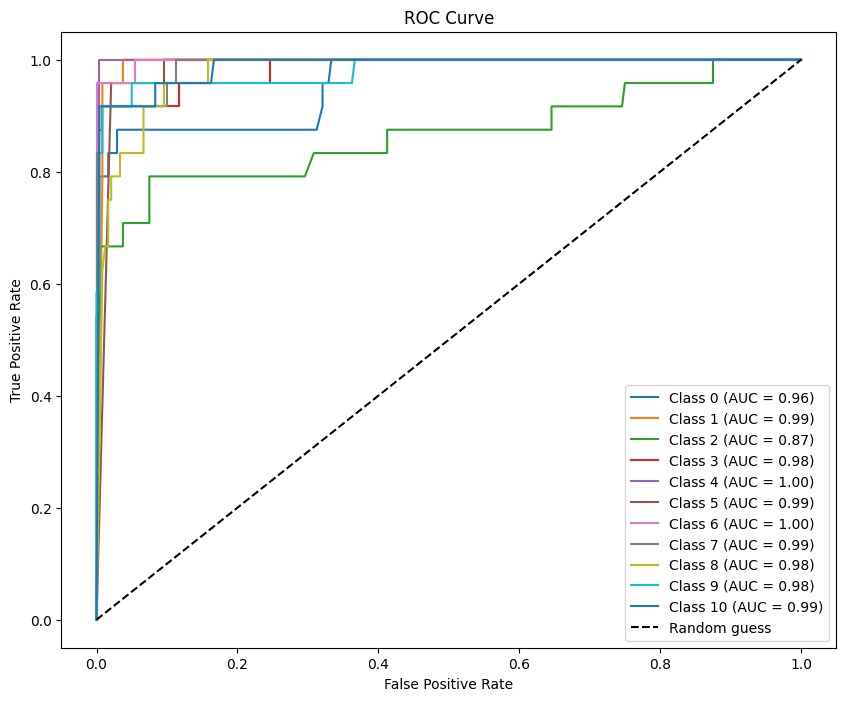

In [22]:
# 지표까지 나오는 테스트 코드
from sklearn.metrics import precision_score, recall_score, confusion_matrix, roc_curve, f1_score,auc
from sklearn.preprocessing import label_binarize, MinMaxScaler

testSet = IBMGestureDataset(datasetPath  =  '/home/DVSAttacks/slayerPytorch/exampleLoihi/03_IBMGesture/test/', 
                            sampleFile  ='/home/DVSAttacks/slayerPytorch/exampleLoihi/03_IBMGesture/test/test.txt',
                            samplingTime=1.0,
                            sampleLength=1450)
testLoader = DataLoader(dataset=testSet, batch_size=1, shuffle=False, num_workers=0)

test_clusteringSet = IBMGestureDataset(datasetPath ="/home/DVSAttacks/slayerPytorch/exampleLoihi/03_IBMGesture/mf_aware_dashattack_ps150_filtered_percentiles_iqr_fence_max/", 
                                       sampleFile="/home/DVSAttacks/slayerPytorch/exampleLoihi/03_IBMGesture/test/test.txt", 
                                       samplingTime=1.0, 
                                       sampleLength=1450)
test_clusterLoader = DataLoader(dataset=test_clusteringSet, batch_size=1, shuffle=True, num_workers=0)

def softmax(x):
    exp_x = np.exp(x - np.max(x))  # 수치 안정성
    return exp_x / exp_x.sum()

def softmax_for_samples(scores):
    return np.array([softmax(sample) for sample in scores])

for epoch in range(1):
    stats.testing.reset()
    tSt = datetime.now()
    
    y_true = []
    y_pred = []
    y_test = []
    y_score = []
    
    # Testing loop.
    for i, (input, target, label) in enumerate(test_clusterLoader, 0):
        net.eval()
        with torch.no_grad():
            input  = input.to(device)
            target = target.to(device) 

        y_true.append(label.item())
        
        output = net.forward(input)

        # 실험용 부분
        y_test.append(label.tolist()[0])
        numSpikes = torch.sum(output, 4, keepdim=True).cpu()
        y_score.append(numSpikes.reshape(numSpikes.shape[0], -1)[0].tolist())
        predict = snn.predict.getClass(output)
        y_pred.append(predict.item())
        
        stats.testing.correctSamples += torch.sum( predict == label ).data.item()
        stats.testing.numSamples     += len(label)

        loss = error.numSpikes(output, target)
        stats.testing.lossSum += loss.cpu().data.item()
        stats.print(epoch, i)

    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    print('precision: {0:.4f}, recall: {1:.4f}, f1: {2:.4f}'.format(precision, recall, f1))
    
    # ROC_Curve
    y_test = np.array(y_test)
    y_test = label_binarize(y_test, classes=np.arange(11))
    y_score = softmax_for_samples(np.array(y_score))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(11):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # ROC 곡선 시각화
    plt.figure(figsize=(10, 8))
    for i in range(11):
        plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

    plt.plot([0, 1], [0, 1], "k--", label="Random guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="best")
    plt.show()